In [1]:
import matplotlib.pyplot as plt  
import numpy as np
import os
import sys
import pandas as pd
import geopandas as gpd
import yaml

In [2]:
def process_key(key):
    # Convert string key to a tuple
    return safe_tuple_parser(key)

def process_value(value):
    # Convert string value to float
    return float(value)

def safe_tuple_parser(key):
    """
    Safely parses string representations of nested tuples into actual Python tuples.
    Example: "(2024, (1, 7, 0), (1, 8), 2024)" -> (2024, (1, 7, 0), (1, 8), 2024)
    """
    import ast  # Abstract Syntax Tree module for safe literal evaluation

    # Remove outer quotes if present and use `ast.literal_eval`
    try:
        return ast.literal_eval(key)
    except (SyntaxError, ValueError) as e:
        raise ValueError(f"Failed to parse key: {key}") from e

def read_data(case_study_name, input_folder_name, variables_to_read, run_id):
    current_path = os.getcwd()
    print("Current path:", current_path)
    file_results = os.path.normpath(current_path + "/results")
    print("File results:", os.path.normpath(file_results))
    file_path = os.path.join(current_path, "/results")
    print(file_path)
    # Normalize the path
    normalized_path = os.path.normpath(file_path)
    print("Normalized path:", normalized_path)

    # Reading input data from the folder
    folder_input = os.path.normpath(current_path + "/input_data/" + input_folder_name)
    input_data = {}
    for file_name in os.listdir(folder_input):
        if file_name.endswith(".yaml"):
            key_name = os.path.splitext(file_name)[0]  # Extract the key name from the file name
            if key_name != "SpatialFlexibilityEdges":  # Avoid overwriting existing keys
                with open(os.path.join(folder_input, file_name)) as file:
                    input_data[key_name] = yaml.safe_load(file)

    output_data = {}
    for variable in variables_to_read:
        file_name = os.path.normpath(file_results + "/" + input_folder_name + "/" + case_study_name + f"_{variable}_dict.yaml")
        with open(file_name) as file:
            data_dict = yaml.safe_load(file)
        output_data[variable] = {process_key(key): process_value(value) for key, value in data_dict.items()}
        print(f"Loaded {file_name} into output_data under variable '{variable}'")

    return input_data, output_data


In [19]:
case_study_names = ["case_20251103_114421"]
runs = ["case_20251103_114421_cs_2025-11-04_10-34-50"]
case_study_name_label = [
    "Shift to rail"
]

In [20]:
# Load data for all runs
variables_to_read = [
    "f",
     "h", "h_plus", "h_exist", "h_minus", "s"
    #"q_fuel_infr_plus", "soc", "travel_time", "extra_break_time"
]

loaded_runs = {}
for ij in range(len(case_study_names)):
    case_study_name = case_study_names[ij]
    results_file = runs[ij]
    input_data, output_data = read_data(results_file, case_study_name, variables_to_read, ij)
    loaded_runs[case_study_name] = {
        "input_data": input_data,
        "output_data": output_data
    }

print(f"✓ Loaded {len(loaded_runs)} run(s)")
print(f"  Case: {case_study_names[0]}")
print(f"  Run ID: {runs[0]}")

Current path: c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM
File results: c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results
c:/results
Normalized path: c:\results
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251103_114421\case_20251103_114421_cs_2025-11-04_10-34-50_f_dict.yaml into output_data under variable 'f'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251103_114421\case_20251103_114421_cs_2025-11-04_10-34-50_h_dict.yaml into output_data under variable 'h'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251103_114421\case_20251103_114421_cs_2025-11-04_10-34-50_h_plus_dict.yaml into output_data under variable 'h_plus'
Loaded c:\Github\SM\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251103_114421\case_20251103_114421_cs_2025-11-04_10-34-50_h_exist_dict.yaml into output_data under variable 'h_exist'
Loaded 

In [21]:
# ==============================================================================
# CALCULATE TKM (Tonne-Kilometers) PER MODE
# ==============================================================================
"""
Flow variable 'f' structure: f[year, (product_id, odpair_id, path_id), (mode_id, techvehicle_id), generation]

To calculate TKM:
1. Sum flow 'f' by mode across all OD-pairs, paths, techvehicles, generations
2. Multiply by path length to get TKM
3. Group by year and mode
"""

def calculate_tkm_per_mode(case_study_name):
    """
    Calculate TKM (tonne-kilometers) per mode and year.
    
    Returns:
        dict: {year: {'road': tkm, 'rail': tkm}}
    """
    # Get data for this case
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]
    
    # Load Path data (to get route lengths)
    paths = {p['id']: p for p in input_data['Path']}
    
    # Load Mode data (to get mode names)
    modes = {m['id']: m['name'] for m in input_data['Mode']}
    
    # Initialize TKM dictionary: {year: {mode_name: tkm}}
    tkm_by_year_mode = {}
    
    # Process each flow entry
    for key, flow_value in f_data.items():
        # Parse key: (year, (product_id, odpair_id, path_id), (mode_id, techvehicle_id), generation)
        year = key[0]
        product_odpair_path = key[1]  # (product_id, odpair_id, path_id)
        mode_techvehicle = key[2]     # (mode_id, techvehicle_id)
        generation = key[3]
        
        # Extract mode_id and path_id
        mode_id = mode_techvehicle[0]
        path_id = product_odpair_path[2]
        
        # Get mode name
        mode_name = modes.get(mode_id, f"mode_{mode_id}")
        
        # Get path length (km)
        path_length = paths[path_id]['length']
        
        # Calculate TKM = flow × distance
        tkm = flow_value * path_length
        
        # Initialize nested dict if needed
        if year not in tkm_by_year_mode:
            tkm_by_year_mode[year] = {}
        if mode_name not in tkm_by_year_mode[year]:
            tkm_by_year_mode[year][mode_name] = 0.0
        
        # Add to total
        tkm_by_year_mode[year][mode_name] += tkm
    
    return tkm_by_year_mode

# Calculate TKM for the run
case_name = case_study_names[0]
tkm_data = calculate_tkm_per_mode(case_name)

# Display summary
print("="*80)
print("TKM BY MODE AND YEAR")
print("="*80)
for year in sorted(tkm_data.keys()):
    print(f"\nYear {year}:")
    total_tkm = sum(tkm_data[year].values())
    for mode, tkm in sorted(tkm_data[year].items()):
        percentage = (tkm / total_tkm * 100) if total_tkm > 0 else 0
        print(f"  {mode:10s}: {tkm:15,.0f} tkm ({percentage:5.1f}%)")
    print(f"  {'TOTAL':10s}: {total_tkm:15,.0f} tkm")


TKM BY MODE AND YEAR

Year 2020:
  road      :      10,102,315 tkm (100.0%)
  TOTAL     :      10,102,315 tkm

Year 2022:
  road      :      10,443,589 tkm (100.0%)
  TOTAL     :      10,443,589 tkm

Year 2024:
  road      :      10,784,863 tkm (100.0%)
  TOTAL     :      10,784,863 tkm

Year 2026:
  rail      :         255,196 tkm (  2.3%)
  road      :      10,870,941 tkm ( 97.7%)
  TOTAL     :      11,126,137 tkm

Year 2028:
  rail      :         480,279 tkm (  4.2%)
  road      :      10,987,132 tkm ( 95.8%)
  TOTAL     :      11,467,411 tkm

Year 2030:
  rail      :         700,387 tkm (  5.9%)
  road      :      11,108,298 tkm ( 94.1%)
  TOTAL     :      11,808,685 tkm

Year 2032:
  rail      :         824,798 tkm (  6.8%)
  road      :      11,325,162 tkm ( 93.2%)
  TOTAL     :      12,149,959 tkm

Year 2034:
  rail      :       1,011,960 tkm (  8.1%)
  road      :      11,479,273 tkm ( 91.9%)
  TOTAL     :      12,491,233 tkm

Year 2036:
  rail      :       1,096,021 tkm (  8.5


✓ Plot saved as 'modal_shift_tkm.png'


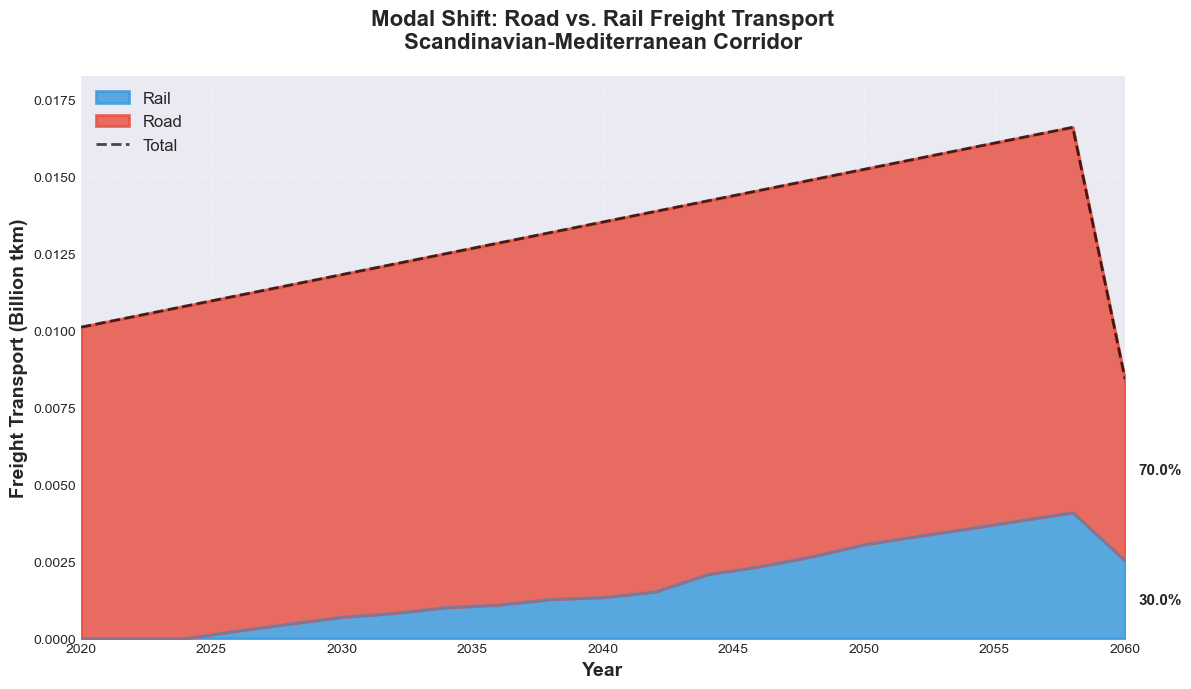

In [22]:
# ==============================================================================
# PLOT: TKM PER MODE OVER TIME
# ==============================================================================

# Prepare data for plotting
years = sorted(tkm_data.keys())
modes_in_data = set()
for year_data in tkm_data.values():
    modes_in_data.update(year_data.keys())

# Create data series for each mode
mode_series = {mode: [] for mode in sorted(modes_in_data)}
for year in years:
    for mode in mode_series.keys():
        mode_series[mode].append(tkm_data[year].get(mode, 0.0))

# Convert to billions for better readability
for mode in mode_series:
    mode_series[mode] = [tkm / 1e9 for tkm in mode_series[mode]]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for modes
mode_colors = {
    'road': '#E74C3C',  # Red
    'rail': '#3498DB',  # Blue
}

# Plot stacked area chart
bottom = np.zeros(len(years))
for mode in sorted(mode_series.keys()):
    color = mode_colors.get(mode, '#95A5A6')  # Default gray if mode not in dict
    ax.fill_between(years, bottom, bottom + mode_series[mode], 
                     label=mode.capitalize(), alpha=0.8, color=color, linewidth=2)
    # Add line on top for clarity
    ax.plot(years, bottom + mode_series[mode], color=color, linewidth=2, alpha=0.5)
    bottom += mode_series[mode]

# Add total line
total_tkm = [sum(tkm_data[year].values()) / 1e9 for year in years]
ax.plot(years, total_tkm, 'k--', linewidth=2, label='Total', alpha=0.7)

# Formatting
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Freight Transport (Billion tkm)', fontsize=14, fontweight='bold')
ax.set_title('Modal Shift: Road vs. Rail Freight Transport\nScandinavian-Mediterranean Corridor', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(years[0], years[-1])
ax.set_ylim(0, max(total_tkm) * 1.1)

# Add percentage labels for final year
final_year = years[-1]
final_total = sum(tkm_data[final_year].values())
y_pos = 0
for mode in sorted(mode_series.keys()):
    mode_tkm = tkm_data[final_year].get(mode, 0)
    pct = (mode_tkm / final_total * 100) if final_total > 0 else 0
    y_pos += mode_tkm / 1e9
    if pct > 2:  # Only label if >2% to avoid clutter
        ax.text(final_year + 0.5, y_pos - (mode_tkm / 1e9 / 2), 
                f'{pct:.1f}%', fontsize=11, fontweight='bold', 
                verticalalignment='center')

plt.tight_layout()
plt.savefig('modal_shift_tkm.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'modal_shift_tkm.png'")
plt.show()


{2042: {'BEV': 12266316.301740369, 'ICEV': 67586.68871058547}, 2040: {'BEV': 12053879.34100847, 'ICEV': 124293.51118386778}, 2032: {'BEV': 7788599.231599233, 'ICEV': 3536562.545737603}, 2054: {'BEV': 12336310.25049293}, 2058: {'BEV': 12496295.885461506}, 2050: {'BEV': 12169124.475394055}, 2020: {'ICEV': 10102314.805745633}, 2052: {'BEV': 12249173.425196536}, 2024: {'ICEV': 10784862.950022737}, 2022: {'ICEV': 10443588.862057878}, 2038: {'BEV': 10219822.139581745, 'ICEV': 1676299.3509057483}, 2044: {'BEV': 12115042.539264351}, 2034: {'ICEV': 3459732.925566233, 'BEV': 8019540.2869952135}, 2048: {'BEV': 12218922.408341503}, 2046: {'BEV': 12201483.856867094}, 2030: {'BEV': 4380627.566168069, 'ICEV': 6727670.231991435}, 2026: {'ICEV': 10870940.819112655}, 2056: {'BEV': 12414046.703114646}, 2036: {'BEV': 10027981.992399672, 'ICEV': 1708504.3253698426}, 2060: {'BEV': 5894867.291316272}, 2028: {'ICEV': 7379078.983849338, 'BEV': 3608053.4136633077}}
ROAD MODE: TECHNOLOGY SPLIT (ICEV vs BEV)

Yea

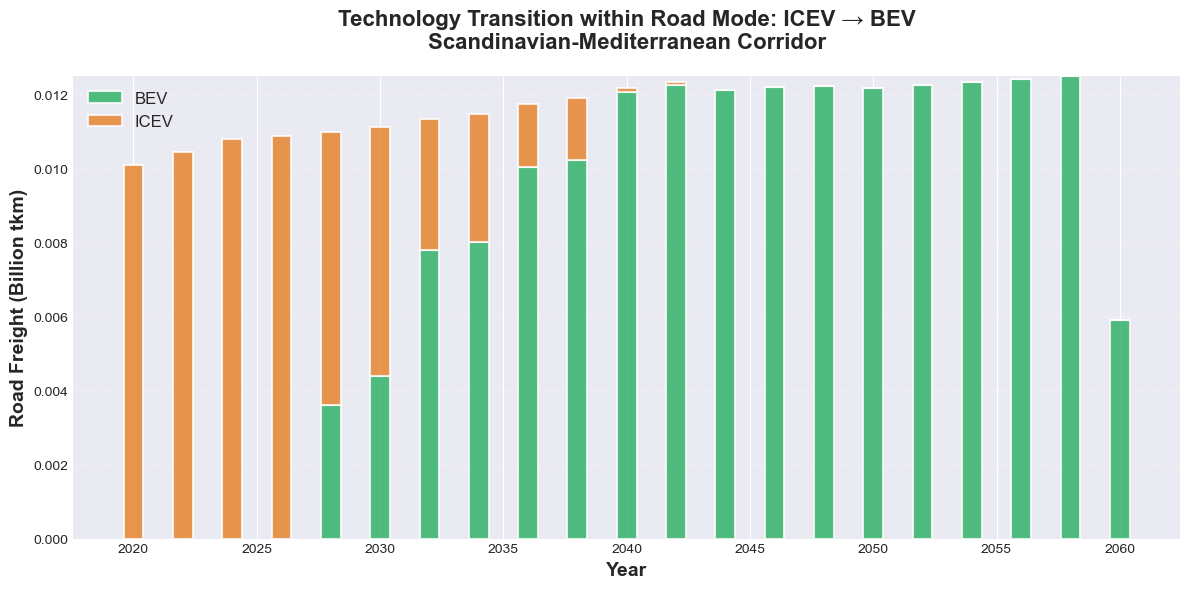

In [23]:
# ==============================================================================
# BONUS: TECHNOLOGY BREAKDOWN WITHIN ROAD MODE (ICEV vs BEV)
# ==============================================================================

def calculate_road_technology_split(case_study_name):
    """
    Calculate TKM by technology (ICEV vs BEV) within road mode.
    
    Returns:
        dict: {year: {'ICEV': tkm, 'BEV': tkm}}
    """
    # Get data
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]
    
    # Load reference data
    paths = {p['id']: p for p in input_data['Path']}
    techvehicles = {tv['id']: tv for tv in input_data['TechVehicle']}
    
    # Initialize
    tech_tkm = {}
    
    # Process flows
    for key, flow_value in f_data.items():
        year = key[0]
        product_odpair_path = key[1]
        mode_techvehicle = key[2]
        
        mode_id = mode_techvehicle[0]
        techvehicle_id = mode_techvehicle[1]
        path_id = product_odpair_path[2]
        
        # Only process road mode (mode_id == 1)
        if mode_id == 1:
            # Get technology name
            tv = techvehicles.get(techvehicle_id)
            if tv:
                tech_name = tv['name']  # 'ICEV' or 'BEV'
                
                # Calculate TKM
                path_length = paths[path_id]['length']
                tkm = flow_value * path_length
                
                # Store
                if year not in tech_tkm:
                    tech_tkm[year] = {}
                if tech_name not in tech_tkm[year]:
                    tech_tkm[year][tech_name] = 0.0
                tech_tkm[year][tech_name] += tkm
    
    return tech_tkm

# Calculate technology split
tech_data = calculate_road_technology_split(case_name)
print(tech_data)
# Display summary
print("="*80)
print("ROAD MODE: TECHNOLOGY SPLIT (ICEV vs BEV)")
print("="*80)
for year in sorted(tech_data.keys()):
    print(f"\nYear {year}:")
    total = sum(tech_data[year].values())
    for tech, tkm in sorted(tech_data[year].items()):
        pct = (tkm / total * 100) if total > 0 else 0
        print(f"  {tech:10s}: {tkm:15,.0f} tkm ({pct:5.1f}%)")
    print(f"  {'TOTAL':10s}: {total:15,.0f} tkm")

# Quick plot - Technology split over time
if tech_data:
    years_tech = sorted(tech_data.keys())
    tech_series = {}
    for year in years_tech:
        for tech in tech_data[year].keys():
            if tech not in tech_series:
                tech_series[tech] = []
    
    for year in years_tech:
        for tech in tech_series.keys():
            tech_series[tech].append(tech_data[year].get(tech, 0.0) / 1e9)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    tech_colors = {
        'ICEV': '#E67E22',  # Orange
        'BEV': '#27AE60',   # Green
    }
    
    bottom = np.zeros(len(years_tech))
    for tech in sorted(tech_series.keys()):
        color = tech_colors.get(tech, '#95A5A6')
        ax.bar(years_tech, tech_series[tech], bottom=bottom, 
               label=tech, alpha=0.8, color=color, edgecolor='white', linewidth=1.5)
        bottom += tech_series[tech]
    
    ax.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax.set_ylabel('Road Freight (Billion tkm)', fontsize=14, fontweight='bold')
    ax.set_title('Technology Transition within Road Mode: ICEV → BEV\nScandinavian-Mediterranean Corridor', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    plt.tight_layout()
    plt.savefig('technology_shift_road.png', dpi=300, bbox_inches='tight')
    print("\n✓ Plot saved as 'technology_shift_road.png'")
    plt.show()


✓ Modal share plot saved as 'rail_modal_share_by_distance.png'


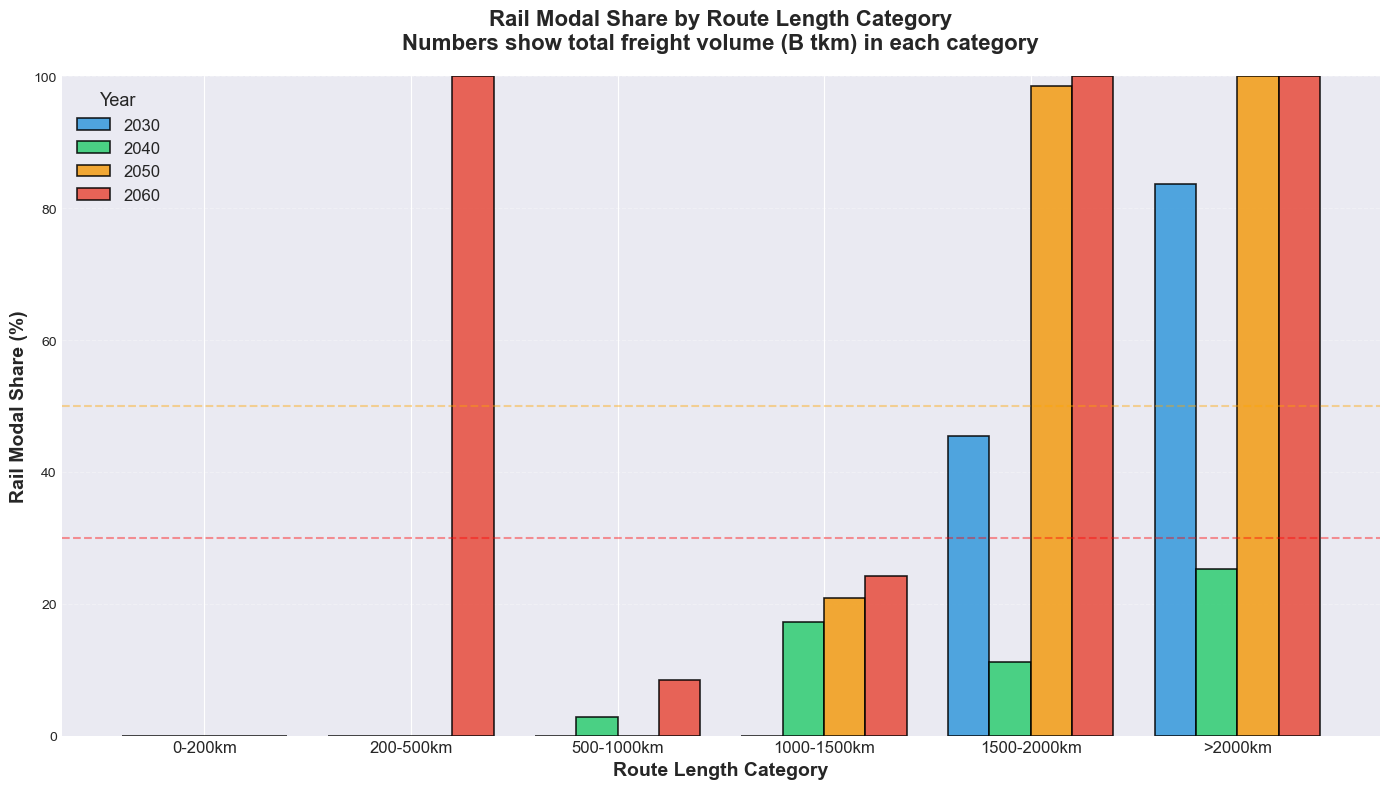


MODAL SPLIT BY DISTANCE CATEGORY

YEAR 2030
Category               Total (B tkm)    Rail (B tkm)    Road (B tkm)     Rail %
--------------------------------------------------------------------------------
200-500km                      0.001           0.000           0.001       0.0%
500-1000km                     0.005           0.000           0.005       0.0%
1000-1500km                    0.005           0.000           0.005       0.0%
1500-2000km                    0.001           0.001           0.001      45.4%
>2000km                        0.000           0.000           0.000      83.6%
--------------------------------------------------------------------------------
TOTAL                          0.012           0.001           0.011       5.9%

YEAR 2040
Category               Total (B tkm)    Rail (B tkm)    Road (B tkm)     Rail %
--------------------------------------------------------------------------------
200-500km                      0.001           0.000         

In [24]:
# ==============================================================================
# OPTION 1: ROUTE LENGTH DISTRIBUTION - MODAL SPLIT PERCENTAGE
# ==============================================================================

def analyze_modal_split_by_distance(case_study_name, selected_years=[2030, 2040, 2050, 2060]):
    """
    Analyze modal split (rail %) by route length categories.
    Returns both rail TKM and total TKM per category.
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]
    paths = {p['id']: p for p in input_data['Path']}
    
    # Define distance bins
    distance_bins = [0, 200, 500, 1000, 1500, 2000, 10000]
    bin_labels = ['0-200km', '200-500km', '500-1000km', '1000-1500km', '1500-2000km', '>2000km']
    
    # Initialize results: {year: {bin_label: {'road': tkm, 'rail': tkm, 'total': tkm}}}
    results = {year: {label: {'road': 0.0, 'rail': 0.0} for label in bin_labels} for year in selected_years}
    
    # Process flows
    for key, flow_value in f_data.items():
        year, (prod_id, od_id, path_id), (mode_id, tv_id), gen = key
        
        # Only selected years
        if year in selected_years and flow_value > 0:
            path_length = paths[path_id]['length']
            tkm = flow_value * path_length
            
            # Determine mode
            mode_name = 'rail' if mode_id == 2 else 'road'
            
            # Find bin
            for i, upper_bound in enumerate(distance_bins[1:]):
                if path_length <= upper_bound:
                    results[year][bin_labels[i]][mode_name] += tkm
                    break
    
    # Calculate totals and percentages
    for year in selected_years:
        for label in bin_labels:
            total = results[year][label]['road'] + results[year][label]['rail']
            results[year][label]['total'] = total
            results[year][label]['rail_pct'] = (results[year][label]['rail'] / total * 100) if total > 0 else 0
    
    return results, bin_labels

# Calculate
modal_split_data, bin_labels = analyze_modal_split_by_distance(case_name)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(bin_labels))
width = 0.2
colors = ['#3498DB', '#2ECC71', '#F39C12', '#E74C3C']

for i, year in enumerate([2030, 2040, 2050, 2060]):
    # Get rail percentage for each bin
    rail_percentages = [modal_split_data[year][label]['rail_pct'] for label in bin_labels]
    
    # Plot bars
    bars = ax.bar(x + i*width, rail_percentages, width, label=f'{year}', 
                  alpha=0.85, color=colors[i], edgecolor='black', linewidth=1.2)
    
    # Add total TKM labels on top of bars (if significant)
    for j, (bar, label) in enumerate(zip(bars, bin_labels)):
        total_tkm = modal_split_data[year][label]['total']
        if total_tkm > 0.01e9:  # Only label if > 0.01 billion tkm
            height = bar.get_height()
            if height > 2:  # Only label bars that are visible
                ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                       f'{total_tkm/1e9:.1f}B',
                       ha='center', va='bottom', fontsize=8, 
                       rotation=0, color=colors[i], fontweight='bold')

ax.set_xlabel('Route Length Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Rail Modal Share (%)', fontsize=14, fontweight='bold')
ax.set_title('Rail Modal Share by Route Length Category\nNumbers show total freight volume (B tkm) in each category', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(bin_labels, rotation=0, fontsize=12)
ax.legend(title='Year', fontsize=12, title_fontsize=13, loc='upper left')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, 100)

# Add reference lines
ax.axhline(30, color='red', linestyle='--', alpha=0.4, linewidth=1.5, label='30% rail share (target)')
ax.axhline(50, color='orange', linestyle='--', alpha=0.4, linewidth=1.5, label='50% rail share')

plt.tight_layout()
plt.savefig('rail_modal_share_by_distance.png', dpi=300, bbox_inches='tight')
print("✓ Modal share plot saved as 'rail_modal_share_by_distance.png'")
plt.show()

# Print detailed summary statistics
print("\n" + "="*80)
print("MODAL SPLIT BY DISTANCE CATEGORY")
print("="*80)
for year in [2030, 2040, 2050, 2060]:
    print(f"\n{'='*80}")
    print(f"YEAR {year}")
    print(f"{'='*80}")
    print(f"{'Category':<20} {'Total (B tkm)':>15} {'Rail (B tkm)':>15} {'Road (B tkm)':>15} {'Rail %':>10}")
    print("-" * 80)
    
    year_total_tkm = 0
    year_total_rail = 0
    
    for label in bin_labels:
        total = modal_split_data[year][label]['total']
        rail = modal_split_data[year][label]['rail']
        road = modal_split_data[year][label]['road']
        rail_pct = modal_split_data[year][label]['rail_pct']
        
        year_total_tkm += total
        year_total_rail += rail
        
        if total > 0:
            print(f"{label:<20} {total/1e9:>15.3f} {rail/1e9:>15.3f} {road/1e9:>15.3f} {rail_pct:>9.1f}%")
    
    print("-" * 80)
    overall_rail_pct = (year_total_rail / year_total_tkm * 100) if year_total_tkm > 0 else 0
    print(f"{'TOTAL':<20} {year_total_tkm/1e9:>15.3f} {year_total_rail/1e9:>15.3f} {(year_total_tkm-year_total_rail)/1e9:>15.3f} {overall_rail_pct:>9.1f}%")


✓ Snapshot plot saved as 'rail_shift_snapshot_2050.png'


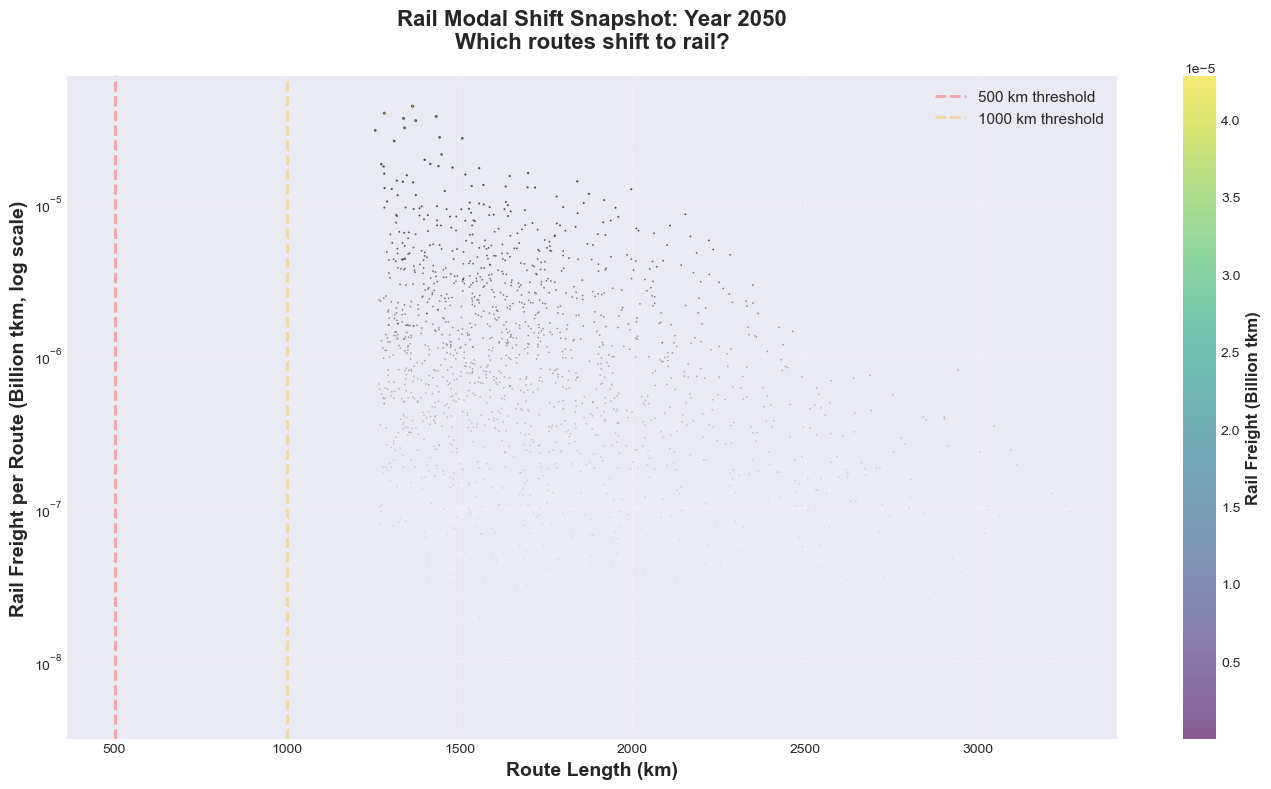


ROUTE LENGTH STATISTICS FOR RAIL SHIFTS (Year 2050)
Total routes using rail: 1545

Route length distribution:
  Min: 1255 km
  25th percentile: 1467 km
  Median: 1658 km
  Mean: 1759 km
  75th percentile: 1947 km
  Max: 3267 km

Rail TKM distribution:
  Total: 0.003 B tkm
  Min per route: 0.00 M tkm
  Median per route: 0.00 M tkm
  Mean per route: 0.00 M tkm
  Max per route: 0.04 M tkm

Breakdown by distance category:
  Long (1000-2000 km)      : 1201 routes,   0.003 B tkm ( 91.0%)
  Very Long (>2000 km)     :  344 routes,   0.000 B tkm (  9.0%)


In [25]:
# ==============================================================================
# OPTION 3: SCATTER PLOT - SINGLE YEAR SNAPSHOT (CLEARER VISUALIZATION)
# ==============================================================================

def get_route_level_rail_data_single_year(case_study_name, target_year=2050):
    """
    Get rail TKM for each unique route for a single year.
    Returns cleaner data for visualization.
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]
    paths = {p['id']: p for p in input_data['Path']}
    
    # Store: list of (route_length, tkm) tuples
    route_data = []
    
    for key, flow_value in f_data.items():
        year, (prod_id, od_id, path_id), (mode_id, tv_id), gen = key
        
        if mode_id == 2 and year == target_year and flow_value > 0:  # Rail only, specific year
            path_length = paths[path_id]['length']
            tkm = flow_value * path_length
            route_data.append({
                'route_id': (od_id, path_id),
                'length': path_length,
                'tkm': tkm
            })
    
    return pd.DataFrame(route_data)

# Get data for 2050 (change year as needed)
snapshot_year = 2050
df_snapshot = get_route_level_rail_data_single_year(case_name, snapshot_year)

# Aggregate by route if needed (sum tkm for same route across generations)
df_agg = df_snapshot.groupby(['route_id', 'length'], as_index=False)['tkm'].sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Bubble size proportional to TKM
sizes = df_agg['tkm'] / 1e6 * 50  # Scale for visibility

# Color by TKM magnitude (log scale for better color distribution)
tkm_values = df_agg['tkm'] / 1e9  # Convert to billions for color mapping

scatter = ax.scatter(df_agg['length'], tkm_values, 
                     s=sizes, alpha=0.6, c=tkm_values,
                     cmap='viridis', edgecolors='black', linewidth=0.8)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Rail Freight (Billion tkm)', fontsize=12, fontweight='bold')

# Formatting
ax.set_xlabel('Route Length (km)', fontsize=14, fontweight='bold')
ax.set_ylabel('Rail Freight per Route (Billion tkm)', fontsize=14, fontweight='bold')
ax.set_title(f'Rail Modal Shift Snapshot: Year {snapshot_year}\nWhich routes shift to rail?', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add reference lines for key distance thresholds
ax.axvline(500, color='red', linestyle='--', alpha=0.3, linewidth=2, label='500 km threshold')
ax.axvline(1000, color='orange', linestyle='--', alpha=0.3, linewidth=2, label='1000 km threshold')

ax.legend(fontsize=11, loc='upper right', framealpha=0.9)

# Set log scale for y-axis if there's large variation
if tkm_values.max() / tkm_values.min() > 100:
    ax.set_yscale('log')
    ax.set_ylabel('Rail Freight per Route (Billion tkm, log scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'rail_shift_snapshot_{snapshot_year}.png', dpi=300, bbox_inches='tight')
print(f"✓ Snapshot plot saved as 'rail_shift_snapshot_{snapshot_year}.png'")
plt.show()

# Summary statistics
print("\n" + "="*80)
print(f"ROUTE LENGTH STATISTICS FOR RAIL SHIFTS (Year {snapshot_year})")
print("="*80)
print(f"Total routes using rail: {len(df_agg)}")
print(f"\nRoute length distribution:")
print(f"  Min: {df_agg['length'].min():.0f} km")
print(f"  25th percentile: {df_agg['length'].quantile(0.25):.0f} km")
print(f"  Median: {df_agg['length'].median():.0f} km")
print(f"  Mean: {df_agg['length'].mean():.0f} km")
print(f"  75th percentile: {df_agg['length'].quantile(0.75):.0f} km")
print(f"  Max: {df_agg['length'].max():.0f} km")

print(f"\nRail TKM distribution:")
print(f"  Total: {df_agg['tkm'].sum()/1e9:.3f} B tkm")
print(f"  Min per route: {df_agg['tkm'].min()/1e6:.2f} M tkm")
print(f"  Median per route: {df_agg['tkm'].median()/1e6:.2f} M tkm")
print(f"  Mean per route: {df_agg['tkm'].mean()/1e6:.2f} M tkm")
print(f"  Max per route: {df_agg['tkm'].max()/1e6:.2f} M tkm")

# Distance category breakdown
print(f"\nBreakdown by distance category:")
categories = [
    (0, 500, "Short (<500 km)"),
    (500, 1000, "Medium (500-1000 km)"),
    (1000, 2000, "Long (1000-2000 km)"),
    (2000, 10000, "Very Long (>2000 km)")
]

for min_dist, max_dist, label in categories:
    subset = df_agg[(df_agg['length'] > min_dist) & (df_agg['length'] <= max_dist)]
    if len(subset) > 0:
        total_tkm = subset['tkm'].sum()
        pct = (total_tkm / df_agg['tkm'].sum() * 100)
        print(f"  {label:25s}: {len(subset):4d} routes, {total_tkm/1e9:7.3f} B tkm ({pct:5.1f}%)")


Calculating TKM by NUTS2 region and mode...
Found 75 NUTS2 regions

Calculating modal split by latitude...

SUMMARY: NUTS2 REGIONS WITH TRAFFIC

Year 2030: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 0.0% to 68.9%
  Average rail share: 9.3%

Year 2040: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 0.0% to 69.5%
  Average rail share: 11.2%

Year 2050: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 2.0% to 99.2%
  Average rail share: 28.2%

✓ Plot saved as 'modal_split_by_latitude.png'


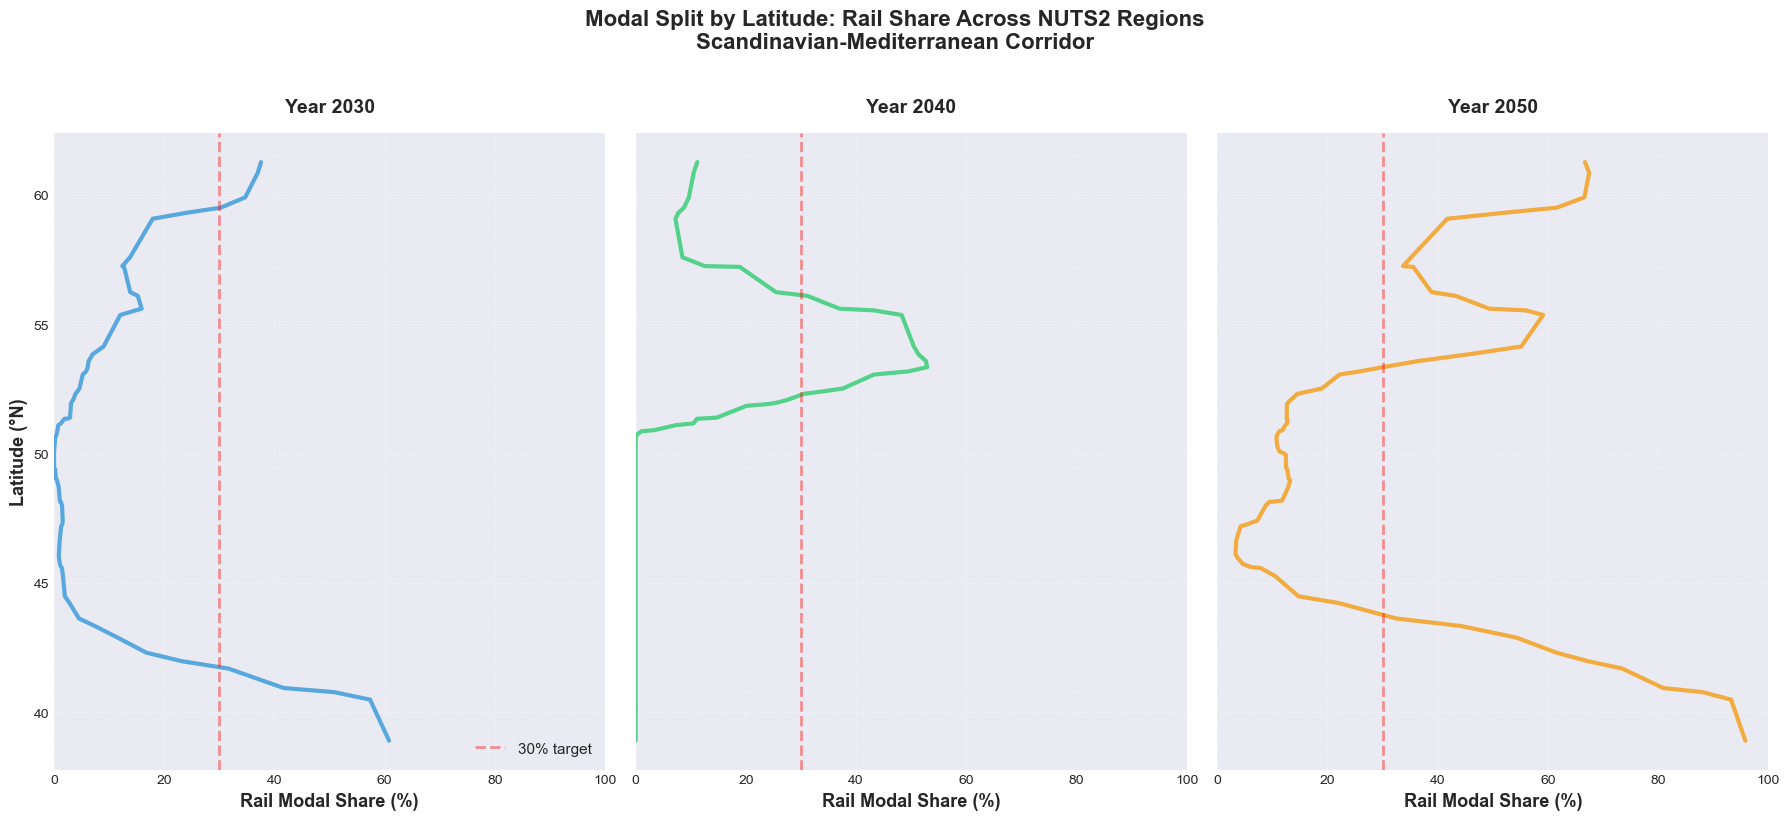


RAIL SHARE BY LATITUDE BAND

Year 2030 - Rail Share by Latitude Band:
Latitude Band           # Regions   Avg Rail %   Total TKM (M)
-----------------------------------------------------------------
35°N - 40°N                   1        68.9%            0.0
40°N - 45°N                  11        22.0%            1.4
45°N - 50°N                  24         0.9%            5.2
50°N - 55°N                  25         2.9%            3.6
55°N - 60°N                  12        18.0%            1.6
60°N - 65°N                   2        40.1%            0.1

Year 2040 - Rail Share by Latitude Band:
Latitude Band           # Regions   Avg Rail %   Total TKM (M)
-----------------------------------------------------------------
35°N - 40°N                   1         0.0%            0.0
40°N - 45°N                  11         0.0%            1.6
45°N - 50°N                  24         0.0%            5.9
50°N - 55°N                  25        22.5%            4.1
55°N - 60°N                  

In [26]:
# ==============================================================================
# MODAL SPLIT BY LATITUDE - CONTINUOUS LINE PLOT
# ==============================================================================
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

def calculate_tkm_by_nuts2_and_mode(case_study_name, target_years=[2030, 2040, 2050]):
    """
    Calculate TKM passing through each NUTS2 region by mode and year.

    Uses distance_from_previous to assign TKM to each node in path sequence.

    Returns:
        dict: {year: {nuts2_id: {'road': tkm, 'rail': tkm, 'lat': latitude}}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]

    # Load geographic elements and filter to NUTS2 nodes
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long']
            }

    print(f"Found {len(nuts2_lookup)} NUTS2 regions")

    # Load paths
    paths = {p['id']: p for p in input_data['Path']}

    # Initialize: {year: {geo_id: {mode: tkm}}}
    tkm_by_year_geo_mode = {year: {} for year in target_years}

    # Process each flow
    for key, flow_value in f_data.items():
        year, (prod_id, od_id, path_id), (mode_id, tv_id), gen = key

        if year not in target_years or flow_value <= 0:
            continue

        # Get path data
        path = paths[path_id]
        sequence = path['sequence']
        distance_from_previous = path['distance_from_previous']

        # Assign TKM to each node based on distance_from_previous
        for i, node_id in enumerate(sequence):
            # Only process NUTS2 nodes
            if node_id not in nuts2_lookup:
                continue

            # TKM = flow × distance traveled TO this node
            segment_distance = distance_from_previous[i]
            tkm_segment = flow_value * segment_distance

            # Initialize if needed
            if node_id not in tkm_by_year_geo_mode[year]:
                tkm_by_year_geo_mode[year][node_id] = {
                    'road': 0.0,
                    'rail': 0.0,
                    'lat': nuts2_lookup[node_id]['lat'],
                    'nuts2': nuts2_lookup[node_id]['nuts2']
                }

            # Add to appropriate mode
            mode_name = 'rail' if mode_id == 2 else 'road'
            tkm_by_year_geo_mode[year][node_id][mode_name] += tkm_segment

    return tkm_by_year_geo_mode

def calculate_modal_split_by_latitude(tkm_by_year_geo_mode):
    """
    Calculate rail modal share percentage for each NUTS2 region.

    Returns:
        dict: {year: [(latitude, rail_share_pct, total_tkm), ...]} sorted by latitude
    """
    results = {}

    for year, geo_data in tkm_by_year_geo_mode.items():
        year_results = []

        for geo_id, data in geo_data.items():
            road_tkm = data['road']
            rail_tkm = data['rail']
            total_tkm = road_tkm + rail_tkm

            if total_tkm > 0:
                rail_share = (rail_tkm / total_tkm) * 100
                year_results.append((data['lat'], rail_share, total_tkm))

        # Sort by latitude
        year_results.sort(key=lambda x: x[0])
        results[year] = year_results

    return results

# Calculate data
print("Calculating TKM by NUTS2 region and mode...")
tkm_data_geo = calculate_tkm_by_nuts2_and_mode(case_name, target_years=[2030, 2040, 2050])

print("\nCalculating modal split by latitude...")
modal_split_by_lat = calculate_modal_split_by_latitude(tkm_data_geo)

# Display summary
print("\n" + "="*80)
print("SUMMARY: NUTS2 REGIONS WITH TRAFFIC")
print("="*80)
for year in [2030, 2040, 2050]:
    data = modal_split_by_lat[year]
    print(f"\nYear {year}: {len(data)} NUTS2 regions with traffic")
    if data:
        lats = [x[0] for x in data]
        shares = [x[1] for x in data]
        print(f"  Latitude range: {min(lats):.2f}° to {max(lats):.2f}°")
        print(f"  Rail share range: {min(shares):.1f}% to {max(shares):.1f}%")
        print(f"  Average rail share: {np.mean(shares):.1f}%")

# ==============================================================================
# PLOT: MODAL SPLIT BY LATITUDE - THREE SUBPLOTS
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

years_to_plot = [2030, 2040, 2050]
colors = ['#3498DB', '#2ECC71', '#F39C12']

for idx, (ax, year, color) in enumerate(zip(axes, years_to_plot, colors)):
    data = modal_split_by_lat[year]

    if not data:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        continue

    # Extract data
    latitudes = np.array([x[0] for x in data])
    rail_shares = np.array([x[1] for x in data])
    total_tkms = np.array([x[2] for x in data])

    # Smooth the data for continuous line
    # Use Gaussian filter for smoothing
    if len(latitudes) > 3:
        # Sort data by latitude to ensure smooth interpolation
        sort_idx = np.argsort(latitudes)
        lat_sorted = latitudes[sort_idx]
        share_sorted = rail_shares[sort_idx]

        # Apply Gaussian smoothing (sigma controls smoothness)
        share_smoothed = gaussian_filter1d(share_sorted, sigma=1.5)

        # Plot smoothed line
        ax.plot(share_smoothed, lat_sorted, color=color, linewidth=3, alpha=0.8)

    else:
        # Not enough points for smoothing
        ax.plot(rail_shares, latitudes, color=color, linewidth=3, alpha=0.8)

    # Formatting
    ax.set_xlabel('Rail Modal Share (%)', fontsize=13, fontweight='bold')
    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(0, 100)

    # Add reference line at 30% rail share
    ax.axvline(30, color='red', linestyle='--', alpha=0.4, linewidth=2, label='30% target')

    if idx == 0:
        ax.legend(fontsize=11, loc='lower right', framealpha=0.9)

    # Add latitude labels on y-axis
    if idx == 0:
        ax.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')

# Overall title
fig.suptitle('Modal Split by Latitude: Rail Share Across NUTS2 Regions\nScandinavian-Mediterranean Corridor',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('modal_split_by_latitude.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'modal_split_by_latitude.png'")
plt.show()

# ==============================================================================
# DETAILED STATISTICS BY LATITUDE BAND
# ==============================================================================

def analyze_by_latitude_band(modal_split_by_lat, year):
    """Group NUTS2 regions into latitude bands and calculate average rail share."""
    data = modal_split_by_lat[year]

    # Define latitude bands (every 5 degrees)
    lat_min = min(x[0] for x in data)
    lat_max = max(x[0] for x in data)

    # Create bands
    bands = []
    current = int(lat_min / 5) * 5
    while current <= lat_max:
        bands.append((current, current + 5))
        current += 5

    print(f"\nYear {year} - Rail Share by Latitude Band:")
    print(f"{'Latitude Band':<20} {'# Regions':>12} {'Avg Rail %':>12} {'Total TKM (M)':>15}")
    print("-" * 65)

    for band_min, band_max in bands:
        # Filter data for this band
        band_data = [x for x in data if band_min <= x[0] < band_max]

        if band_data:
            n_regions = len(band_data)
            avg_rail_share = np.mean([x[1] for x in band_data])
            total_tkm = sum([x[2] for x in band_data])

            print(f"{band_min:2d}°N - {band_max:2d}°N{' ':<7} {n_regions:12d} {avg_rail_share:11.1f}% {total_tkm/1e6:14.1f}")

print("\n" + "="*80)
print("RAIL SHARE BY LATITUDE BAND")
print("="*80)
for year in [2030, 2040, 2050]:
    analyze_by_latitude_band(modal_split_by_lat, year)


Calculating TKM by NUTS2 region and mode...
Found 75 NUTS2 regions

Calculating modal split by latitude...

SUMMARY: NUTS2 REGIONS WITH TRAFFIC

Year 2030: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 0.0% to 68.9%
  Average rail share: 9.3%

Year 2040: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 0.0% to 69.5%
  Average rail share: 11.2%

Year 2050: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  Rail share range: 2.0% to 99.2%
  Average rail share: 28.2%
Loaded 6 countries from CSV
Corridor countries: 6
Subplot 0: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding label: NO at 60.3°N
  Adding label: SE at 57.9°N
Subplot 1: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding label: NO at 60.3°N
  A

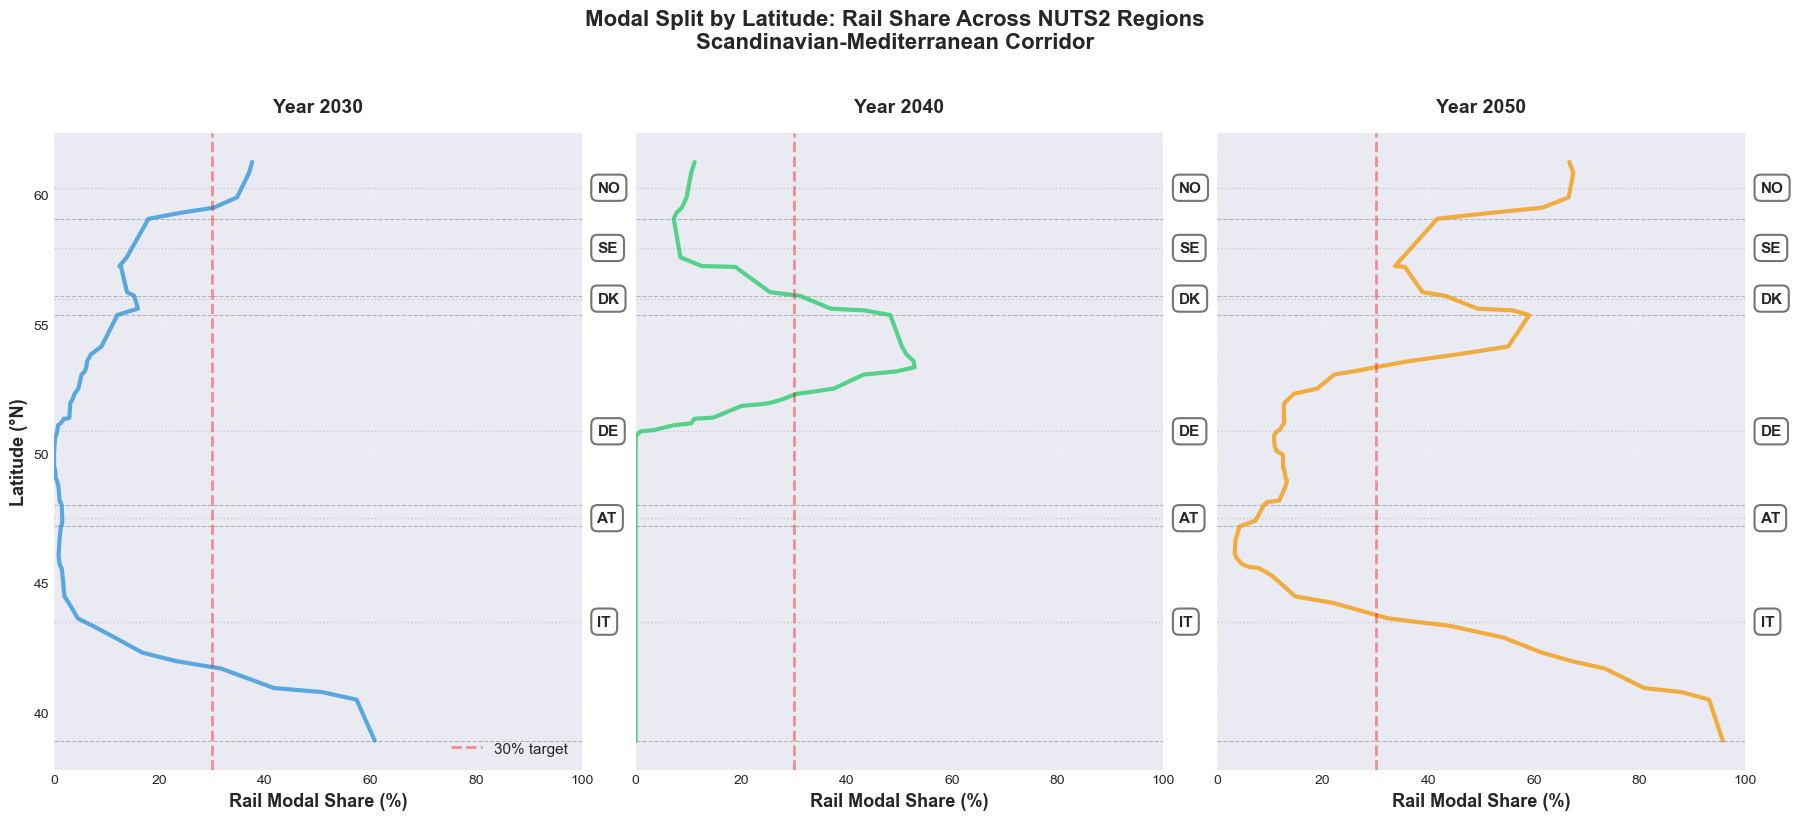


RAIL SHARE BY LATITUDE BAND

Year 2030 - Rail Share by Latitude Band:
Latitude Band           # Regions   Avg Rail %   Total TKM (M)
-----------------------------------------------------------------
35°N - 40°N                   1        68.9%            0.0
40°N - 45°N                  11        22.0%            1.4
45°N - 50°N                  24         0.9%            5.2
50°N - 55°N                  25         2.9%            3.6
55°N - 60°N                  12        18.0%            1.6
60°N - 65°N                   2        40.1%            0.1

Year 2040 - Rail Share by Latitude Band:
Latitude Band           # Regions   Avg Rail %   Total TKM (M)
-----------------------------------------------------------------
35°N - 40°N                   1         0.0%            0.0
40°N - 45°N                  11         0.0%            1.6
45°N - 50°N                  24         0.0%            5.9
50°N - 55°N                  25        22.5%            4.1
55°N - 60°N                  

In [27]:
# ==============================================================================
# MODAL SPLIT BY LATITUDE - CONTINUOUS LINE PLOT
# ==============================================================================
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

def calculate_tkm_by_nuts2_and_mode(case_study_name, target_years=[2030, 2040, 2050]):
    """
    Calculate TKM passing through each NUTS2 region by mode and year.

    Uses distance_from_previous to assign TKM to each node in path sequence.

    Returns:
        dict: {year: {nuts2_id: {'road': tkm, 'rail': tkm, 'lat': latitude}}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]

    # Load geographic elements and filter to NUTS2 nodes
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long']
            }

    print(f"Found {len(nuts2_lookup)} NUTS2 regions")

    # Load paths
    paths = {p['id']: p for p in input_data['Path']}

    # Initialize: {year: {geo_id: {mode: tkm}}}
    tkm_by_year_geo_mode = {year: {} for year in target_years}

    # Process each flow
    for key, flow_value in f_data.items():
        year, (prod_id, od_id, path_id), (mode_id, tv_id), gen = key

        if year not in target_years or flow_value <= 0:
            continue

        # Get path data
        path = paths[path_id]
        sequence = path['sequence']
        distance_from_previous = path['distance_from_previous']

        # Assign TKM to each node based on distance_from_previous
        for i, node_id in enumerate(sequence):
            # Only process NUTS2 nodes
            if node_id not in nuts2_lookup:
                continue

            # TKM = flow × distance traveled TO this node
            segment_distance = distance_from_previous[i]
            tkm_segment = flow_value * segment_distance

            # Initialize if needed
            if node_id not in tkm_by_year_geo_mode[year]:
                tkm_by_year_geo_mode[year][node_id] = {
                    'road': 0.0,
                    'rail': 0.0,
                    'lat': nuts2_lookup[node_id]['lat'],
                    'nuts2': nuts2_lookup[node_id]['nuts2']
                }

            # Add to appropriate mode
            mode_name = 'rail' if mode_id == 2 else 'road'
            tkm_by_year_geo_mode[year][node_id][mode_name] += tkm_segment

    return tkm_by_year_geo_mode

def calculate_modal_split_by_latitude(tkm_by_year_geo_mode):
    """
    Calculate rail modal share percentage for each NUTS2 region.

    Returns:
        dict: {year: [(latitude, rail_share_pct, total_tkm), ...]} sorted by latitude
    """
    results = {}

    for year, geo_data in tkm_by_year_geo_mode.items():
        year_results = []

        for geo_id, data in geo_data.items():
            road_tkm = data['road']
            rail_tkm = data['rail']
            total_tkm = road_tkm + rail_tkm

            if total_tkm > 0:
                rail_share = (rail_tkm / total_tkm) * 100
                year_results.append((data['lat'], rail_share, total_tkm))

        # Sort by latitude
        year_results.sort(key=lambda x: x[0])
        results[year] = year_results

    return results

# Calculate data
print("Calculating TKM by NUTS2 region and mode...")
tkm_data_geo = calculate_tkm_by_nuts2_and_mode(case_name, target_years=[2030, 2040, 2050])

print("\nCalculating modal split by latitude...")
modal_split_by_lat = calculate_modal_split_by_latitude(tkm_data_geo)

# Display summary
print("\n" + "="*80)
print("SUMMARY: NUTS2 REGIONS WITH TRAFFIC")
print("="*80)
for year in [2030, 2040, 2050]:
    data = modal_split_by_lat[year]
    print(f"\nYear {year}: {len(data)} NUTS2 regions with traffic")
    if data:
        lats = [x[0] for x in data]
        shares = [x[1] for x in data]
        print(f"  Latitude range: {min(lats):.2f}° to {max(lats):.2f}°")
        print(f"  Rail share range: {min(shares):.1f}% to {max(shares):.1f}%")
        print(f"  Average rail share: {np.mean(shares):.1f}%")

# ==============================================================================
# PLOT: MODAL SPLIT BY LATITUDE - THREE SUBPLOTS
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

years_to_plot = [2030, 2040, 2050]
colors = ['#3498DB', '#2ECC71', '#F39C12']

for idx, (ax, year, color) in enumerate(zip(axes, years_to_plot, colors)):
    data = modal_split_by_lat[year]

    if not data:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        continue

    # Extract data
    latitudes = np.array([x[0] for x in data])
    rail_shares = np.array([x[1] for x in data])
    total_tkms = np.array([x[2] for x in data])

    # Smooth the data for continuous line
    # Use Gaussian filter for smoothing
    if len(latitudes) > 3:
        # Sort data by latitude to ensure smooth interpolation
        sort_idx = np.argsort(latitudes)
        lat_sorted = latitudes[sort_idx]
        share_sorted = rail_shares[sort_idx]

        # Apply Gaussian smoothing (sigma controls smoothness)
        share_smoothed = gaussian_filter1d(share_sorted, sigma=1.5)

        # Plot smoothed line
        ax.plot(share_smoothed, lat_sorted, color=color, linewidth=3, alpha=0.8)

    else:
        # Not enough points for smoothing
        ax.plot(rail_shares, latitudes, color=color, linewidth=3, alpha=0.8)

    # Formatting
    ax.set_xlabel('Rail Modal Share (%)', fontsize=13, fontweight='bold')
    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(0, 100)

    # Add reference line at 30% rail share
    ax.axvline(30, color='red', linestyle='--', alpha=0.4, linewidth=2, label='30% target')

    if idx == 0:
        ax.legend(fontsize=11, loc='lower right', framealpha=0.9)

    # Add latitude labels on y-axis
    if idx == 0:
        ax.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')

# Overall title
fig.suptitle('Modal Split by Latitude: Rail Share Across NUTS2 Regions\nScandinavian-Mediterranean Corridor',
             fontsize=16, fontweight='bold', y=1.02)

# ==============================================================================
# ==============================================================================
# ADD COUNTRY LABELS ON Y-AXIS
# ==============================================================================

# Load country centroids
country_centroids = pd.read_csv('country_centroids.csv')

# Load country southern borders for dashed lines
borders_df = pd.read_csv('country_southern_borders.csv')
print(f'Loaded {len(country_centroids)} countries from CSV')

# Filter to countries in the corridor
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]
print(f'Corridor countries: {len(country_data)}')

# Add country labels to each subplot
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for idx, ax in enumerate(ax_list):
    ylim = ax.get_ylim()
    print(f'Subplot {idx}: y-range = {ylim[0]:.1f} to {ylim[1]:.1f}')
    
    # Add country labels
    for _, row in country_data.iterrows():
        country_code = row['CNTR_CODE']
        lat = row['centroid_lat']
        
        if ylim[0] <= lat <= ylim[1]:
            print(f'  Adding label: {country_code} at {lat:.1f}°N')
            ax.axhline(lat, color='gray', linestyle=':', alpha=0.3, linewidth=1.0, zorder=1)
            ax.text(1.03, lat, country_code, transform=ax.get_yaxis_transform(),
                   fontsize=11, fontweight='bold', va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='#666', alpha=0.9, linewidth=1.5),
                   zorder=10)

print('OK Country labels added to latitude plots')

# Add dashed lines for country southern borders
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'SE', 'NO']
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for ax in ax_list:
    ylim = ax.get_ylim()
    
    for _, row in borders_df.iterrows():
        country = row['CNTR_CODE']
        border_lat = row['southern_border_lat']
        
        if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
            ax.axhline(y=border_lat, color='gray', linestyle='--', 
                      linewidth=0.8, alpha=0.5, zorder=1)

plt.tight_layout()
plt.savefig('modal_split_by_latitude.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'modal_split_by_latitude.png'")
plt.show()

# ==============================================================================
# DETAILED STATISTICS BY LATITUDE BAND
# ==============================================================================

def analyze_by_latitude_band(modal_split_by_lat, year):
    """Group NUTS2 regions into latitude bands and calculate average rail share."""
    data = modal_split_by_lat[year]

    # Define latitude bands (every 5 degrees)
    lat_min = min(x[0] for x in data)
    lat_max = max(x[0] for x in data)

    # Create bands
    bands = []
    current = int(lat_min / 5) * 5
    while current <= lat_max:
        bands.append((current, current + 5))
        current += 5

    print(f"\nYear {year} - Rail Share by Latitude Band:")
    print(f"{'Latitude Band':<20} {'# Regions':>12} {'Avg Rail %':>12} {'Total TKM (M)':>15}")
    print("-" * 65)

    for band_min, band_max in bands:
        # Filter data for this band
        band_data = [x for x in data if band_min <= x[0] < band_max]

        if band_data:
            n_regions = len(band_data)
            avg_rail_share = np.mean([x[1] for x in band_data])
            total_tkm = sum([x[2] for x in band_data])

            print(f"{band_min:2d}°N - {band_max:2d}°N{' ':<7} {n_regions:12d} {avg_rail_share:11.1f}% {total_tkm/1e6:14.1f}")

print("\n" + "="*80)
print("RAIL SHARE BY LATITUDE BAND")
print("="*80)
for year in [2030, 2040, 2050]:
    analyze_by_latitude_band(modal_split_by_lat, year)


Calculating total TKM by latitude...

SUMMARY: TOTAL TKM BY LATITUDE

Year 2030: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  TKM range: 0.000 to 0.001 B tkm
  Total TKM: 0.012 B tkm
  Average per region: 0.000 B tkm

Year 2040: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  TKM range: 0.000 to 0.002 B tkm
  Total TKM: 0.014 B tkm
  Average per region: 0.000 B tkm

Year 2050: 75 NUTS2 regions with traffic
  Latitude range: 38.90° to 61.26°
  TKM range: 0.000 to 0.002 B tkm
  Total TKM: 0.015 B tkm
  Average per region: 0.000 B tkm
Loaded 6 countries from CSV
Corridor countries: 6
Subplot 0: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding label: NO at 60.3°N
  Adding label: SE at 57.9°N
Subplot 1: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding labe

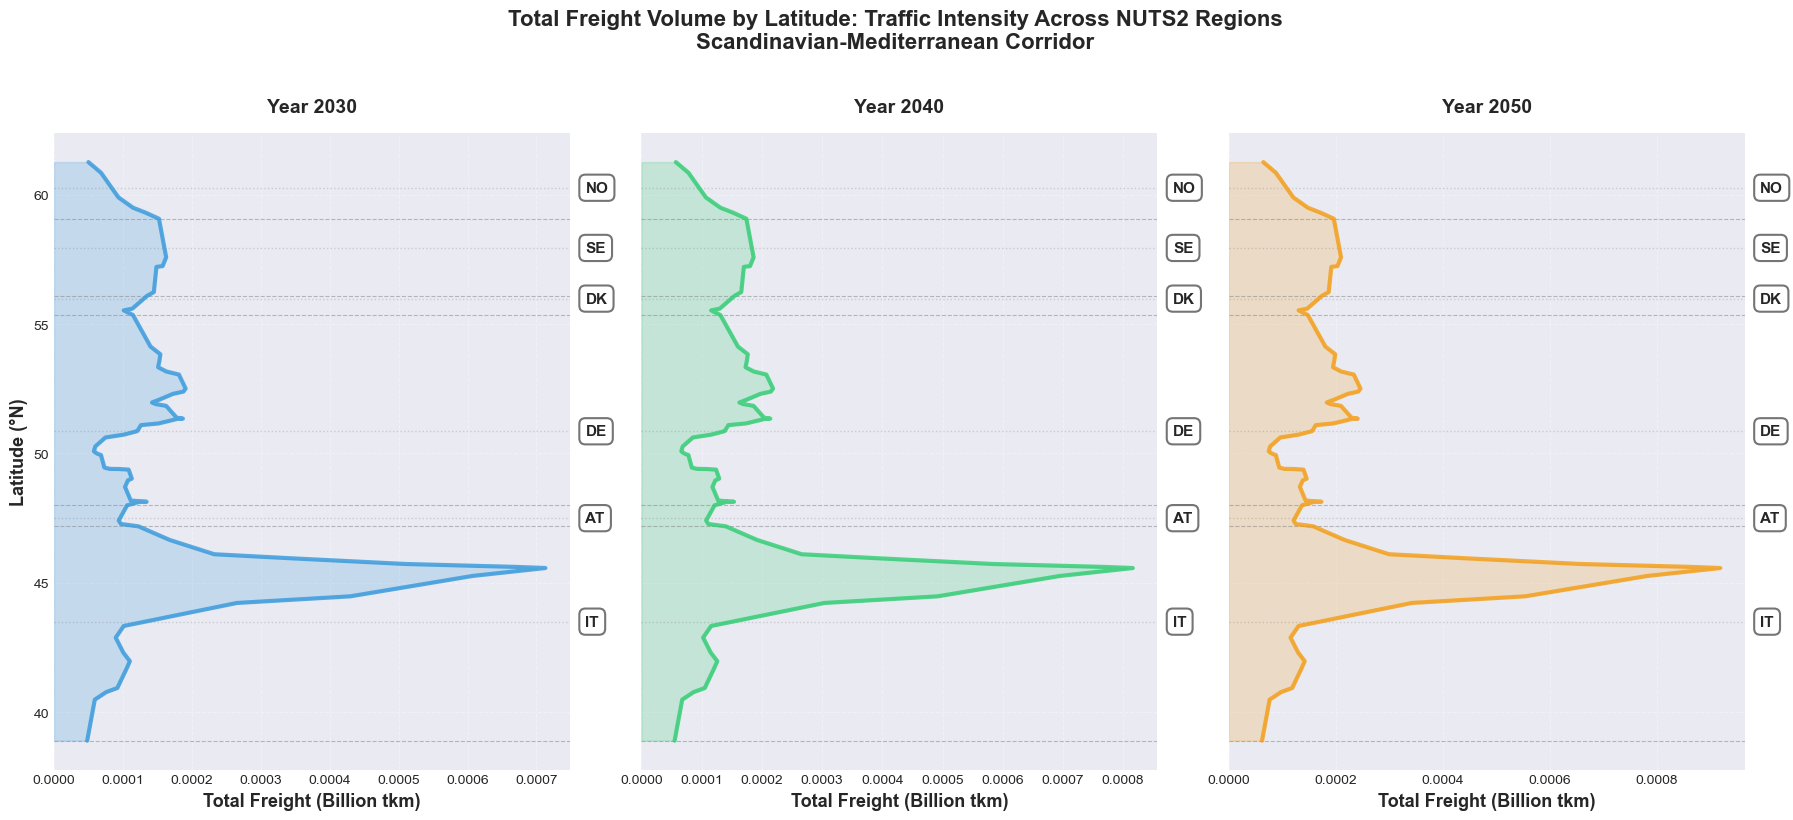


TOTAL TKM BY LATITUDE BAND

Year 2030 - Total TKM by Latitude Band:
Latitude Band           # Regions   Total TKM (B)   Avg per Region (B)
------------------------------------------------------------------------
35°N - 40°N                   1          0.000               0.000
40°N - 45°N                  11          0.001               0.000
45°N - 50°N                  24          0.005               0.000
50°N - 55°N                  25          0.004               0.000
55°N - 60°N                  12          0.002               0.000
60°N - 65°N                   2          0.000               0.000

Year 2040 - Total TKM by Latitude Band:
Latitude Band           # Regions   Total TKM (B)   Avg per Region (B)
------------------------------------------------------------------------
35°N - 40°N                   1          0.000               0.000
40°N - 45°N                  11          0.002               0.000
45°N - 50°N                  24          0.006               0.000

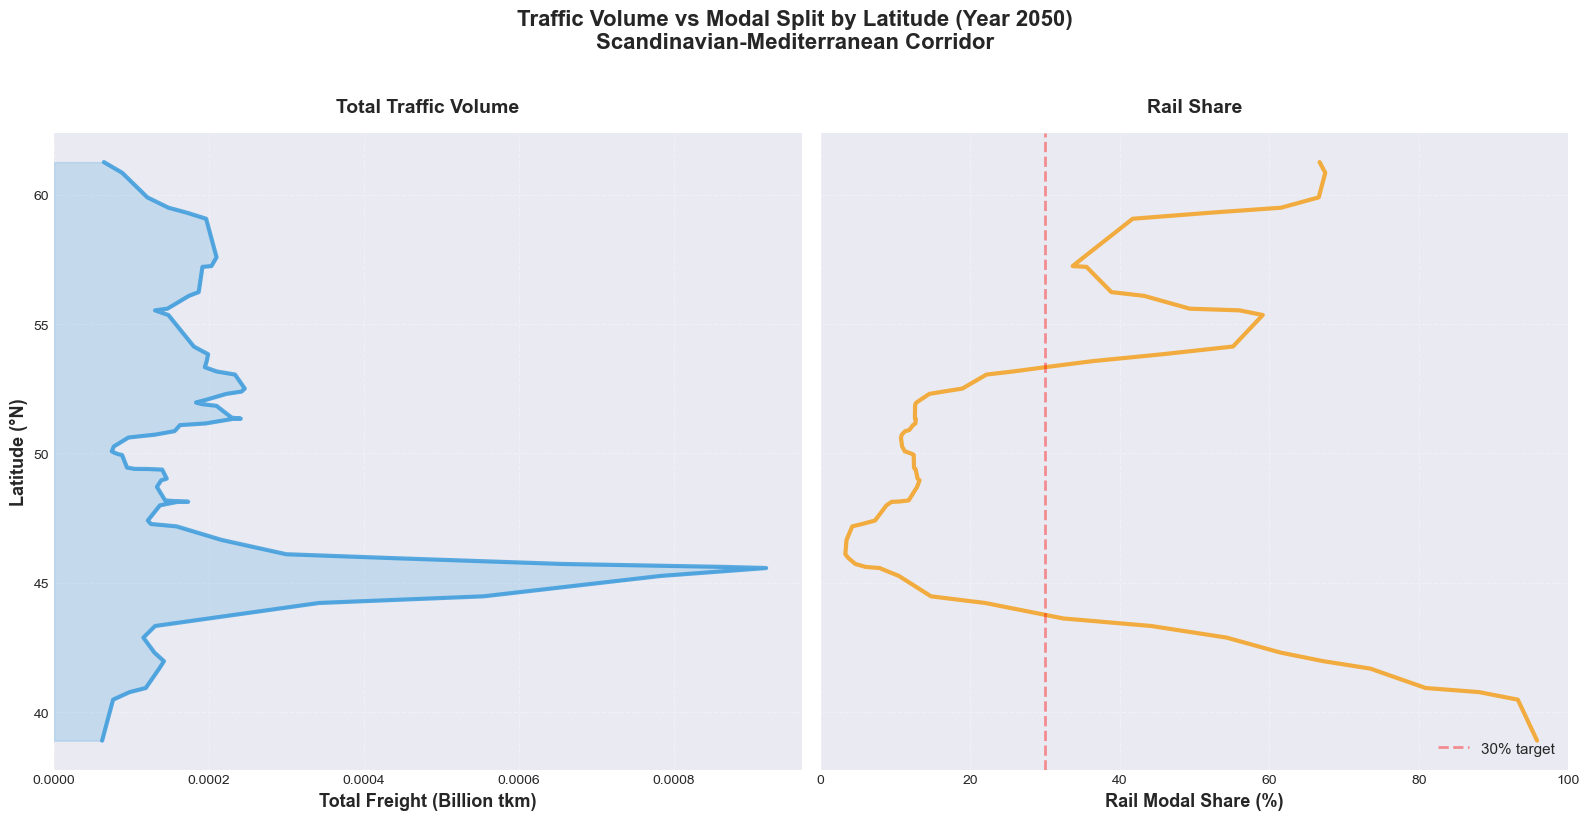

In [28]:
# ==============================================================================
# TOTAL TKM BY LATITUDE - CONTINUOUS LINE PLOT
# ==============================================================================
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d

def calculate_total_tkm_by_latitude(tkm_by_year_geo_mode):
    """
    Calculate total TKM for each NUTS2 region (road + rail combined).

    Returns:
        dict: {year: [(latitude, total_tkm), ...]} sorted by latitude
    """
    results = {}

    for year, geo_data in tkm_by_year_geo_mode.items():
        year_results = []

        for geo_id, data in geo_data.items():
            road_tkm = data['road']
            rail_tkm = data['rail']
            total_tkm = road_tkm + rail_tkm

            if total_tkm > 0:
                year_results.append((data['lat'], total_tkm))

        # Sort by latitude
        year_results.sort(key=lambda x: x[0])
        results[year] = year_results

    return results

# Calculate data (reuse the function from previous cell)
print("Calculating total TKM by latitude...")
total_tkm_by_lat = calculate_total_tkm_by_latitude(tkm_data_geo)

# Display summary
print("\n" + "="*80)
print("SUMMARY: TOTAL TKM BY LATITUDE")
print("="*80)
for year in [2030, 2040, 2050]:
    data = total_tkm_by_lat[year]
    print(f"\nYear {year}: {len(data)} NUTS2 regions with traffic")
    if data:
        lats = [x[0] for x in data]
        tkms = [x[1] for x in data]
        print(f"  Latitude range: {min(lats):.2f}° to {max(lats):.2f}°")
        print(f"  TKM range: {min(tkms)/1e9:.3f} to {max(tkms)/1e9:.3f} B tkm")
        print(f"  Total TKM: {sum(tkms)/1e9:.3f} B tkm")
        print(f"  Average per region: {np.mean(tkms)/1e9:.3f} B tkm")

# ==============================================================================
# PLOT: TOTAL TKM BY LATITUDE - THREE SUBPLOTS
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

years_to_plot = [2030, 2040, 2050]
colors = ['#3498DB', '#2ECC71', '#F39C12']

for idx, (ax, year, color) in enumerate(zip(axes, years_to_plot, colors)):
    data = total_tkm_by_lat[year]

    if not data:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        continue

    # Extract data
    latitudes = np.array([x[0] for x in data])
    total_tkms = np.array([x[1] for x in data]) / 1e9  # Convert to billions

    # Smooth the data for continuous line
    if len(latitudes) > 3:
        # Sort data by latitude to ensure smooth interpolation
        sort_idx = np.argsort(latitudes)
        lat_sorted = latitudes[sort_idx]
        tkm_sorted = total_tkms[sort_idx]

        # Apply Gaussian smoothing (sigma controls smoothness)
        tkm_smoothed = gaussian_filter1d(tkm_sorted, sigma=1.5)

        # Plot smoothed line
        ax.plot(tkm_smoothed, lat_sorted, color=color, linewidth=3, alpha=0.8)

        # Fill area under curve for visual emphasis
        ax.fill_betweenx(lat_sorted, 0, tkm_smoothed, color=color, alpha=0.2)

    else:
        # Not enough points for smoothing
        ax.plot(total_tkms, latitudes, color=color, linewidth=3, alpha=0.8)
        ax.fill_betweenx(latitudes, 0, total_tkms, color=color, alpha=0.2)

    # Formatting
    ax.set_xlabel('Total Freight (Billion tkm)', fontsize=13, fontweight='bold')
    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--')

    # Set x-axis limit to start at 0
    ax.set_xlim(left=0)

    # Add latitude labels on y-axis
    if idx == 0:
        ax.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')

# Overall title
fig.suptitle('Total Freight Volume by Latitude: Traffic Intensity Across NUTS2 Regions\nScandinavian-Mediterranean Corridor',
             fontsize=16, fontweight='bold', y=1.02)

# ==============================================================================
# ==============================================================================
# ADD COUNTRY LABELS ON Y-AXIS
# ==============================================================================

# Load country centroids
country_centroids = pd.read_csv('country_centroids.csv')

# Load country southern borders for dashed lines
borders_df = pd.read_csv('country_southern_borders.csv')
print(f'Loaded {len(country_centroids)} countries from CSV')

# Filter to countries in the corridor
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]
print(f'Corridor countries: {len(country_data)}')

# Add country labels to each subplot
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for idx, ax in enumerate(ax_list):
    ylim = ax.get_ylim()
    print(f'Subplot {idx}: y-range = {ylim[0]:.1f} to {ylim[1]:.1f}')
    
    # Add country labels
    for _, row in country_data.iterrows():
        country_code = row['CNTR_CODE']
        lat = row['centroid_lat']
        
        if ylim[0] <= lat <= ylim[1]:
            print(f'  Adding label: {country_code} at {lat:.1f}°N')
            ax.axhline(lat, color='gray', linestyle=':', alpha=0.3, linewidth=1.0, zorder=1)
            ax.text(1.03, lat, country_code, transform=ax.get_yaxis_transform(),
                   fontsize=11, fontweight='bold', va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='#666', alpha=0.9, linewidth=1.5),
                   zorder=10)

print('OK Country labels added to latitude plots')

# Add dashed lines for country southern borders
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'SE', 'NO']
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for ax in ax_list:
    ylim = ax.get_ylim()
    
    for _, row in borders_df.iterrows():
        country = row['CNTR_CODE']
        border_lat = row['southern_border_lat']
        
        if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
            ax.axhline(y=border_lat, color='gray', linestyle='--', 
                      linewidth=0.8, alpha=0.5, zorder=1)

plt.tight_layout()
plt.savefig('total_tkm_by_latitude.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved as 'total_tkm_by_latitude.png'")
plt.show()

# ==============================================================================
# DETAILED STATISTICS BY LATITUDE BAND
# ==============================================================================

def analyze_total_tkm_by_latitude_band(total_tkm_by_lat, year):
    """Group NUTS2 regions into latitude bands and calculate total TKM."""
    data = total_tkm_by_lat[year]

    # Define latitude bands (every 5 degrees)
    lat_min = min(x[0] for x in data)
    lat_max = max(x[0] for x in data)

    # Create bands
    bands = []
    current = int(lat_min / 5) * 5
    while current <= lat_max:
        bands.append((current, current + 5))
        current += 5

    print(f"\nYear {year} - Total TKM by Latitude Band:")
    print(f"{'Latitude Band':<20} {'# Regions':>12} {'Total TKM (B)':>15} {'Avg per Region (B)':>20}")
    print("-" * 72)

    for band_min, band_max in bands:
        # Filter data for this band
        band_data = [x for x in data if band_min <= x[0] < band_max]

        if band_data:
            n_regions = len(band_data)
            total_tkm = sum([x[1] for x in band_data])
            avg_tkm = total_tkm / n_regions

            print(f"{band_min:2d}°N - {band_max:2d}°N{' ':<7} {n_regions:12d} {total_tkm/1e9:14.3f} {avg_tkm/1e9:19.3f}")

print("\n" + "="*80)
print("TOTAL TKM BY LATITUDE BAND")
print("="*80)
for year in [2030, 2040, 2050]:
    analyze_total_tkm_by_latitude_band(total_tkm_by_lat, year)

# ==============================================================================
# BONUS: COMPARATIVE VISUALIZATION - TKM vs MODAL SPLIT SIDE-BY-SIDE
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

year_comparison = 2050  # Choose year for comparison

# Left plot: Total TKM
data_tkm = total_tkm_by_lat[year_comparison]
latitudes_tkm = np.array([x[0] for x in data_tkm])
tkms = np.array([x[1] for x in data_tkm]) / 1e9

if len(latitudes_tkm) > 3:
    sort_idx = np.argsort(latitudes_tkm)
    lat_sorted = latitudes_tkm[sort_idx]
    tkm_sorted = tkms[sort_idx]
    tkm_smoothed = gaussian_filter1d(tkm_sorted, sigma=1.5)

    axes[0].plot(tkm_smoothed, lat_sorted, color='#3498DB', linewidth=3, alpha=0.8)
    axes[0].fill_betweenx(lat_sorted, 0, tkm_smoothed, color='#3498DB', alpha=0.2)

axes[0].set_xlabel('Total Freight (Billion tkm)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')
axes[0].set_title('Total Traffic Volume', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(left=0)

# Right plot: Modal Split
data_split = modal_split_by_lat[year_comparison]
latitudes_split = np.array([x[0] for x in data_split])
rail_shares = np.array([x[1] for x in data_split])

if len(latitudes_split) > 3:
    sort_idx = np.argsort(latitudes_split)
    lat_sorted = latitudes_split[sort_idx]
    share_sorted = rail_shares[sort_idx]
    share_smoothed = gaussian_filter1d(share_sorted, sigma=1.5)

    axes[1].plot(share_smoothed, lat_sorted, color='#F39C12', linewidth=3, alpha=0.8)

axes[1].set_xlabel('Rail Modal Share (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Rail Share', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_xlim(0, 100)
axes[1].axvline(30, color='red', linestyle='--', alpha=0.4, linewidth=2, label='30% target')
axes[1].legend(fontsize=11, loc='lower right')

fig.suptitle(f'Traffic Volume vs Modal Split by Latitude (Year {year_comparison})\nScandinavian-Mediterranean Corridor',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(f'tkm_vs_modal_split_by_latitude_{year_comparison}.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved as 'tkm_vs_modal_split_by_latitude_{year_comparison}.png'")
plt.show()


Calculating TKM by mode and latitude...

SUMMARY: TKM BY MODE AND LATITUDE

Year 2030: 75 NUTS2 regions
  Total Road: 0.011 B tkm (94.1%)
  Total Rail: 0.001 B tkm (5.9%)
  Total: 0.012 B tkm

Year 2040: 75 NUTS2 regions
  Total Road: 0.012 B tkm (90.1%)
  Total Rail: 0.001 B tkm (9.9%)
  Total: 0.014 B tkm

Year 2050: 75 NUTS2 regions
  Total Road: 0.012 B tkm (79.9%)
  Total Rail: 0.003 B tkm (20.1%)
  Total: 0.015 B tkm
Loaded 6 countries from CSV
Corridor countries: 6
Subplot 0: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding label: NO at 60.3°N
  Adding label: SE at 57.9°N
Subplot 1: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label: DK at 56.0°N
  Adding label: IT at 43.5°N
  Adding label: NO at 60.3°N
  Adding label: SE at 57.9°N
Subplot 2: y-range = 37.8 to 62.4
  Adding label: AT at 47.5°N
  Adding label: DE at 50.9°N
  Adding label:

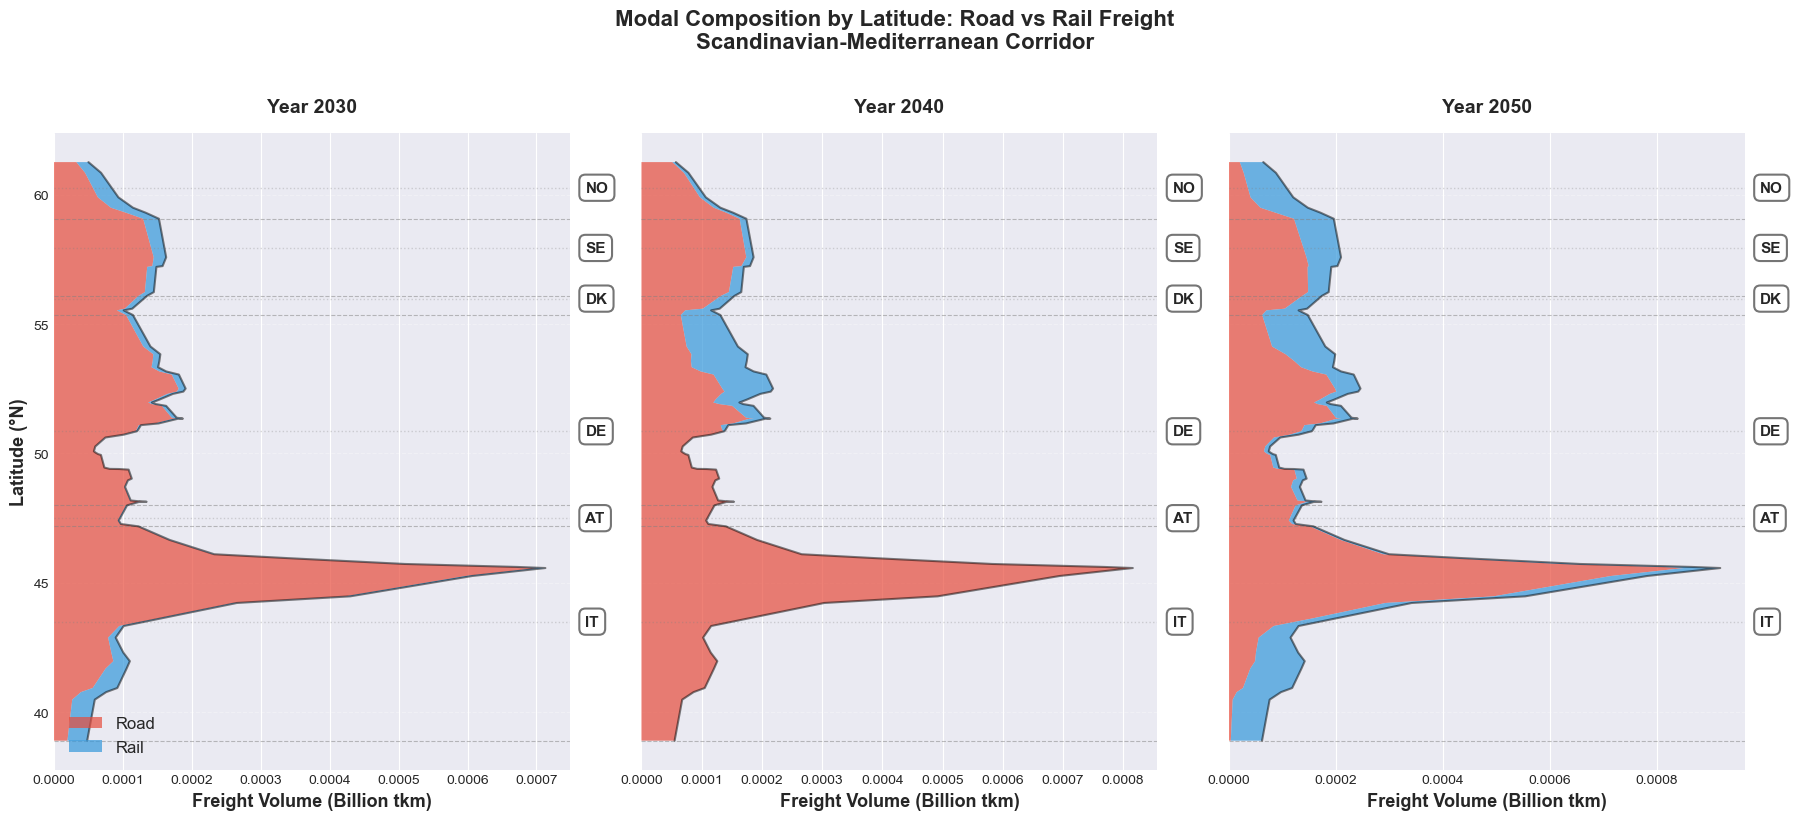


TKM BY MODE AND LATITUDE BAND

Year 2030 - TKM by Mode and Latitude Band:
Latitude Band           Road (B tkm)    Rail (B tkm)   Total (B tkm)     Rail %
--------------------------------------------------------------------------------
35°N - 40°N                 0.000          0.000          0.000      68.9%
40°N - 45°N                 0.001          0.000          0.001      15.3%
45°N - 50°N                 0.005          0.000          0.005       1.2%
50°N - 55°N                 0.003          0.000          0.004       4.2%
55°N - 60°N                 0.001          0.000          0.002      14.8%
60°N - 65°N                 0.000          0.000          0.000      39.2%

Year 2040 - TKM by Mode and Latitude Band:
Latitude Band           Road (B tkm)    Rail (B tkm)   Total (B tkm)     Rail %
--------------------------------------------------------------------------------
35°N - 40°N                 0.000          0.000          0.000       0.0%
40°N - 45°N                 0.002 

In [29]:
# ==============================================================================
# STACKED AREA PLOT: TKM BY MODE AND LATITUDE
# ==============================================================================
from scipy.ndimage import gaussian_filter1d

def calculate_tkm_by_mode_and_latitude(tkm_by_year_geo_mode):
    """
    Calculate TKM for each mode separately at each NUTS2 region.

    Returns:
        dict: {year: [(latitude, road_tkm, rail_tkm), ...]} sorted by latitude
    """
    results = {}

    for year, geo_data in tkm_by_year_geo_mode.items():
        year_results = []

        for geo_id, data in geo_data.items():
            road_tkm = data['road']
            rail_tkm = data['rail']
            lat = data['lat']

            if road_tkm + rail_tkm > 0:
                year_results.append((lat, road_tkm, rail_tkm))

        # Sort by latitude
        year_results.sort(key=lambda x: x[0])
        results[year] = year_results

    return results

# Calculate data (reuse tkm_data_geo from previous cells)
print("Calculating TKM by mode and latitude...")
tkm_by_mode_lat = calculate_tkm_by_mode_and_latitude(tkm_data_geo)

# Display summary
print("\n" + "="*80)
print("SUMMARY: TKM BY MODE AND LATITUDE")
print("="*80)
for year in [2030, 2040, 2050]:
    data = tkm_by_mode_lat[year]
    print(f"\nYear {year}: {len(data)} NUTS2 regions")
    if data:
        total_road = sum(x[1] for x in data)
        total_rail = sum(x[2] for x in data)
        total = total_road + total_rail
        print(f"  Total Road: {total_road/1e9:.3f} B tkm ({total_road/total*100:.1f}%)")
        print(f"  Total Rail: {total_rail/1e9:.3f} B tkm ({total_rail/total*100:.1f}%)")
        print(f"  Total: {total/1e9:.3f} B tkm")

# ==============================================================================
# PLOT: STACKED AREA BY LATITUDE - THREE SUBPLOTS
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

years_to_plot = [2030, 2040, 2050]
road_color = '#E74C3C'  # Red
rail_color = '#3498DB'  # Blue

for idx, (ax, year) in enumerate(zip(axes, years_to_plot)):
    data = tkm_by_mode_lat[year]

    if not data:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        continue

    # Extract data
    latitudes = np.array([x[0] for x in data])
    road_tkms = np.array([x[1] for x in data]) / 1e9  # Convert to billions
    rail_tkms = np.array([x[2] for x in data]) / 1e9

    # Smooth the data for continuous line
    if len(latitudes) > 3:
        # Sort data by latitude
        sort_idx = np.argsort(latitudes)
        lat_sorted = latitudes[sort_idx]
        road_sorted = road_tkms[sort_idx]
        rail_sorted = rail_tkms[sort_idx]

        # Apply Gaussian smoothing
        road_smoothed = gaussian_filter1d(road_sorted, sigma=1.5)
        rail_smoothed = gaussian_filter1d(rail_sorted, sigma=1.5)

        # Create stacked area plot
        # First layer: Road (from 0 to road_tkm)
        ax.fill_betweenx(lat_sorted, 0, road_smoothed,
                         color=road_color, alpha=0.7, label='Road', edgecolor='none')

        # Second layer: Rail (from road_tkm to road_tkm + rail_tkm)
        ax.fill_betweenx(lat_sorted, road_smoothed, road_smoothed + rail_smoothed,
                         color=rail_color, alpha=0.7, label='Rail', edgecolor='none')

        # Add outline for total
        total_smoothed = road_smoothed + rail_smoothed
        ax.plot(total_smoothed, lat_sorted, color='black', linewidth=1.5, alpha=0.5, linestyle='-')

    else:
        # Not enough points for smoothing
        ax.fill_betweenx(latitudes, 0, road_tkms, color=road_color, alpha=0.7, label='Road')
        ax.fill_betweenx(latitudes, road_tkms, road_tkms + rail_tkms, color=rail_color, alpha=0.7, label='Rail')
        ax.plot(road_tkms + rail_tkms, latitudes, color='black', linewidth=1.5, alpha=0.5)

    # Formatting
    ax.set_xlabel('Freight Volume (Billion tkm)', fontsize=13, fontweight='bold')
    ax.set_title(f'Year {year}', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_xlim(left=0)

    # Add legend only to first subplot
    if idx == 0:
        ax.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')
        ax.legend(loc='lower left', fontsize=12, framealpha=0.95)

# Overall title
fig.suptitle('Modal Composition by Latitude: Road vs Rail Freight\nScandinavian-Mediterranean Corridor',
             fontsize=16, fontweight='bold', y=1.02)

# ==============================================================================
# ADD COUNTRY LABELS ON Y-AXIS
# ==============================================================================

# Load country centroids
country_centroids = pd.read_csv('country_centroids.csv')

# Load country southern borders for dashed lines
borders_df = pd.read_csv('country_southern_borders.csv')
print(f'Loaded {len(country_centroids)} countries from CSV')

# Filter to countries in the corridor
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]
print(f'Corridor countries: {len(country_data)}')

# Add country labels to each subplot
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for idx, ax in enumerate(ax_list):
    ylim = ax.get_ylim()
    print(f'Subplot {idx}: y-range = {ylim[0]:.1f} to {ylim[1]:.1f}')

    # Add country labels
    for _, row in country_data.iterrows():
        country_code = row['CNTR_CODE']
        lat = row['centroid_lat']

        if ylim[0] <= lat <= ylim[1]:
            print(f'  Adding label: {country_code} at {lat:.1f}°N')
            ax.axhline(lat, color='gray', linestyle=':', alpha=0.3, linewidth=1.0, zorder=1)
            ax.text(1.03, lat, country_code, transform=ax.get_yaxis_transform(),
                   fontsize=11, fontweight='bold', va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='#666', alpha=0.9, linewidth=1.5),
                   zorder=10)

print('OK Country labels added to stacked area plot')


# Add dashed lines for country southern borders
corridor_countries = ['IT', 'AT', 'DE', 'DK', 'SE', 'NO']
if isinstance(axes, np.ndarray):
    ax_list = axes.flatten()
else:
    ax_list = [axes]

for ax in ax_list:
    ylim = ax.get_ylim()
    
    for _, row in borders_df.iterrows():
        country = row['CNTR_CODE']
        border_lat = row['southern_border_lat']
        
        if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
            ax.axhline(y=border_lat, color='gray', linestyle='--', 
                      linewidth=0.8, alpha=0.5, zorder=1)

plt.tight_layout()
plt.savefig('stacked_area_tkm_by_latitude.png', dpi=300, bbox_inches='tight')
print("\n✓ Stacked area plot saved as 'stacked_area_tkm_by_latitude.png'")
plt.show()

# ==============================================================================
# DETAILED STATISTICS BY LATITUDE BAND
# ==============================================================================

def analyze_stacked_by_latitude_band(tkm_by_mode_lat, year):
    """Group NUTS2 regions into latitude bands and show road/rail breakdown."""
    data = tkm_by_mode_lat[year]

    # Define latitude bands (every 5 degrees)
    lat_min = min(x[0] for x in data)
    lat_max = max(x[0] for x in data)

    # Create bands
    bands = []
    current = int(lat_min / 5) * 5
    while current <= lat_max:
        bands.append((current, current + 5))
        current += 5

    print(f"\nYear {year} - TKM by Mode and Latitude Band:")
    print(f"{'Latitude Band':<20} {'Road (B tkm)':>15} {'Rail (B tkm)':>15} {'Total (B tkm)':>15} {'Rail %':>10}")
    print("-" * 80)

    for band_min, band_max in bands:
        # Filter data for this band
        band_data = [x for x in data if band_min <= x[0] < band_max]

        if band_data:
            road_tkm = sum([x[1] for x in band_data])
            rail_tkm = sum([x[2] for x in band_data])
            total_tkm = road_tkm + rail_tkm
            rail_pct = (rail_tkm / total_tkm * 100) if total_tkm > 0 else 0

            print(f"{band_min:2d}°N - {band_max:2d}°N{' ':<7} {road_tkm/1e9:14.3f} {rail_tkm/1e9:14.3f} {total_tkm/1e9:14.3f} {rail_pct:9.1f}%")

print("\n" + "="*80)
print("TKM BY MODE AND LATITUDE BAND")
print("="*80)
for year in [2030, 2040, 2050]:
    analyze_stacked_by_latitude_band(tkm_by_mode_lat, year)


Calculating electricity consumption by latitude and infrastructure type...
Found 75 NUTS2 regions
Electricity fuel IDs: [0]
Electric fueling infrastructure types: {1: 'slow_charging_station', 2: 'fast_charging_station'}

Infrastructure types found: ['fast_charging_station', 'slow_charging_station']

SUMMARY: ELECTRICITY CONSUMPTION BY YEAR AND INFRASTRUCTURE TYPE

Year 2030:
  fast_charging_station              0.82 TWh ( 50.0%)
  slow_charging_station              0.82 TWh ( 50.0%)
  TOTAL                              1.65 TWh

Year 2040:
  fast_charging_station              1.81 TWh ( 50.0%)
  slow_charging_station              1.81 TWh ( 50.0%)
  TOTAL                              3.63 TWh

Year 2050:
  fast_charging_station              1.51 TWh ( 50.0%)
  slow_charging_station              1.51 TWh ( 50.0%)
  TOTAL                              3.03 TWh

✓ High-quality plot saved as 'electricity_consumption_by_latitude.png' (400 DPI)


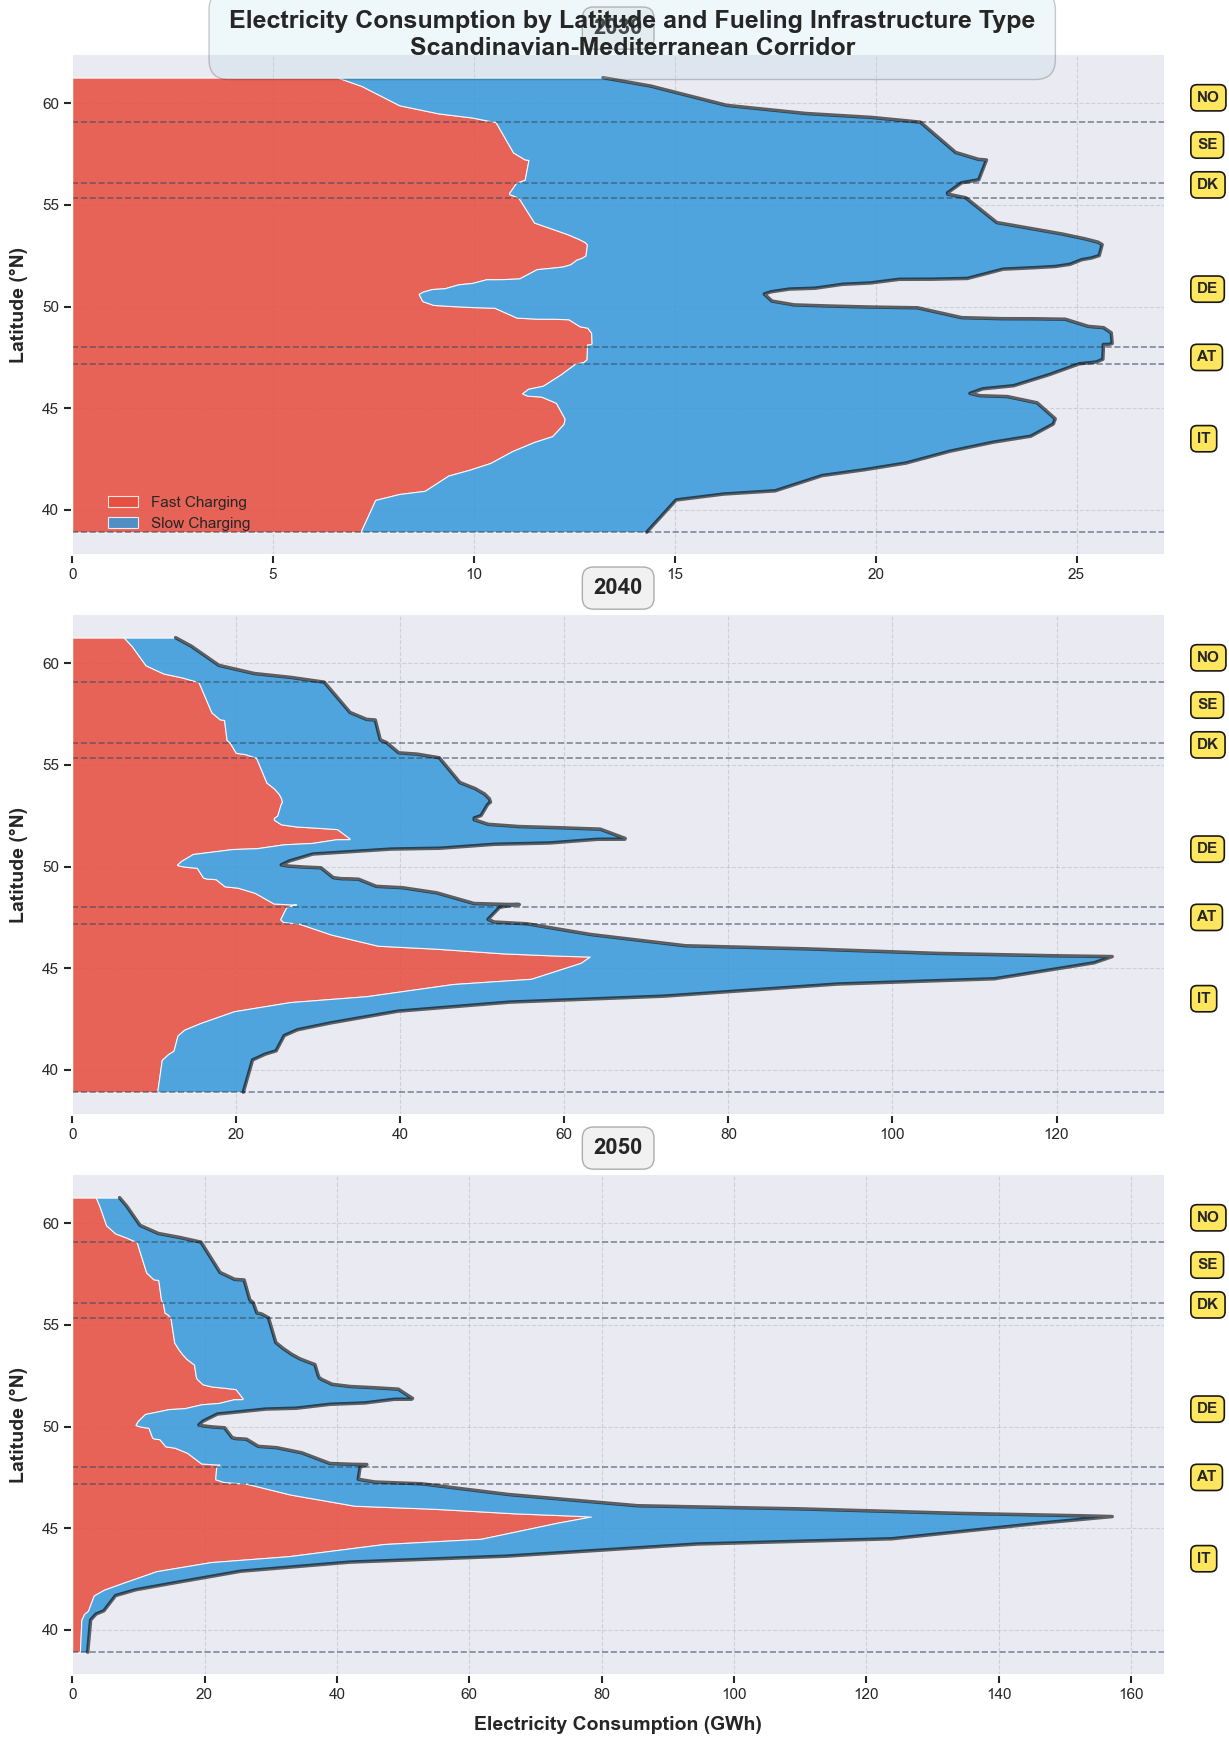


INTERPRETATION GUIDE: ELECTRICITY BY INFRASTRUCTURE TYPE

📊 WHAT THIS VISUALIZATION SHOWS:
   • Electricity consumption (GWh) for electric freight vehicles along the corridor
   • Breakdown by charging/fueling infrastructure type (color-coded)
   • Geographic distribution showing WHERE different charging technologies are deployed

⚡ INFRASTRUCTURE TYPES EXPLAINED:
   • Slow Charging (Blue): Depot/overnight charging (low power, long duration)
   • Fast Charging (Red): En-route quick charging stations (high power, short stops)
   • Opportunity Charging (Green): Brief top-ups during loading/unloading operations
   • Overhead Catenary (Orange): Electric road systems (e-highways with overhead wires)
   • Battery Swapping (Purple): Quick battery exchange stations

🔍 KEY INSIGHTS TO LOOK FOR:
   • Peaks indicate regions with high electric vehicle charging activity
   • Infrastructure mix reveals charging strategy preferences (depot vs en-route)
   • Temporal changes (2030→2040→2050) show inf

In [30]:
# ==============================================================================
# ELECTRICITY CONSUMPTION BY LATITUDE AND FUELING INFRASTRUCTURE TYPE
# ==============================================================================
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as mpatches

def calculate_electricity_by_latitude(case_study_name, target_years=[2030, 2040, 2050]):
    """
    Calculate electricity consumption (kWh) by NUTS2 region from the s variable.

    Filters for electric vehicles only and breaks down by fueling infrastructure type.

    s variable structure: (year, (product_id, odpair_id, path_id, geo_id), tech_id, (fuel_id, fueling_infra_id), generation)

    Returns:
        dict: {year: {nuts2_id: {infra_type: kWh, 'lat': X}}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    s_data = output_data["s"]

    # Load geographic elements and filter to NUTS2 nodes
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long']
            }

    print(f"Found {len(nuts2_lookup)} NUTS2 regions")

    # Load Fuel data to identify electricity
    fuels = input_data['Fuel']
    electricity_fuel_ids = []
    for fuel in fuels:
        if 'electricity' in fuel['name'].lower() or 'electric' in fuel['name'].lower():
            electricity_fuel_ids.append(fuel['id'])

    print(f"Electricity fuel IDs: {electricity_fuel_ids}")

    # Load FuelingInfrTypes to map infrastructure IDs to types
    fueling_infra_types = input_data.get('FuelingInfrTypes', [])
    infra_id_to_type = {}
    for infra in fueling_infra_types:
        # Only include electricity-based infrastructure
        if infra.get('fuel', '').lower() == 'electricity':
            infra_id_to_type[infra['id']] = infra['fueling_type']

    print(f"Electric fueling infrastructure types: {infra_id_to_type}")

    # Initialize: {year: {geo_id: {infra_name: kWh}}}
    data_by_year_geo = {year: {} for year in target_years}

    # SCALING FACTOR: s is scaled by 1000 in the model (multiply by 1000 to get kWh)
    SCALING_FACTOR = 1000

    # Process each energy consumption entry
    for key_str, energy_value_scaled in s_data.items():
        # Parse key structure: (year, (product_id, odpair_id, path_id, geo_id), tech_id, (fuel_id, fueling_infra_id), generation)
        key = eval(key_str) if isinstance(key_str, str) else key_str
        year, (product_id, odpair_id, path_id, geo_id), tech_id, (fuel_id, fueling_infra_id), generation = key

        if year not in target_years or energy_value_scaled <= 0:
            continue

        # Only process electricity
        if fuel_id not in electricity_fuel_ids:
            continue

        # Convert to kWh
        energy_kwh = energy_value_scaled * SCALING_FACTOR

        # Only process NUTS2 nodes
        if geo_id not in nuts2_lookup:
            continue

        # Get infrastructure type
        infra_type = infra_id_to_type.get(fueling_infra_id, f'infra_{fueling_infra_id}')

        # Initialize if needed
        if geo_id not in data_by_year_geo[year]:
            data_by_year_geo[year][geo_id] = {
                'lat': nuts2_lookup[geo_id]['lat'],
                'nuts2': nuts2_lookup[geo_id]['nuts2']
            }

        # Add energy consumption by infrastructure type
        if infra_type not in data_by_year_geo[year][geo_id]:
            data_by_year_geo[year][geo_id][infra_type] = 0.0

        data_by_year_geo[year][geo_id][infra_type] += energy_kwh

    return data_by_year_geo

# Calculate data
print("Calculating electricity consumption by latitude and infrastructure type...")
electricity_data = calculate_electricity_by_latitude(case_name, target_years=[2030, 2040, 2050])

# Get list of all infrastructure types across all years
all_infra_types = set()
for year_data in electricity_data.values():
    for geo_data in year_data.values():
        for key in geo_data.keys():
            if key not in ['lat', 'nuts2']:
                all_infra_types.add(key)

all_infra_types = sorted(all_infra_types)
print(f"\nInfrastructure types found: {all_infra_types}")

# Display summary
print("\n" + "="*80)
print("SUMMARY: ELECTRICITY CONSUMPTION BY YEAR AND INFRASTRUCTURE TYPE")
print("="*80)
for year in [2030, 2040, 2050]:
    data = electricity_data[year]

    # Aggregate by infrastructure type
    infra_totals = {}
    for geo_data in data.values():
        for infra_type in all_infra_types:
            if infra_type in geo_data:
                infra_totals[infra_type] = infra_totals.get(infra_type, 0) + geo_data[infra_type]

    total_kwh = sum(infra_totals.values())

    print(f"\nYear {year}:")
    if total_kwh > 0:
        for infra_type in all_infra_types:
            kwh = infra_totals.get(infra_type, 0)
            pct = 100 * kwh / total_kwh if total_kwh > 0 else 0
            print(f"  {infra_type:30} {kwh/1e9:>8.2f} TWh ({pct:>5.1f}%)")
        print(f"  {'TOTAL':30} {total_kwh/1e9:>8.2f} TWh")
    else:
        print("  No electricity consumption found")

# ==============================================================================
# BEAUTIFUL PLOT: ELECTRICITY CONSUMPTION BY LATITUDE
# ==============================================================================

if len(all_infra_types) == 0:
    print("\n⚠️  No electricity consumption data found. Skipping visualization.")
else:
    years_to_plot = [2030, 2040, 2050]

    # Enhanced color palette - vibrant, professional colors with good contrast
    infra_colors = {
        'slow_charging_station': '#3498DB',      # Vivid blue
        'fast_charging_station': '#E74C3C',      # Vivid red
        'opportunity_charging': '#2ECC71',       # Emerald green
        'overhead_catenary': '#F39C12',          # Orange
        'battery_swapping': '#9B59B6',           # Purple
        'conventional_fueling_station': '#95A5A6' # Gray (if present)
    }

    # Friendly display names for infrastructure types
    infra_display_names = {
        'slow_charging_station': 'Slow Charging',
        'fast_charging_station': 'Fast Charging',
        'opportunity_charging': 'Opportunity Charging',
        'overhead_catenary': 'Overhead Catenary',
        'battery_swapping': 'Battery Swapping',
        'conventional_fueling_station': 'Conventional Fueling'
    }

    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Create figure with enhanced proportions
    fig = plt.figure(figsize=(14, 18))
    gs = fig.add_gridspec(3, 1, hspace=0.12, top=0.96, bottom=0.06, left=0.10, right=0.88)
    axes = [fig.add_subplot(gs[i]) for i in range(3)]

    for year_idx, year in enumerate(years_to_plot):
        data = electricity_data[year]

        if not data:
            continue

        # Prepare data for plotting
        plotting_data = []
        for geo_id, metrics in data.items():
            lat = metrics['lat']

            # Get electricity by infrastructure type
            infra_kwh = {}
            for infra_type in all_infra_types:
                infra_kwh[infra_type] = metrics.get(infra_type, 0)

            total_kwh = sum(infra_kwh.values())

            if total_kwh > 0:
                plotting_data.append({
                    'lat': lat,
                    **infra_kwh
                })

        # Sort by latitude
        plotting_data.sort(key=lambda x: x['lat'])

        if len(plotting_data) < 2:
            continue

        # Extract arrays
        lats = np.array([d['lat'] for d in plotting_data])

        # Get data for each infrastructure type
        infra_arrays = {}
        for infra_type in all_infra_types:
            infra_arrays[infra_type] = np.array([d.get(infra_type, 0) for d in plotting_data])

        # Apply Gaussian smoothing with adaptive sigma
        sigma = 2.5  # Slightly increased for smoother curves
        infra_arrays_smooth = {}
        for infra_type, arr in infra_arrays.items():
            infra_arrays_smooth[infra_type] = gaussian_filter1d(arr, sigma=sigma)

        ax = axes[year_idx]

        # Convert to GWh for readability (1 GWh = 1,000,000 kWh)
        # Create stacked area plot with enhanced styling
        cumulative = np.zeros(len(lats))

        for infra_type in all_infra_types:
            arr_gwh = infra_arrays_smooth[infra_type] / 1e6
            color = infra_colors.get(infra_type, '#95A5A6')  # Default gray
            display_name = infra_display_names.get(infra_type, infra_type)

            ax.fill_betweenx(lats, cumulative, cumulative + arr_gwh,
                             color=color, alpha=0.85, label=display_name,
                             edgecolor='white', linewidth=0.8)
            cumulative += arr_gwh

        # Enhanced total outline
        ax.plot(cumulative, lats, 'k-', linewidth=2.5, alpha=0.6, zorder=10)

        # Enhanced styling
        ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold', labelpad=10)
        ax.set_title(f'{year}', fontsize=16, fontweight='bold', pad=15,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))

        # Enhanced grid
        ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.8, color='gray')
        ax.set_xlim(left=0)

        # Enhanced axis styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)

        # Tick styling
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)

        # Enhanced legend (only for first subplot)
        if year_idx == 0 and len(all_infra_types) > 0:
            legend = ax.legend(loc='lower left', fontsize=11, framealpha=0.95,
                             edgecolor='black', fancybox=True, shadow=True,
                             bbox_to_anchor=(0.02, 0.02))
            legend.get_frame().set_linewidth(1.5)

    # Enhanced common x-label
    axes[-1].set_xlabel('Electricity Consumption (GWh)', fontsize=14,
                       fontweight='bold', labelpad=10)

    # Enhanced overall title with better spacing
    fig.suptitle('Electricity Consumption by Latitude and Fueling Infrastructure Type\n' +
                'Scandinavian-Mediterranean Corridor',
                fontsize=18, fontweight='bold', y=0.985,
                bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.2))

    # ==============================================================================
    # ADD COUNTRY LABELS AND BORDERS WITH ENHANCED STYLING
    # ==============================================================================

    # Load country data
    country_centroids = pd.read_csv('country_centroids.csv')
    borders_df = pd.read_csv('country_southern_borders.csv')

    corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
    country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]

    for ax in axes:
        ylim = ax.get_ylim()

        # Enhanced country labels with better styling
        for _, row in country_data.iterrows():
            country_code = row['CNTR_CODE']
            lat = row['centroid_lat']

            if ylim[0] <= lat <= ylim[1]:
                ax.text(1.03, lat, country_code, transform=ax.get_yaxis_transform(),
                       fontsize=11, fontweight='bold', va='center', ha='left',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE44D',
                                edgecolor='black', linewidth=1.2, alpha=0.9))

        # Enhanced border lines
        for _, row in borders_df.iterrows():
            country = row['CNTR_CODE']
            border_lat = row['southern_border_lat']

            if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
                ax.axhline(y=border_lat, color='#34495E', linestyle='--',
                          linewidth=1.2, alpha=0.6, zorder=1)

    # Save with high quality
    plt.savefig('electricity_consumption_by_latitude.png', dpi=400,
                bbox_inches='tight', facecolor='white', edgecolor='none')
    print("\n✓ High-quality plot saved as 'electricity_consumption_by_latitude.png' (400 DPI)")
    plt.show()

# ==============================================================================
# ENHANCED INTERPRETATION GUIDE
# ==============================================================================

print("\n" + "="*80)
print("INTERPRETATION GUIDE: ELECTRICITY BY INFRASTRUCTURE TYPE")
print("="*80)
print("""
📊 WHAT THIS VISUALIZATION SHOWS:
   • Electricity consumption (GWh) for electric freight vehicles along the corridor
   • Breakdown by charging/fueling infrastructure type (color-coded)
   • Geographic distribution showing WHERE different charging technologies are deployed

⚡ INFRASTRUCTURE TYPES EXPLAINED:
   • Slow Charging (Blue): Depot/overnight charging (low power, long duration)
   • Fast Charging (Red): En-route quick charging stations (high power, short stops)
   • Opportunity Charging (Green): Brief top-ups during loading/unloading operations
   • Overhead Catenary (Orange): Electric road systems (e-highways with overhead wires)
   • Battery Swapping (Purple): Quick battery exchange stations

🔍 KEY INSIGHTS TO LOOK FOR:
   • Peaks indicate regions with high electric vehicle charging activity
   • Infrastructure mix reveals charging strategy preferences (depot vs en-route)
   • Temporal changes (2030→2040→2050) show infrastructure deployment evolution
   • Geographic patterns reveal corridor-specific electrification strategies

📈 CONTEXTUAL NOTES:
   • Only ELECTRIC vehicles shown (BEV, catenary trucks, etc.)
   • Does NOT include diesel, hydrogen, or other fuel types
   • Compare with total energy plots to assess electrification progress
   • Values include SCALING FACTOR of 1000 (model units × 1000 = kWh)

🎨 VISUAL FEATURES:
   • Gaussian smoothing (σ=2.5) for clearer trends
   • Country labels and borders for geographic reference
   • Stacked areas show cumulative consumption
   • Black outline indicates total electricity consumption envelope
""")

Calculating average distance to previous node by NUTS2 region...
Found 75 NUTS2 regions

SUMMARY: AVERAGE SEGMENT DISTANCES BY NUTS2 REGION

Total NUTS2 regions with data: 75
Overall average segment length: 1209.9 km
Median segment length: 1218.4 km
Min segment length: 397.3 km
Max segment length: 2068.5 km
Std deviation: 308.9 km

AVERAGE SEGMENT LENGTH BY COUNTRY
AT:  801.6 km (n= 4 regions, range: 397-1044 km)
DE: 1166.8 km (n=38 regions, range: 621-1396 km)
DK: 1140.3 km (n= 5 regions, range: 879-1406 km)
IT: 1326.2 km (n=19 regions, range: 604-2069 km)
NO: 1612.4 km (n= 4 regions, range: 1394-1860 km)
SE: 1169.8 km (n= 5 regions, range: 765-1722 km)

✓ High-quality plot saved as 'distance_by_latitude.png' (400 DPI)


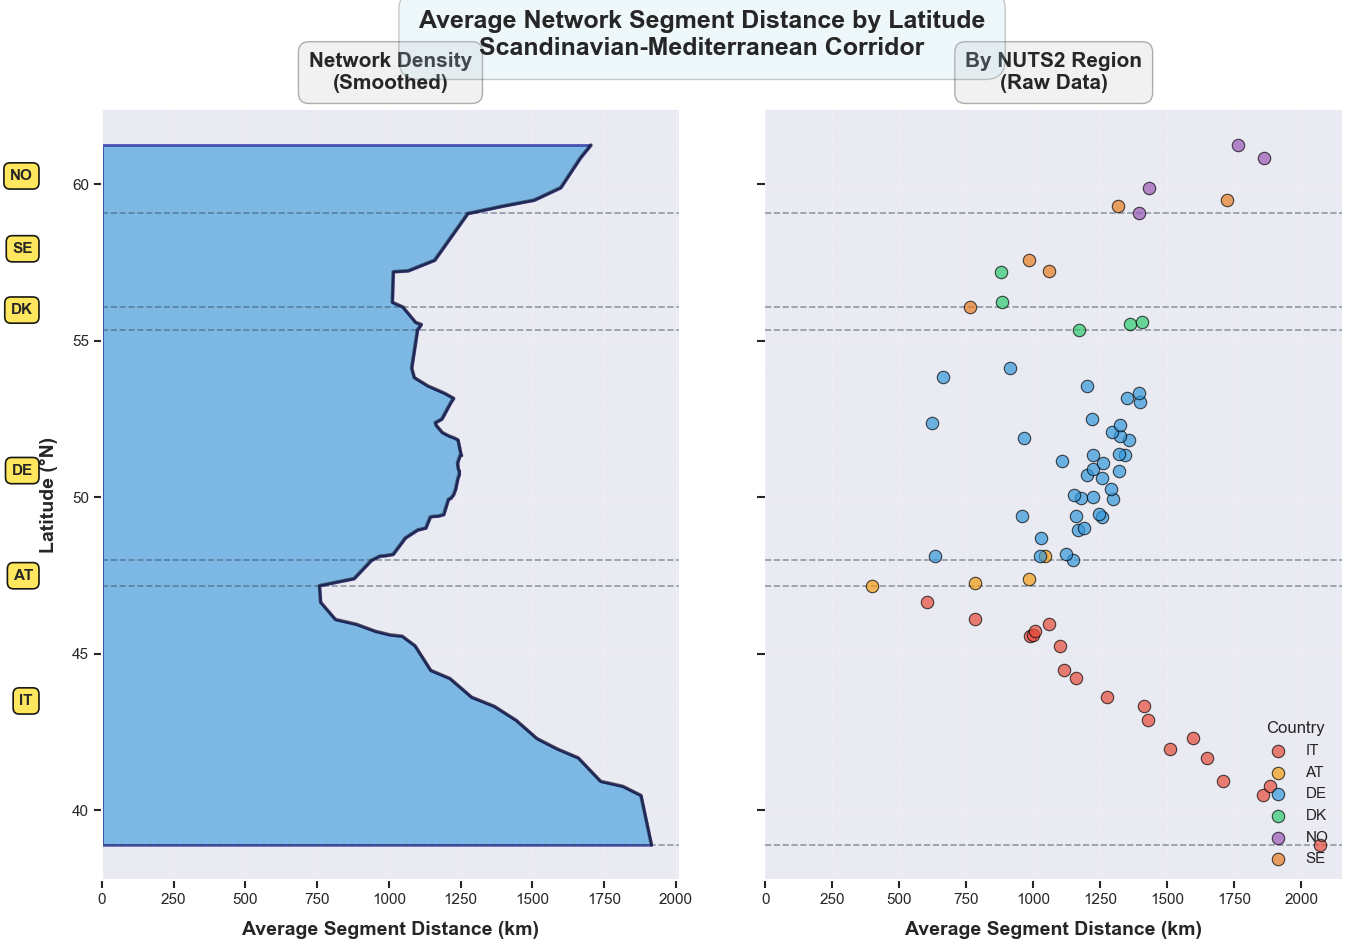


TOP 10 REGIONS WITH LONGEST AVERAGE SEGMENT DISTANCES
Rank   NUTS2    Country      Latitude    Avg Distance   # Segments
--------------------------------------------------------------------------------
1      ITF6     IT              38.90          2068.5 km           52
2      ITF4     IT              40.77          1881.5 km           52
3      NO0A     NO              60.85          1860.3 km           62
4      ITF5     IT              40.48          1857.3 km           52
5      NO02     NO              61.26          1761.9 km           62
6      SE11     SE              59.50          1721.8 km           66
7      ITF3     IT              40.93          1707.1 km           52
8      ITF2     IT              41.68          1646.4 km           52
9      ITF1     IT              42.30          1594.0 km           52
10     ITI4     IT              41.97          1510.2 km           52

TOP 10 REGIONS WITH SHORTEST AVERAGE SEGMENT DISTANCES
Rank   NUTS2    Country      Latitude    

In [31]:
# ==============================================================================
# AVERAGE DISTANCE TO PREVIOUS NODE BY LATITUDE
# ==============================================================================
from scipy.ndimage import gaussian_filter1d

def calculate_average_distance_by_nuts2(case_study_name):
    """
    Calculate the average distance_from_previous for each NUTS2 region.

    This shows the average segment length connecting to each region,
    which indicates network density and geographic spacing.

    Returns:
        dict: {nuts2_id: {'lat': X, 'avg_distance_km': Y, 'num_segments': N}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]

    # Load geographic elements and filter to NUTS2 nodes
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long'],
                'country': geo.get('country', 'UNKNOWN')
            }

    print(f"Found {len(nuts2_lookup)} NUTS2 regions")

    # Load all paths
    paths = input_data['Path']

    # For each NUTS2 region, collect all incoming distances
    nuts2_distances = {}

    for path in paths:
        sequence = path['sequence']
        distance_from_previous = path['distance_from_previous']

        # Process each node in the path
        for i, node_id in enumerate(sequence):
            if node_id in nuts2_lookup:
                nuts2_id = nuts2_lookup[node_id]['nuts2']
                distance_km = distance_from_previous[i]

                # Initialize if needed
                if nuts2_id not in nuts2_distances:
                    nuts2_distances[nuts2_id] = {
                        'lat': nuts2_lookup[node_id]['lat'],
                        'country': nuts2_lookup[node_id]['country'],
                        'distances': []
                    }

                # Add this distance (if non-zero)
                if distance_km > 0:
                    nuts2_distances[nuts2_id]['distances'].append(distance_km)

    # Calculate average distance for each NUTS2 region
    nuts2_avg_distances = {}
    for nuts2_id, data in nuts2_distances.items():
        if data['distances']:
            avg_dist = sum(data['distances']) / len(data['distances'])
            nuts2_avg_distances[nuts2_id] = {
                'lat': data['lat'],
                'country': data['country'],
                'avg_distance_km': avg_dist,
                'num_segments': len(data['distances']),
                'min_distance_km': min(data['distances']),
                'max_distance_km': max(data['distances'])
            }

    return nuts2_avg_distances

# Calculate data
print("Calculating average distance to previous node by NUTS2 region...")
distance_data = calculate_average_distance_by_nuts2(case_name)

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY: AVERAGE SEGMENT DISTANCES BY NUTS2 REGION")
print("="*80)

all_avg_distances = [d['avg_distance_km'] for d in distance_data.values()]
print(f"\nTotal NUTS2 regions with data: {len(distance_data)}")
print(f"Overall average segment length: {np.mean(all_avg_distances):.1f} km")
print(f"Median segment length: {np.median(all_avg_distances):.1f} km")
print(f"Min segment length: {np.min(all_avg_distances):.1f} km")
print(f"Max segment length: {np.max(all_avg_distances):.1f} km")
print(f"Std deviation: {np.std(all_avg_distances):.1f} km")

# Show by country
print("\n" + "="*80)
print("AVERAGE SEGMENT LENGTH BY COUNTRY")
print("="*80)

country_distances = {}
for nuts2_id, data in distance_data.items():
    country = data['country']
    if country not in country_distances:
        country_distances[country] = []
    country_distances[country].append(data['avg_distance_km'])

corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
for country in sorted(corridor_countries):
    if country in country_distances:
        dists = country_distances[country]
        print(f"{country}: {np.mean(dists):>6.1f} km (n={len(dists):>2} regions, "
              f"range: {np.min(dists):.0f}-{np.max(dists):.0f} km)")

# ==============================================================================
# BEAUTIFUL PLOT: AVERAGE DISTANCE BY LATITUDE
# ==============================================================================

# Prepare plotting data
plotting_data = []
for nuts2_id, metrics in distance_data.items():
    plotting_data.append({
        'nuts2': nuts2_id,
        'lat': metrics['lat'],
        'distance': metrics['avg_distance_km'],
        'num_segments': metrics['num_segments'],
        'country': metrics['country']
    })

# Sort by latitude
plotting_data.sort(key=lambda x: x['lat'])

# Extract arrays
lats = np.array([d['lat'] for d in plotting_data])
distances = np.array([d['distance'] for d in plotting_data])

# Apply Gaussian smoothing
sigma = 2.0
distances_smooth = gaussian_filter1d(distances, sigma=sigma)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10), sharey=True,
                                gridspec_kw={'wspace': 0.15})

# ==============================================================================
# LEFT PANEL: SMOOTHED CURVE
# ==============================================================================

# Fill area plot
ax1.fill_betweenx(lats, 0, distances_smooth,
                  color='#3498DB', alpha=0.6, edgecolor='darkblue', linewidth=2)

# Add outline
ax1.plot(distances_smooth, lats, 'k-', linewidth=2.5, alpha=0.5)

# Styling
ax1.set_xlabel('Average Segment Distance (km)', fontsize=14, fontweight='bold', labelpad=10)
ax1.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold', labelpad=10)
ax1.set_title('Network Density\n(Smoothed)', fontsize=15, fontweight='bold', pad=15,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))

ax1.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax1.set_xlim(left=0)

# Enhanced axis styling
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)

# ==============================================================================
# RIGHT PANEL: SCATTER PLOT (RAW DATA)
# ==============================================================================

# Color by country
country_colors = {
    'IT': '#E74C3C',  # Red
    'AT': '#F39C12',  # Orange
    'DE': '#3498DB',  # Blue
    'DK': '#2ECC71',  # Green
    'NO': '#9B59B6',  # Purple
    'SE': '#E67E22'   # Dark orange
}

for country in corridor_countries:
    country_data = [d for d in plotting_data if d['country'] == country]
    if country_data:
        country_lats = [d['lat'] for d in country_data]
        country_dists = [d['distance'] for d in country_data]

        ax2.scatter(country_dists, country_lats,
                   color=country_colors.get(country, '#95A5A6'),
                   s=80, alpha=0.7, edgecolor='black', linewidth=0.8,
                   label=country, zorder=5)

# Styling
ax2.set_xlabel('Average Segment Distance (km)', fontsize=14, fontweight='bold', labelpad=10)
ax2.set_title('By NUTS2 Region\n(Raw Data)', fontsize=15, fontweight='bold', pad=15,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))

ax2.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
ax2.set_xlim(left=0)

# Enhanced axis styling
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)

# Legend
legend = ax2.legend(loc='lower right', fontsize=11, framealpha=0.95,
                   edgecolor='black', fancybox=True, shadow=True,
                   title='Country', title_fontsize=12)
legend.get_frame().set_linewidth(1.5)

# ==============================================================================
# ADD COUNTRY LABELS AND BORDERS
# ==============================================================================

# Load country data
country_centroids = pd.read_csv('country_centroids.csv')
borders_df = pd.read_csv('country_southern_borders.csv')

corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]

for ax in [ax1, ax2]:
    ylim = ax.get_ylim()

    # Add country labels (only on left panel)
    if ax == ax1:
        for _, row in country_data.iterrows():
            country_code = row['CNTR_CODE']
            lat = row['centroid_lat']

            if ylim[0] <= lat <= ylim[1]:
                ax.text(-0.12, lat, country_code, transform=ax.get_yaxis_transform(),
                       fontsize=11, fontweight='bold', va='center', ha='right',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE44D',
                                edgecolor='black', linewidth=1.2, alpha=0.9))

    # Add border lines
    for _, row in borders_df.iterrows():
        country = row['CNTR_CODE']
        border_lat = row['southern_border_lat']

        if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
            ax.axhline(y=border_lat, color='#34495E', linestyle='--',
                      linewidth=1.2, alpha=0.5, zorder=1)

# Overall title
fig.suptitle('Average Network Segment Distance by Latitude\n' +
            'Scandinavian-Mediterranean Corridor',
            fontsize=18, fontweight='bold', y=0.98,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.2))

# Save with high quality
plt.savefig('distance_by_latitude.png', dpi=400,
            bbox_inches='tight', facecolor='white', edgecolor='none')
print("\n✓ High-quality plot saved as 'distance_by_latitude.png' (400 DPI)")
plt.show()

# ==============================================================================
# ADDITIONAL ANALYSIS: TOP/BOTTOM REGIONS
# ==============================================================================

print("\n" + "="*80)
print("TOP 10 REGIONS WITH LONGEST AVERAGE SEGMENT DISTANCES")
print("="*80)

sorted_by_distance = sorted(plotting_data, key=lambda x: x['distance'], reverse=True)

print(f"{'Rank':<6} {'NUTS2':<8} {'Country':<10} {'Latitude':>10} {'Avg Distance':>15} {'# Segments':>12}")
print("-" * 80)

for i, d in enumerate(sorted_by_distance[:10], 1):
    print(f"{i:<6} {d['nuts2']:<8} {d['country']:<10} {d['lat']:>10.2f} {d['distance']:>15.1f} km {d['num_segments']:>12}")

print("\n" + "="*80)
print("TOP 10 REGIONS WITH SHORTEST AVERAGE SEGMENT DISTANCES")
print("="*80)

print(f"{'Rank':<6} {'NUTS2':<8} {'Country':<10} {'Latitude':>10} {'Avg Distance':>15} {'# Segments':>12}")
print("-" * 80)

for i, d in enumerate(sorted_by_distance[-10:][::-1], 1):
    print(f"{i:<6} {d['nuts2']:<8} {d['country']:<10} {d['lat']:>10.2f} {d['distance']:>15.1f} km {d['num_segments']:>12}")

# ==============================================================================
# INTERPRETATION GUIDE
# ==============================================================================

print("\n" + "="*80)
print("INTERPRETATION GUIDE: NETWORK SEGMENT DISTANCES")
print("="*80)
print("""
📏 WHAT THIS SHOWS:
   • Average distance between consecutive nodes in paths passing through each NUTS2 region
   • Indicates network density: shorter distances = denser network
   • Based on all path sequences in the model, not flow-weighted

🔍 KEY INSIGHTS:
   • HIGH values (long distances):
     - Sparse network coverage
     - Regions serving as waypoints between distant areas
     - Potentially lower infrastructure density

   • LOW values (short distances):
     - Dense network coverage
     - Many nearby connection points
     - Potentially high infrastructure density
     - Urban/metropolitan regions

📊 COMPARISON:
   • Left panel: Smoothed trend showing geographic patterns
   • Right panel: Raw data colored by country

🌍 GEOGRAPHIC PATTERNS:
   • Northern regions (NO, SE, DK): May have longer distances due to geography
   • Central regions (DE, AT): Typically denser networks
   • Southern regions (IT): Varies by region (Alps vs plains)

⚠️  IMPORTANT NOTES:
   • This is NOT flow-weighted (doesn't account for traffic volume)
   • Represents network topology, not actual freight patterns
   • Based on distance_from_previous array in Path data structure
   • Zero distances (self-loops) are excluded from averages
""")


CALCULATING NORMALIZED FREIGHT DENSITY
Calculating average segment distances...
Calculated average distances for 75 NUTS2 regions
Calculating tonnes by region...
Normalizing by average segment distance...

SUMMARY: NORMALIZED FREIGHT DENSITY BY YEAR

Year 2030:
  Raw Tonnes:
    Road: 0.03 Mt  |  Rail: 0.00 Mt  |  Total: 0.03 Mt
  Normalized (tonnes/km of network):
    Road: 0.03 Mt/km  |  Rail: 0.00 Mt/km  |  Total: 0.03 Mt/km

Year 2040:
  Raw Tonnes:
    Road: 0.03 Mt  |  Rail: 0.00 Mt  |  Total: 0.03 Mt
  Normalized (tonnes/km of network):
    Road: 0.03 Mt/km  |  Rail: 0.00 Mt/km  |  Total: 0.03 Mt/km

Year 2050:
  Raw Tonnes:
    Road: 0.03 Mt  |  Rail: 0.00 Mt  |  Total: 0.04 Mt
  Normalized (tonnes/km of network):
    Road: 0.04 Mt/km  |  Rail: 0.00 Mt/km  |  Total: 0.04 Mt/km

✓ High-quality plot saved as 'tonnes_normalized_by_distance.png' (400 DPI)


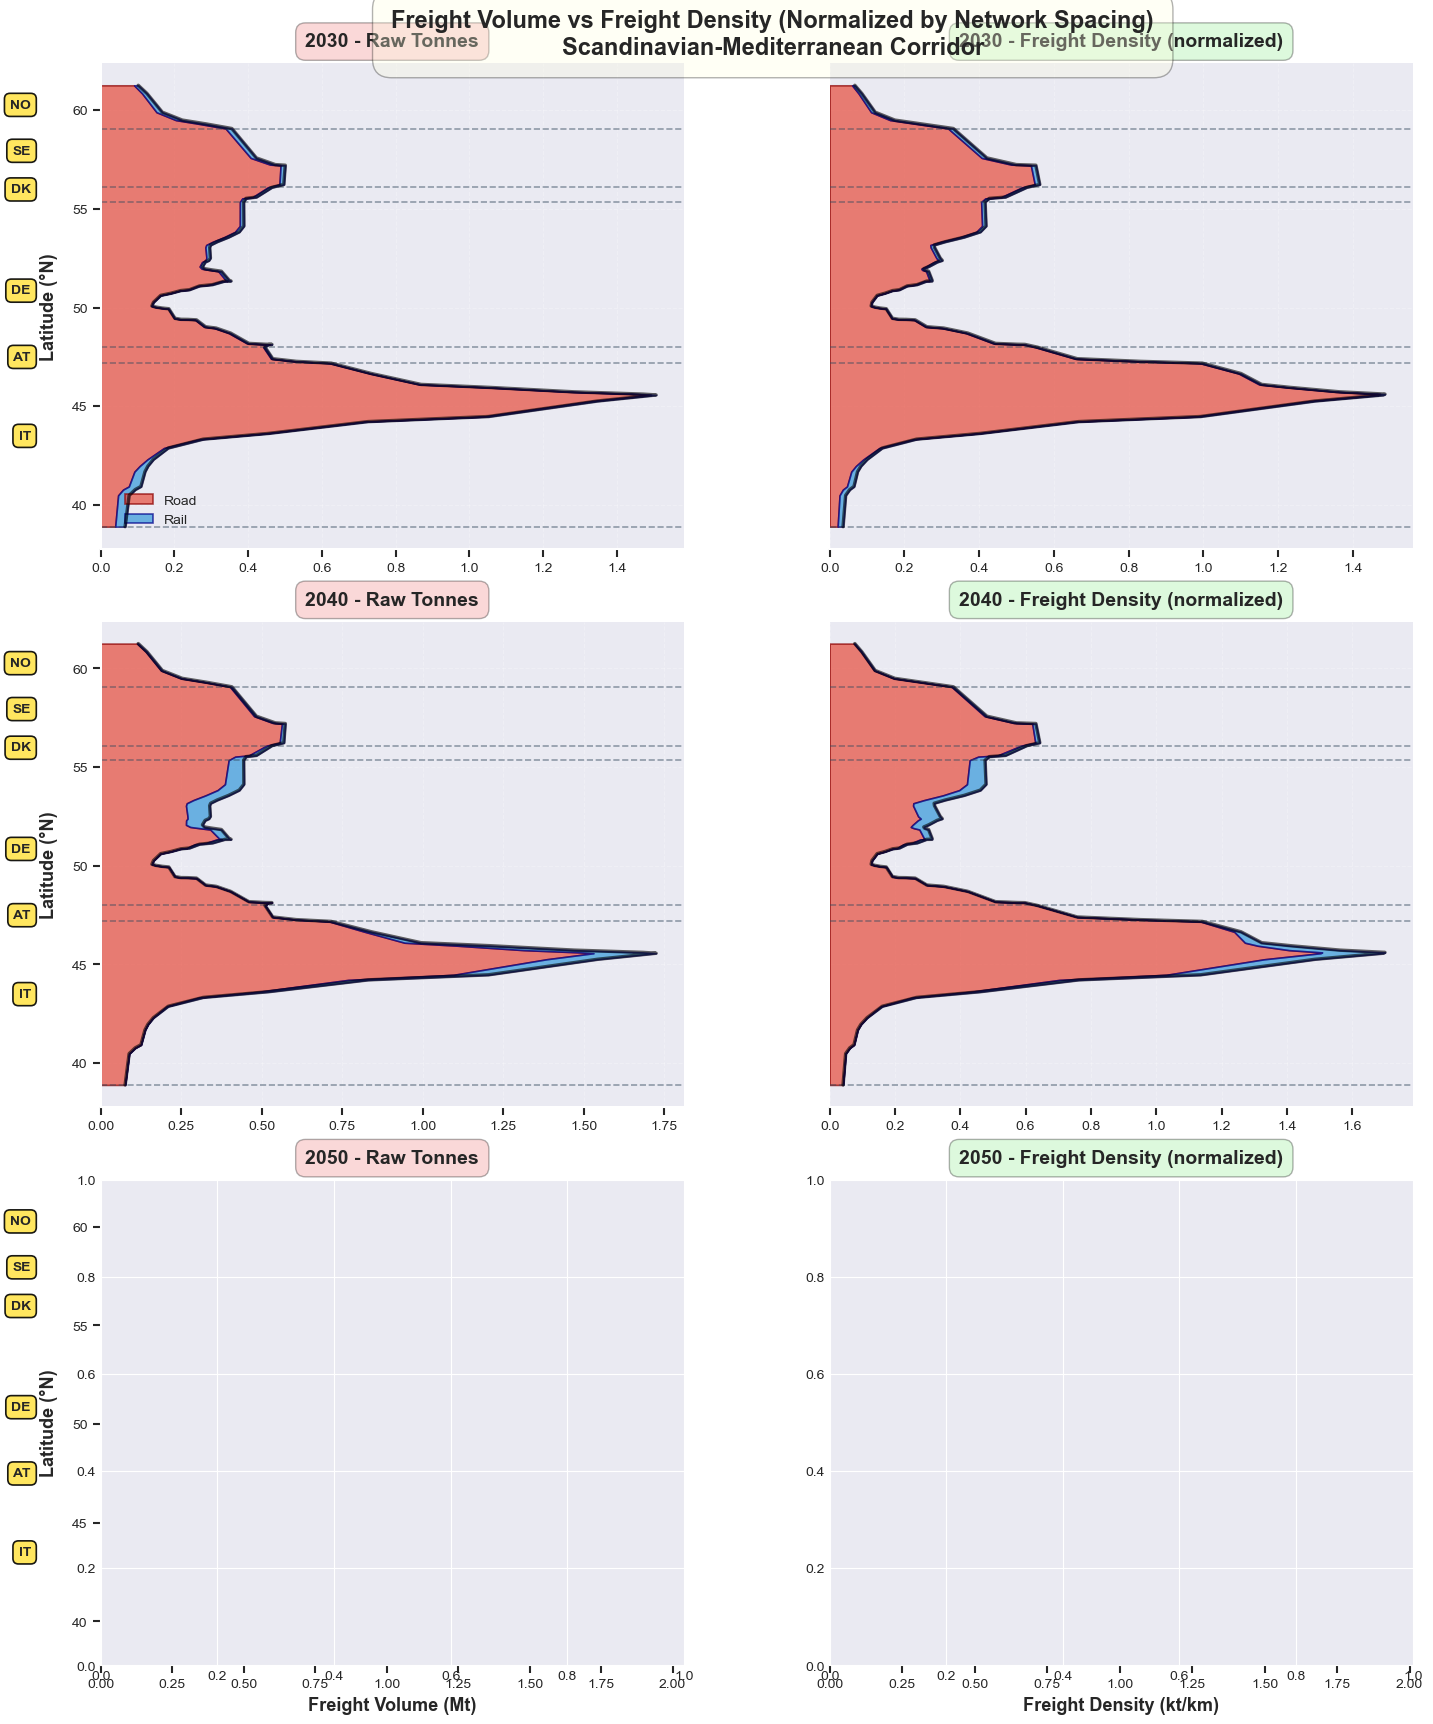


TOP 10 REGIONS BY NORMALIZED FREIGHT DENSITY (2030)
Rank   NUTS2    Country       Raw Tonnes       Tonnes/km     Avg Dist
--------------------------------------------------------------------------------
1      ITC4     IT                 3.32 Mt           3.32 kt/km       998.8 km
2      ITH3     IT                 2.08 Mt           2.10 kt/km       987.8 km
3      AT33     AT                 0.74 Mt           1.87 kt/km       397.3 km
4      ITH1     IT                 0.99 Mt           1.64 kt/km       603.8 km
5      ITC1     IT                 1.45 Mt           1.32 kt/km      1100.6 km
6      SE22     SE                 0.86 Mt           1.13 kt/km       765.5 km
7      ITH5     IT                 1.24 Mt           1.11 kt/km      1115.0 km
8      DE21     DE                 0.62 Mt           0.98 kt/km       632.7 km
9      ITH2     IT                 0.72 Mt           0.92 kt/km       784.0 km
10     AT31     AT                 0.93 Mt           0.89 kt/km      1043.6 km

INTER

In [32]:
# ==============================================================================
# TONNES BY LATITUDE NORMALIZED BY AVERAGE SEGMENT DISTANCE
# ==============================================================================
from scipy.ndimage import gaussian_filter1d

def calculate_tonnes_normalized_by_distance(case_study_name, target_years=[2030, 2040, 2050]):
    """
    Calculate freight tonnes normalized by average segment distance for each NUTS2 region.

    This metric shows "freight density per kilometer" - regions with high values have
    concentrated freight traffic relative to their network spacing.

    Returns:
        dict: {year: {nuts2_id: {'road_tonnes': X, 'rail_tonnes': Y, 'avg_distance_km': Z, ...}}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]

    # Load geographic elements
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long'],
                'country': geo.get('country', 'UNKNOWN')
            }

    # Load paths and odpairs
    paths = input_data['Path']
    odpairs = input_data['Odpair']

    path_lookup = {}
    for path in paths:
        path_lookup[path['id']] = {
            'sequence': path['sequence'],
            'distance_from_previous': path['distance_from_previous']
        }

    od_lookup = {}
    for od in odpairs:
        od_lookup[od['id']] = {
            'origin': od['from'],
            'destination': od['to']
        }

    # First pass: Calculate average distance for each NUTS2 region
    print("Calculating average segment distances...")
    nuts2_distances = {}

    for path in paths:
        sequence = path['sequence']
        distance_from_previous = path['distance_from_previous']

        for i, node_id in enumerate(sequence):
            if node_id in nuts2_lookup:
                nuts2_id = nuts2_lookup[node_id]['nuts2']
                distance_km = distance_from_previous[i]

                if nuts2_id not in nuts2_distances:
                    nuts2_distances[nuts2_id] = []

                if distance_km > 0:
                    nuts2_distances[nuts2_id].append(distance_km)

    # Calculate average for each region
    nuts2_avg_distance = {}
    for nuts2_id, distances in nuts2_distances.items():
        if distances:
            nuts2_avg_distance[nuts2_id] = sum(distances) / len(distances)
        else:
            nuts2_avg_distance[nuts2_id] = 1.0  # Avoid division by zero

    print(f"Calculated average distances for {len(nuts2_avg_distance)} NUTS2 regions")

    # Second pass: Calculate tonnes by region
    print("Calculating tonnes by region...")
    data_by_year_nuts2 = {year: {} for year in target_years}

    SCALING_FACTOR = 1000  # f is in kilotonnes

    for key_str, flow_value_kt in f_data.items():
        key = eval(key_str) if isinstance(key_str, str) else key_str
        year, (product_id, odpair_id, path_id), (mode_id, techvehicle_id), generation = key

        if year not in target_years or flow_value_kt <= 0:
            continue

        if path_id not in path_lookup or odpair_id not in od_lookup:
            continue

        flow_value_tonnes = flow_value_kt * SCALING_FACTOR
        path_info = path_lookup[path_id]
        mode_name = 'rail' if mode_id == 2 else 'road'

        # Add tonnes to each NUTS2 region in the path
        for node_id in path_info['sequence']:
            if node_id in nuts2_lookup:
                nuts2_id = nuts2_lookup[node_id]['nuts2']

                if nuts2_id not in data_by_year_nuts2[year]:
                    data_by_year_nuts2[year][nuts2_id] = {
                        'road_tonnes': 0.0,
                        'rail_tonnes': 0.0,
                        'lat': nuts2_lookup[node_id]['lat'],
                        'country': nuts2_lookup[node_id]['country'],
                        'avg_distance_km': nuts2_avg_distance.get(nuts2_id, 1.0)
                    }

                data_by_year_nuts2[year][nuts2_id][f'{mode_name}_tonnes'] += flow_value_tonnes

    # Third pass: Normalize by average distance
    print("Normalizing by average segment distance...")
    for year in target_years:
        for nuts2_id, data in data_by_year_nuts2[year].items():
            avg_dist = data['avg_distance_km']

            # Calculate normalized values (tonnes per km)
            data['road_tonnes_per_km'] = data['road_tonnes'] / avg_dist
            data['rail_tonnes_per_km'] = data['rail_tonnes'] / avg_dist
            data['total_tonnes'] = data['road_tonnes'] + data['rail_tonnes']
            data['total_tonnes_per_km'] = data['total_tonnes'] / avg_dist

    return data_by_year_nuts2

# Calculate data
print("="*80)
print("CALCULATING NORMALIZED FREIGHT DENSITY")
print("="*80)
normalized_data = calculate_tonnes_normalized_by_distance(case_name, target_years=[2030, 2040, 2050])

# Display summary
print("\n" + "="*80)
print("SUMMARY: NORMALIZED FREIGHT DENSITY BY YEAR")
print("="*80)

for year in [2030, 2040, 2050]:
    data = normalized_data[year]

    total_road_tonnes = sum(d['road_tonnes'] for d in data.values())
    total_rail_tonnes = sum(d['rail_tonnes'] for d in data.values())
    total_tonnes = total_road_tonnes + total_rail_tonnes

    # Also calculate normalized totals
    total_road_normalized = sum(d['road_tonnes_per_km'] for d in data.values())
    total_rail_normalized = sum(d['rail_tonnes_per_km'] for d in data.values())
    total_normalized = total_road_normalized + total_rail_normalized

    print(f"\nYear {year}:")
    print(f"  Raw Tonnes:")
    print(f"    Road: {total_road_tonnes/1e9:.2f} Mt  |  Rail: {total_rail_tonnes/1e9:.2f} Mt  |  Total: {total_tonnes/1e9:.2f} Mt")
    print(f"  Normalized (tonnes/km of network):")
    print(f"    Road: {total_road_normalized/1e6:.2f} Mt/km  |  Rail: {total_rail_normalized/1e6:.2f} Mt/km  |  Total: {total_normalized/1e6:.2f} Mt/km")

# ==============================================================================
# BEAUTIFUL PLOT: NORMALIZED FREIGHT DENSITY BY LATITUDE
# ==============================================================================

years_to_plot = [2030, 2040, 2050]

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure: 3 rows × 2 columns (left=raw, right=normalized)
fig = plt.figure(figsize=(16, 18))
gs = fig.add_gridspec(3, 2, hspace=0.15, wspace=0.25,
                      top=0.95, bottom=0.06, left=0.08, right=0.90)

for year_idx, year in enumerate(years_to_plot):
    data = normalized_data[year]

    if not data:
        continue

    # Prepare plotting data
    plotting_data = []
    for nuts2_id, metrics in data.items():
        plotting_data.append({
            'nuts2': nuts2_id,
            'lat': metrics['lat'],
            'country': metrics['country'],
            'road_tonnes': metrics['road_tonnes'],
            'rail_tonnes': metrics['rail_tonnes'],
            'road_tonnes_per_km': metrics['road_tonnes_per_km'],
            'rail_tonnes_per_km': metrics['rail_tonnes_per_km'],
            'avg_distance_km': metrics['avg_distance_km']
        })

    # Sort by latitude
    plotting_data.sort(key=lambda x: x['lat'])

    if len(plotting_data) < 2:
        continue

    # Extract arrays
    lats = np.array([d['lat'] for d in plotting_data])

    # RAW DATA
    road_tonnes = np.array([d['road_tonnes'] for d in plotting_data])
    rail_tonnes = np.array([d['rail_tonnes'] for d in plotting_data])

    # NORMALIZED DATA
    road_tonnes_norm = np.array([d['road_tonnes_per_km'] for d in plotting_data])
    rail_tonnes_norm = np.array([d['rail_tonnes_per_km'] for d in plotting_data])

    # Apply Gaussian smoothing
    sigma = 2.0
    road_smooth = gaussian_filter1d(road_tonnes, sigma=sigma)
    rail_smooth = gaussian_filter1d(rail_tonnes, sigma=sigma)
    road_norm_smooth = gaussian_filter1d(road_tonnes_norm, sigma=sigma)
    rail_norm_smooth = gaussian_filter1d(rail_tonnes_norm, sigma=sigma)

    # ==============================================================================
    # LEFT COLUMN: RAW TONNES
    # ==============================================================================

    ax_raw = fig.add_subplot(gs[year_idx, 0])

    # Convert to million tonnes for readability
    road_mt = road_smooth / 1e6
    rail_mt = rail_smooth / 1e6

    # Stacked area plot
    ax_raw.fill_betweenx(lats, 0, road_mt,
                         color='#E74C3C', alpha=0.7, label='Road',
                         edgecolor='darkred', linewidth=1.2)
    ax_raw.fill_betweenx(lats, road_mt, road_mt + rail_mt,
                         color='#3498DB', alpha=0.7, label='Rail',
                         edgecolor='darkblue', linewidth=1.2)

    # Total outline
    total_mt = road_mt + rail_mt
    ax_raw.plot(total_mt, lats, 'k-', linewidth=2.5, alpha=0.6, zorder=10)

    # Styling
    ax_raw.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold', labelpad=10)
    ax_raw.set_title(f'{year} - Raw Tonnes', fontsize=14, fontweight='bold', pad=12,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.3))

    ax_raw.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
    ax_raw.set_xlim(left=0)

    # Enhanced axis styling
    ax_raw.spines['top'].set_visible(False)
    ax_raw.spines['right'].set_visible(False)
    ax_raw.spines['left'].set_linewidth(1.5)
    ax_raw.spines['bottom'].set_linewidth(1.5)
    ax_raw.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)

    if year_idx == 0:
        legend = ax_raw.legend(loc='lower left', fontsize=10, framealpha=0.95,
                              edgecolor='black', fancybox=True, shadow=True,
                              bbox_to_anchor=(0.02, 0.02))
        legend.get_frame().set_linewidth(1.5)

    # ==============================================================================
    # RIGHT COLUMN: NORMALIZED (TONNES PER KM)
    # ==============================================================================

    ax_norm = fig.add_subplot(gs[year_idx, 1])

    # Convert to kilotonnes per km for readability
    road_kt_per_km = road_norm_smooth / 1e3
    rail_kt_per_km = rail_norm_smooth / 1e3

    # Stacked area plot
    ax_norm.fill_betweenx(lats, 0, road_kt_per_km,
                          color='#E74C3C', alpha=0.7, label='Road',
                          edgecolor='darkred', linewidth=1.2)
    ax_norm.fill_betweenx(lats, road_kt_per_km, road_kt_per_km + rail_kt_per_km,
                          color='#3498DB', alpha=0.7, label='Rail',
                          edgecolor='darkblue', linewidth=1.2)

    # Total outline
    total_kt_per_km = road_kt_per_km + rail_kt_per_km
    ax_norm.plot(total_kt_per_km, lats, 'k-', linewidth=2.5, alpha=0.6, zorder=10)

    # Styling
    ax_norm.set_title(f'{year} - Freight Density (normalized)', fontsize=14, fontweight='bold', pad=12,
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))

    ax_norm.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
    ax_norm.set_xlim(left=0)

    # Enhanced axis styling
    ax_norm.spines['top'].set_visible(False)
    ax_norm.spines['right'].set_visible(False)
    ax_norm.spines['left'].set_visible(False)
    ax_norm.spines['bottom'].set_linewidth(1.5)
    ax_norm.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)
    ax_norm.tick_params(axis='y', left=False, labelleft=False)

    # ==============================================================================
    # ADD COUNTRY LABELS AND BORDERS
    # ==============================================================================

    # Load country data
    country_centroids = pd.read_csv('country_centroids.csv')
    borders_df = pd.read_csv('country_southern_borders.csv')

    corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
    country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]

    for ax in [ax_raw, ax_norm]:
        ylim = ax.get_ylim()

        # Add country labels (only on left panel)
        if ax == ax_raw:
            for _, row in country_data.iterrows():
                country_code = row['CNTR_CODE']
                lat = row['centroid_lat']

                if ylim[0] <= lat <= ylim[1]:
                    ax.text(-0.12, lat, country_code, transform=ax.get_yaxis_transform(),
                           fontsize=10, fontweight='bold', va='center', ha='right',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE44D',
                                    edgecolor='black', linewidth=1.2, alpha=0.9))

        # Add border lines
        for _, row in borders_df.iterrows():
            country = row['CNTR_CODE']
            border_lat = row['southern_border_lat']

            if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
                ax.axhline(y=border_lat, color='#34495E', linestyle='--',
                          linewidth=1.2, alpha=0.5, zorder=1)

# X-axis labels
axes_bottom = [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])]
axes_bottom[0].set_xlabel('Freight Volume (Mt)', fontsize=13, fontweight='bold', labelpad=10)
axes_bottom[1].set_xlabel('Freight Density (kt/km)', fontsize=13, fontweight='bold', labelpad=10)

# Overall title
fig.suptitle('Freight Volume vs Freight Density (Normalized by Network Spacing)\n' +
            'Scandinavian-Mediterranean Corridor',
            fontsize=17, fontweight='bold', y=0.98,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.3))

# Save with high quality
plt.savefig('tonnes_normalized_by_distance.png', dpi=400,
            bbox_inches='tight', facecolor='white', edgecolor='none')
print("\n✓ High-quality plot saved as 'tonnes_normalized_by_distance.png' (400 DPI)")
plt.show()

# ==============================================================================
# TOP REGIONS ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("TOP 10 REGIONS BY NORMALIZED FREIGHT DENSITY (2030)")
print("="*80)

year_2030_data = []
for nuts2_id, metrics in normalized_data[2030].items():
    year_2030_data.append({
        'nuts2': nuts2_id,
        'country': metrics['country'],
        'lat': metrics['lat'],
        'total_tonnes': metrics['total_tonnes'],
        'total_tonnes_per_km': metrics['total_tonnes_per_km'],
        'avg_distance_km': metrics['avg_distance_km']
    })

# Sort by normalized density
year_2030_data.sort(key=lambda x: x['total_tonnes_per_km'], reverse=True)

print(f"{'Rank':<6} {'NUTS2':<8} {'Country':<8} {'Raw Tonnes':>15} {'Tonnes/km':>15} {'Avg Dist':>12}")
print("-" * 80)

for i, d in enumerate(year_2030_data[:10], 1):
    print(f"{i:<6} {d['nuts2']:<8} {d['country']:<8} "
          f"{d['total_tonnes']/1e6:>14.2f} Mt {d['total_tonnes_per_km']/1e3:>14.2f} kt/km "
          f"{d['avg_distance_km']:>11.1f} km")

# ==============================================================================
# INTERPRETATION GUIDE
# ==============================================================================

print("\n" + "="*80)
print("INTERPRETATION GUIDE: NORMALIZED FREIGHT DENSITY")
print("="*80)
print("""
📊 WHAT THIS SHOWS:
   LEFT PANELS:  Raw freight volume (tonnes) passing through each latitude
   RIGHT PANELS: Freight density normalized by average network segment distance (tonnes/km)

🔍 WHY NORMALIZE BY DISTANCE?

   The normalization accounts for network topology:

   • SPARSE NETWORKS (long average distances):
     - Raw tonnes may appear high simply because paths are long
     - Normalization reveals TRUE concentration of freight activity

   • DENSE NETWORKS (short average distances):
     - Raw tonnes may appear lower despite high activity
     - Normalization amplifies these high-density regions

📈 INTERPRETING THE RESULTS:

   HIGH normalized values = True freight "hotspots"
   - High traffic concentration relative to network structure
   - Important logistics hubs and corridors
   - NOT just artifacts of long-distance paths

   DIFFERENCES between left/right panels reveal:
   - Regions where network topology inflates/deflates raw volumes
   - True concentration of freight activity vs geographic spread

🎯 KEY INSIGHTS:

   • Peaks shift between raw and normalized views
   • Italian peak may change if network is sparse (long distances)
   • German regions may show higher density if network is dense (short distances)
   • Helps identify ACTUAL logistics bottlenecks vs geographic artifacts

⚙️ TECHNICAL DETAILS:
   • Normalization: tonnes / (average segment distance for that region)
   • Average distance calculated from all path segments touching each region
   • Smoothing: Gaussian (σ=2.0) for visual clarity
   • Units: Left (Mt), Right (kt/km)
""")


CALCULATING FREIGHT DENSITY NORMALIZED BY GEOGRAPHIC AREA
Loading NUTS2 shapefile and calculating areas...
Loaded area data for 2010 NUTS2 regions
Calculating tonnes by region...
Normalizing by geographic area...

SUMMARY: FREIGHT DENSITY BY GEOGRAPHIC AREA

Year 2030:
  Total freight: 0.03 Mt
  Total area: 999,609 km²
  Average density: 29.52 tonnes/km²
  Road: 0.03 Mt (97.5%)
  Rail: 0.00 Mt (2.5%)

Year 2040:
  Total freight: 0.03 Mt
  Total area: 999,609 km²
  Average density: 33.79 tonnes/km²
  Road: 0.03 Mt (93.5%)
  Rail: 0.00 Mt (6.5%)

Year 2050:
  Total freight: 0.04 Mt
  Total area: 999,609 km²
  Average density: 38.05 tonnes/km²
  Road: 0.03 Mt (89.7%)
  Rail: 0.00 Mt (10.3%)

✓ High-quality plot saved as 'tonnes_normalized_by_area.png' (400 DPI)


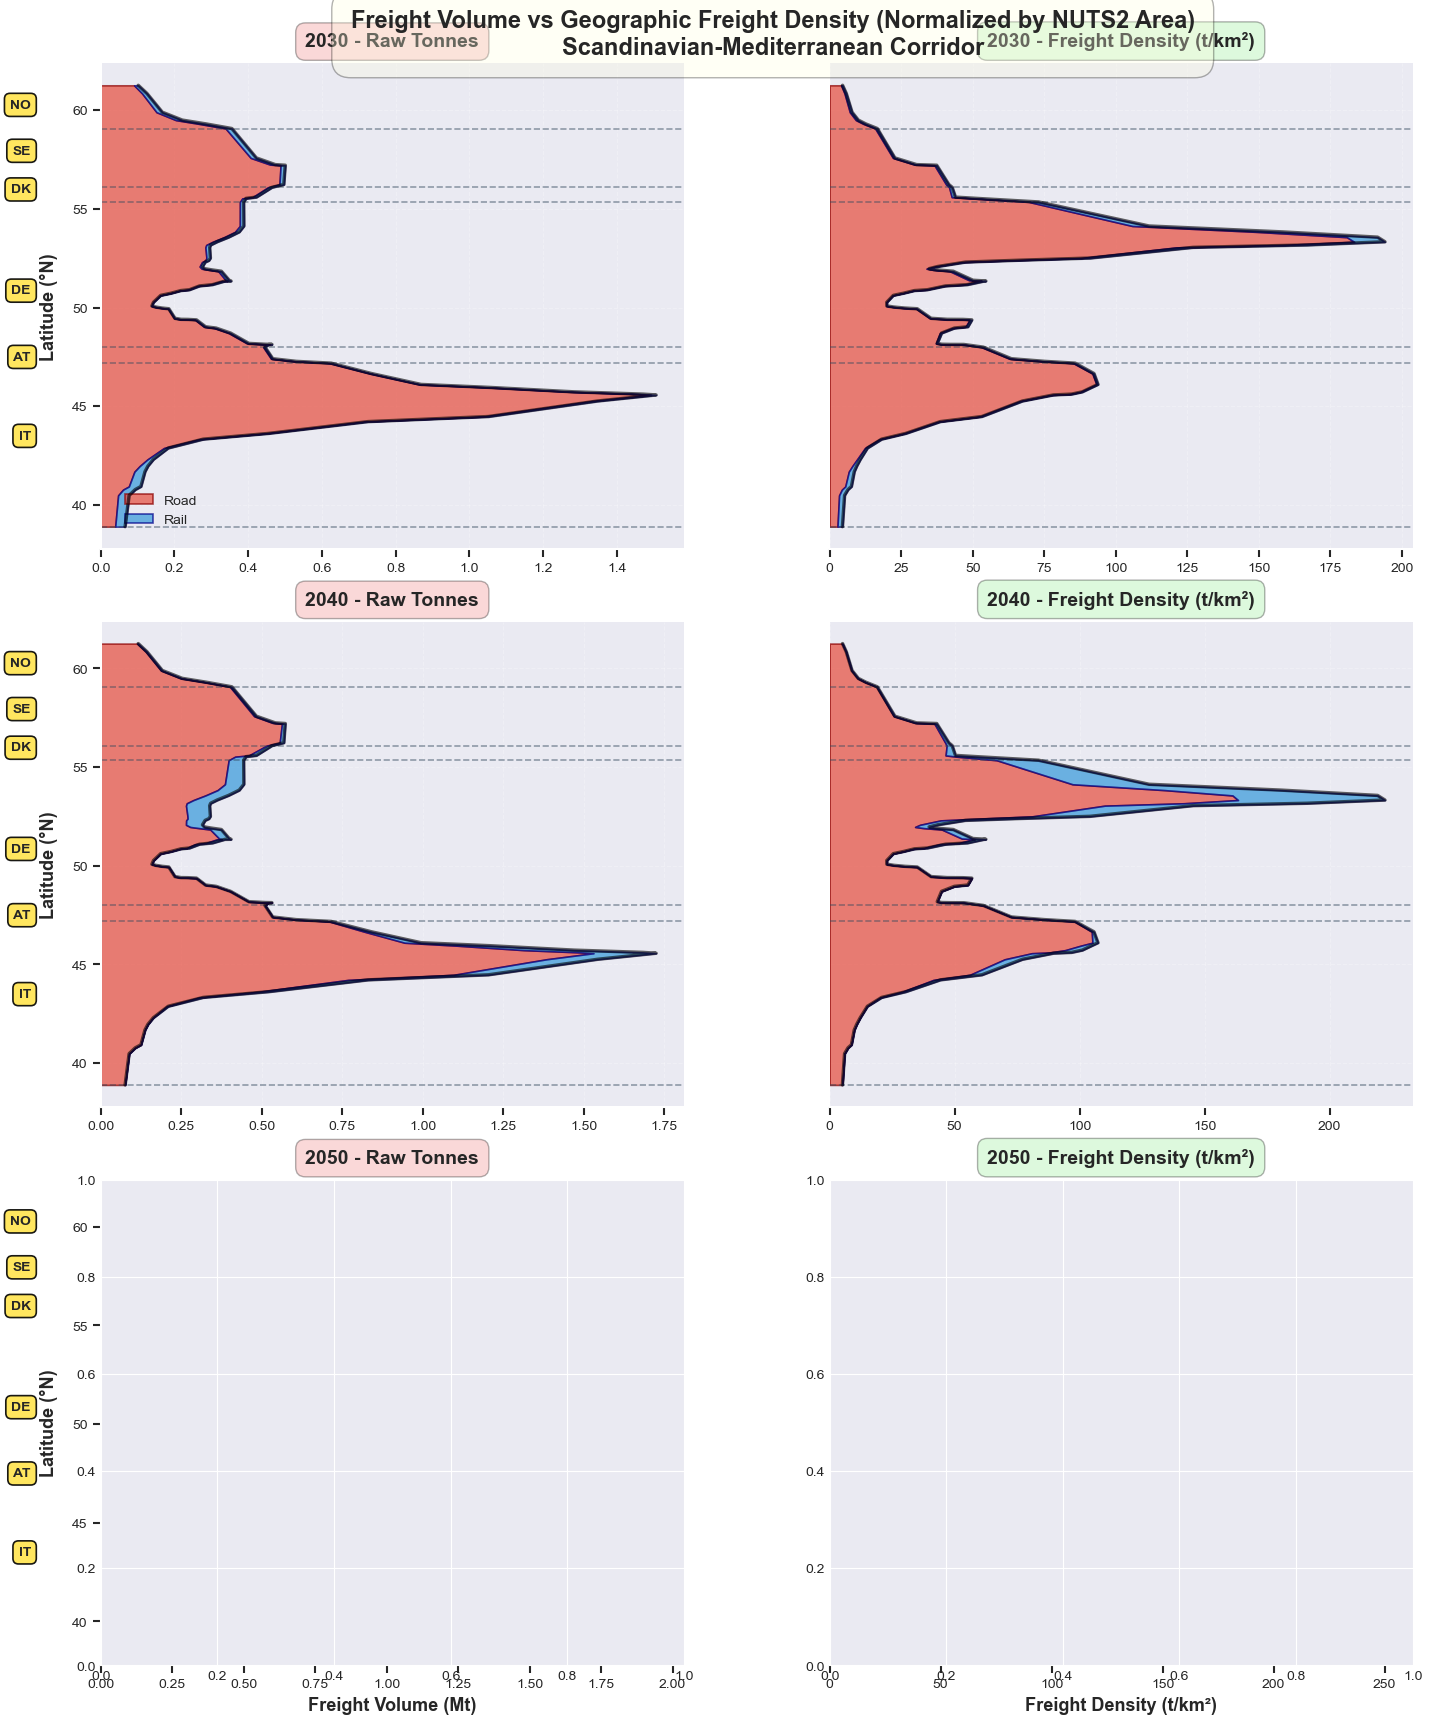


TOP 10 REGIONS BY GEOGRAPHIC FREIGHT DENSITY (2030)
Rank   NUTS2    Country       Raw Tonnes        t/km²      Area (km²)
--------------------------------------------------------------------------------
1      DE60     DE                 0.38 Mt        491.8             771
2      DE50     DE                 0.16 Mt        421.6             386
3      DE30     DE                 0.15 Mt        170.7             880
4      DEA1     DE                 0.87 Mt        164.8           5,305
5      ITC4     IT                 3.32 Mt        138.8          23,897
6      ITH1     IT                 0.99 Mt        132.8           7,440
7      DEC0     DE                 0.32 Mt        125.9           2,519
8      ITH2     IT                 0.72 Mt        115.5           6,272
9      ITH3     IT                 2.08 Mt        114.0          18,211
10     AT34     AT                 0.28 Mt        108.0           2,602

INTERPRETATION GUIDE: GEOGRAPHIC FREIGHT DENSITY

📊 WHAT THIS SHOWS:
   LEF

In [33]:
# ==============================================================================
# TONNES BY LATITUDE NORMALIZED BY NUTS2 REGION AREA
# ==============================================================================
from scipy.ndimage import gaussian_filter1d
import geopandas as gpd
from shapely.geometry import shape

def calculate_tonnes_normalized_by_area(case_study_name, nuts2_shapefile_path, target_years=[2030, 2040, 2050]):
    """
    Calculate freight tonnes normalized by NUTS2 region geographic area (km²).

    This metric shows "freight density per square kilometer" - regions with high values
    have concentrated freight traffic relative to their geographic size.

    Parameters:
        case_study_name: Name of the case study
        nuts2_shapefile_path: Path to NUTS2 regions shapefile
        target_years: Years to analyze

    Returns:
        dict: {year: {nuts2_id: {'road_tonnes': X, 'rail_tonnes': Y, 'area_km2': Z, ...}}}
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]

    # Load NUTS2 shapefile and calculate areas
    print("Loading NUTS2 shapefile and calculating areas...")
    nuts2_gdf = gpd.read_file(nuts2_shapefile_path)

    # Calculate area in km² (convert from m² if needed)
    if nuts2_gdf.crs.is_geographic:
        # If CRS is geographic (lat/lon), reproject to appropriate projected CRS
        nuts2_gdf = nuts2_gdf.to_crs('EPSG:3035')  # ETRS89-extended / LAEA Europe

    nuts2_gdf['area_km2'] = nuts2_gdf.geometry.area / 1e6  # Convert m² to km²

    # Create lookup: NUTS2 code -> area in km²
    nuts2_area_lookup = {}
    for idx, row in nuts2_gdf.iterrows():
        nuts2_code = row['NUTS_ID']  # Adjust field name if different in your shapefile
        nuts2_area_lookup[nuts2_code] = row['area_km2']

    print(f"Loaded area data for {len(nuts2_area_lookup)} NUTS2 regions")

    # Load geographic elements
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_code = geo['nuts2_region']
            nuts2_lookup[geo['id']] = {
                'nuts2': nuts2_code,
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long'],
                'country': geo.get('country', 'UNKNOWN'),
                'area_km2': nuts2_area_lookup.get(nuts2_code, None)
            }

    # Check for missing areas
    missing_areas = [n['nuts2'] for n in nuts2_lookup.values() if n['area_km2'] is None]
    if missing_areas:
        print(f"⚠️  Warning: {len(set(missing_areas))} NUTS2 regions missing area data: {set(missing_areas)}")

    # Load paths and odpairs
    paths = input_data['Path']
    odpairs = input_data['Odpair']

    path_lookup = {}
    for path in paths:
        path_lookup[path['id']] = {
            'sequence': path['sequence'],
            'distance_from_previous': path['distance_from_previous']
        }

    od_lookup = {}
    for od in odpairs:
        od_lookup[od['id']] = {
            'origin': od['from'],
            'destination': od['to']
        }

    # Calculate tonnes by region
    print("Calculating tonnes by region...")
    data_by_year_nuts2 = {year: {} for year in target_years}

    SCALING_FACTOR = 1000  # f is in kilotonnes

    for key_str, flow_value_kt in f_data.items():
        key = eval(key_str) if isinstance(key_str, str) else key_str
        year, (product_id, odpair_id, path_id), (mode_id, techvehicle_id), generation = key

        if year not in target_years or flow_value_kt <= 0:
            continue

        if path_id not in path_lookup or odpair_id not in od_lookup:
            continue

        flow_value_tonnes = flow_value_kt * SCALING_FACTOR
        path_info = path_lookup[path_id]
        mode_name = 'rail' if mode_id == 2 else 'road'

        # Add tonnes to each NUTS2 region in the path
        for node_id in path_info['sequence']:
            if node_id in nuts2_lookup:
                nuts2_id = nuts2_lookup[node_id]['nuts2']
                area_km2 = nuts2_lookup[node_id]['area_km2']

                # Skip regions without area data
                if area_km2 is None or area_km2 <= 0:
                    continue

                if nuts2_id not in data_by_year_nuts2[year]:
                    data_by_year_nuts2[year][nuts2_id] = {
                        'road_tonnes': 0.0,
                        'rail_tonnes': 0.0,
                        'lat': nuts2_lookup[node_id]['lat'],
                        'country': nuts2_lookup[node_id]['country'],
                        'area_km2': area_km2
                    }

                data_by_year_nuts2[year][nuts2_id][f'{mode_name}_tonnes'] += flow_value_tonnes

    # Normalize by area
    print("Normalizing by geographic area...")
    for year in target_years:
        for nuts2_id, data in data_by_year_nuts2[year].items():
            area = data['area_km2']

            # Calculate normalized values (tonnes per km²)
            data['road_tonnes_per_km2'] = data['road_tonnes'] / area
            data['rail_tonnes_per_km2'] = data['rail_tonnes'] / area
            data['total_tonnes'] = data['road_tonnes'] + data['rail_tonnes']
            data['total_tonnes_per_km2'] = data['total_tonnes'] / area

    return data_by_year_nuts2, nuts2_gdf

# ==============================================================================
# LOAD DATA AND CALCULATE
# ==============================================================================

# Path to NUTS2 shapefile
nuts2_shapefile = 'data/NUTS_RG_20M_2021_4326.shp'

print("="*80)
print("CALCULATING FREIGHT DENSITY NORMALIZED BY GEOGRAPHIC AREA")
print("="*80)

try:
    normalized_data, nuts2_gdf = calculate_tonnes_normalized_by_area(
        case_name,
        nuts2_shapefile,
        target_years=[2030, 2040, 2050]
    )
except FileNotFoundError:
    print(f"\n⚠️  Error: Shapefile not found at '{nuts2_shapefile}'")
    print("Please check the path to the NUTS2 shapefile.")
    print("Expected location: data/NUTS_RG_20M_2021_4326.shp")
    raise

# Display summary
print("\n" + "="*80)
print("SUMMARY: FREIGHT DENSITY BY GEOGRAPHIC AREA")
print("="*80)

for year in [2030, 2040, 2050]:
    data = normalized_data[year]

    total_road_tonnes = sum(d['road_tonnes'] for d in data.values())
    total_rail_tonnes = sum(d['rail_tonnes'] for d in data.values())
    total_tonnes = total_road_tonnes + total_rail_tonnes

    # Calculate weighted average density
    total_area = sum(d['area_km2'] for d in data.values())
    avg_density = total_tonnes / total_area if total_area > 0 else 0

    print(f"\nYear {year}:")
    print(f"  Total freight: {total_tonnes/1e9:.2f} Mt")
    print(f"  Total area: {total_area:,.0f} km²")
    print(f"  Average density: {avg_density:.2f} tonnes/km²")
    print(f"  Road: {total_road_tonnes/1e9:.2f} Mt ({100*total_road_tonnes/total_tonnes:.1f}%)")
    print(f"  Rail: {total_rail_tonnes/1e9:.2f} Mt ({100*total_rail_tonnes/total_tonnes:.1f}%)")

# ==============================================================================
# BEAUTIFUL PLOT: AREA-NORMALIZED FREIGHT DENSITY BY LATITUDE
# ==============================================================================

years_to_plot = [2030, 2040, 2050]

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure: 3 rows × 2 columns (left=raw, right=normalized)
fig = plt.figure(figsize=(16, 18))
gs = fig.add_gridspec(3, 2, hspace=0.15, wspace=0.25,
                      top=0.95, bottom=0.06, left=0.08, right=0.90)

for year_idx, year in enumerate(years_to_plot):
    data = normalized_data[year]

    if not data:
        continue

    # Prepare plotting data
    plotting_data = []
    for nuts2_id, metrics in data.items():
        plotting_data.append({
            'nuts2': nuts2_id,
            'lat': metrics['lat'],
            'country': metrics['country'],
            'road_tonnes': metrics['road_tonnes'],
            'rail_tonnes': metrics['rail_tonnes'],
            'road_tonnes_per_km2': metrics['road_tonnes_per_km2'],
            'rail_tonnes_per_km2': metrics['rail_tonnes_per_km2'],
            'area_km2': metrics['area_km2']
        })

    # Sort by latitude
    plotting_data.sort(key=lambda x: x['lat'])

    if len(plotting_data) < 2:
        continue

    # Extract arrays
    lats = np.array([d['lat'] for d in plotting_data])

    # RAW DATA
    road_tonnes = np.array([d['road_tonnes'] for d in plotting_data])
    rail_tonnes = np.array([d['rail_tonnes'] for d in plotting_data])

    # NORMALIZED DATA (tonnes per km²)
    road_tonnes_norm = np.array([d['road_tonnes_per_km2'] for d in plotting_data])
    rail_tonnes_norm = np.array([d['rail_tonnes_per_km2'] for d in plotting_data])

    # Apply Gaussian smoothing
    sigma = 2.0
    road_smooth = gaussian_filter1d(road_tonnes, sigma=sigma)
    rail_smooth = gaussian_filter1d(rail_tonnes, sigma=sigma)
    road_norm_smooth = gaussian_filter1d(road_tonnes_norm, sigma=sigma)
    rail_norm_smooth = gaussian_filter1d(rail_tonnes_norm, sigma=sigma)

    # ==============================================================================
    # LEFT COLUMN: RAW TONNES
    # ==============================================================================

    ax_raw = fig.add_subplot(gs[year_idx, 0])

    # Convert to million tonnes for readability
    road_mt = road_smooth / 1e6
    rail_mt = rail_smooth / 1e6

    # Stacked area plot
    ax_raw.fill_betweenx(lats, 0, road_mt,
                         color='#E74C3C', alpha=0.7, label='Road',
                         edgecolor='darkred', linewidth=1.2)
    ax_raw.fill_betweenx(lats, road_mt, road_mt + rail_mt,
                         color='#3498DB', alpha=0.7, label='Rail',
                         edgecolor='darkblue', linewidth=1.2)

    # Total outline
    total_mt = road_mt + rail_mt
    ax_raw.plot(total_mt, lats, 'k-', linewidth=2.5, alpha=0.6, zorder=10)

    # Styling
    ax_raw.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold', labelpad=10)
    ax_raw.set_title(f'{year} - Raw Tonnes', fontsize=14, fontweight='bold', pad=12,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.3))

    ax_raw.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
    ax_raw.set_xlim(left=0)

    # Enhanced axis styling
    ax_raw.spines['top'].set_visible(False)
    ax_raw.spines['right'].set_visible(False)
    ax_raw.spines['left'].set_linewidth(1.5)
    ax_raw.spines['bottom'].set_linewidth(1.5)
    ax_raw.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)

    if year_idx == 0:
        legend = ax_raw.legend(loc='lower left', fontsize=10, framealpha=0.95,
                              edgecolor='black', fancybox=True, shadow=True,
                              bbox_to_anchor=(0.02, 0.02))
        legend.get_frame().set_linewidth(1.5)

    # ==============================================================================
    # RIGHT COLUMN: NORMALIZED (TONNES PER KM²)
    # ==============================================================================

    ax_norm = fig.add_subplot(gs[year_idx, 1])

    # Use raw values for better visibility (tonnes/km² already reasonable scale)
    road_t_per_km2 = road_norm_smooth
    rail_t_per_km2 = rail_norm_smooth

    # Stacked area plot
    ax_norm.fill_betweenx(lats, 0, road_t_per_km2,
                          color='#E74C3C', alpha=0.7, label='Road',
                          edgecolor='darkred', linewidth=1.2)
    ax_norm.fill_betweenx(lats, road_t_per_km2, road_t_per_km2 + rail_t_per_km2,
                          color='#3498DB', alpha=0.7, label='Rail',
                          edgecolor='darkblue', linewidth=1.2)

    # Total outline
    total_t_per_km2 = road_t_per_km2 + rail_t_per_km2
    ax_norm.plot(total_t_per_km2, lats, 'k-', linewidth=2.5, alpha=0.6, zorder=10)

    # Styling
    ax_norm.set_title(f'{year} - Freight Density (t/km²)', fontsize=14, fontweight='bold', pad=12,
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))

    ax_norm.grid(True, alpha=0.25, linestyle='--', linewidth=0.8)
    ax_norm.set_xlim(left=0)

    # Enhanced axis styling
    ax_norm.spines['top'].set_visible(False)
    ax_norm.spines['right'].set_visible(False)
    ax_norm.spines['left'].set_visible(False)
    ax_norm.spines['bottom'].set_linewidth(1.5)
    ax_norm.tick_params(axis='both', which='major', labelsize=10, width=1.5, length=6)
    ax_norm.tick_params(axis='y', left=False, labelleft=False)

    # ==============================================================================
    # ADD COUNTRY LABELS AND BORDERS
    # ==============================================================================

    # Load country data
    country_centroids = pd.read_csv('country_centroids.csv')
    borders_df = pd.read_csv('country_southern_borders.csv')

    corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
    country_data = country_centroids[country_centroids['CNTR_CODE'].isin(corridor_countries)]

    for ax in [ax_raw, ax_norm]:
        ylim = ax.get_ylim()

        # Add country labels (only on left panel)
        if ax == ax_raw:
            for _, row in country_data.iterrows():
                country_code = row['CNTR_CODE']
                lat = row['centroid_lat']

                if ylim[0] <= lat <= ylim[1]:
                    ax.text(-0.12, lat, country_code, transform=ax.get_yaxis_transform(),
                           fontsize=10, fontweight='bold', va='center', ha='right',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE44D',
                                    edgecolor='black', linewidth=1.2, alpha=0.9))

        # Add border lines
        for _, row in borders_df.iterrows():
            country = row['CNTR_CODE']
            border_lat = row['southern_border_lat']

            if country in corridor_countries and ylim[0] <= border_lat <= ylim[1]:
                ax.axhline(y=border_lat, color='#34495E', linestyle='--',
                          linewidth=1.2, alpha=0.5, zorder=1)

# X-axis labels
axes_bottom = [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])]
axes_bottom[0].set_xlabel('Freight Volume (Mt)', fontsize=13, fontweight='bold', labelpad=10)
axes_bottom[1].set_xlabel('Freight Density (t/km²)', fontsize=13, fontweight='bold', labelpad=10)

# Overall title
fig.suptitle('Freight Volume vs Geographic Freight Density (Normalized by NUTS2 Area)\n' +
            'Scandinavian-Mediterranean Corridor',
            fontsize=17, fontweight='bold', y=0.98,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', alpha=0.3))

# Save with high quality
plt.savefig('tonnes_normalized_by_area.png', dpi=400,
            bbox_inches='tight', facecolor='white', edgecolor='none')
print("\n✓ High-quality plot saved as 'tonnes_normalized_by_area.png' (400 DPI)")
plt.show()

# ==============================================================================
# TOP REGIONS ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("TOP 10 REGIONS BY GEOGRAPHIC FREIGHT DENSITY (2030)")
print("="*80)

year_2030_data = []
for nuts2_id, metrics in normalized_data[2030].items():
    year_2030_data.append({
        'nuts2': nuts2_id,
        'country': metrics['country'],
        'lat': metrics['lat'],
        'total_tonnes': metrics['total_tonnes'],
        'total_tonnes_per_km2': metrics['total_tonnes_per_km2'],
        'area_km2': metrics['area_km2']
    })

# Sort by area-normalized density
year_2030_data.sort(key=lambda x: x['total_tonnes_per_km2'], reverse=True)

print(f"{'Rank':<6} {'NUTS2':<8} {'Country':<8} {'Raw Tonnes':>15} {'t/km²':>12} {'Area (km²)':>15}")
print("-" * 80)

for i, d in enumerate(year_2030_data[:10], 1):
    print(f"{i:<6} {d['nuts2']:<8} {d['country']:<8} "
          f"{d['total_tonnes']/1e6:>14.2f} Mt {d['total_tonnes_per_km2']:>12.1f} "
          f"{d['area_km2']:>15,.0f}")

# ==============================================================================
# INTERPRETATION GUIDE
# ==============================================================================

print("\n" + "="*80)
print("INTERPRETATION GUIDE: GEOGRAPHIC FREIGHT DENSITY")
print("="*80)
print("""
📊 WHAT THIS SHOWS:
   LEFT PANELS:  Raw freight volume (tonnes) passing through each latitude
   RIGHT PANELS: Freight density normalized by NUTS2 region geographic area (tonnes/km²)

🗺️ WHY NORMALIZE BY GEOGRAPHIC AREA?

   Geographic area normalization reveals TRUE freight concentration:

   • LARGE REGIONS (e.g., Scandinavia):
     - May have high raw tonnes simply due to large geographic size
     - Normalization reveals actual freight density (tonnes per unit area)

   • SMALL REGIONS (e.g., city-states, dense urban areas):
     - May appear to have low raw tonnes despite high activity
     - Normalization amplifies these true high-density logistics hubs

📈 INTERPRETING THE RESULTS:

   HIGH t/km² values = Geographic freight "hotspots"
   - High traffic concentration per unit area
   - Intense logistics activity
   - Urban/metropolitan centers with dense freight flows

   LOW t/km² values = Sparse freight distribution
   - Large regions with dispersed activity
   - Rural or low-population areas
   - Transit corridors through low-density regions

🎯 KEY INSIGHTS:

   • Urban regions will show dramatically higher normalized density
   • Large northern regions (NO, SE) will show lower density despite high raw volumes
   • Small industrial regions (parts of DE, IT) may reveal hidden intensity
   • Identifies TRUE logistics bottlenecks and congestion points

📏 AREA CALCULATION:
   • Areas calculated from NUTS2 official shapefile (GISCO)
   • Projected to EPSG:3035 (ETRS89-LAEA Europe) for accurate km² calculation
   • Typical NUTS2 areas: 1,000-20,000 km²

🔍 COMPARISON WITH NETWORK-BASED NORMALIZATION:
   • Geographic area (this plot): Physical freight concentration
   • Network distance (previous plot): Infrastructure utilization intensity
   • Both perspectives reveal different aspects of freight patterns

⚠️ IMPORTANT:
   • Regions with missing area data are excluded
   • Uses NUTS 2021 boundaries
   • Full freight (imports + exports + domestic + transit) counted at each node
""")


CALCULATING SPATIAL FREIGHT DISTRIBUTION
✓ Saved: spatial_freight_2030_full.png


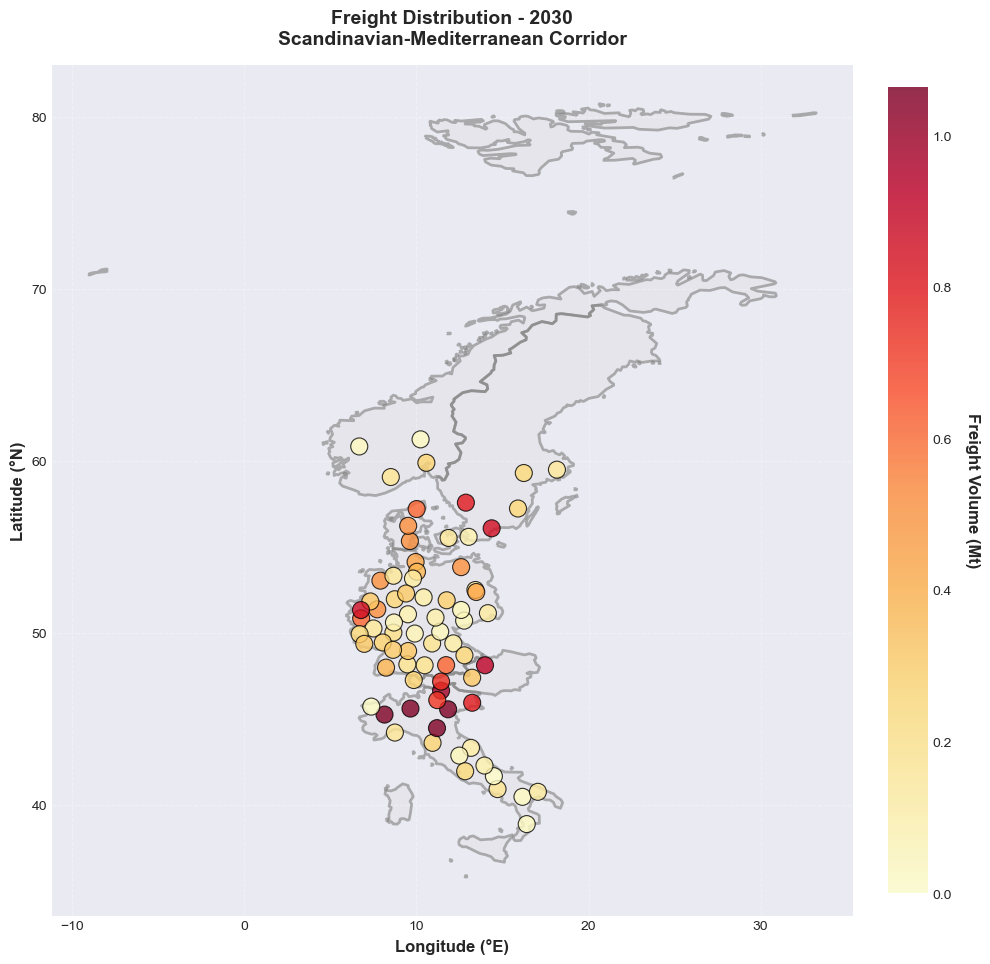

✓ Saved: spatial_freight_2030_italy.png


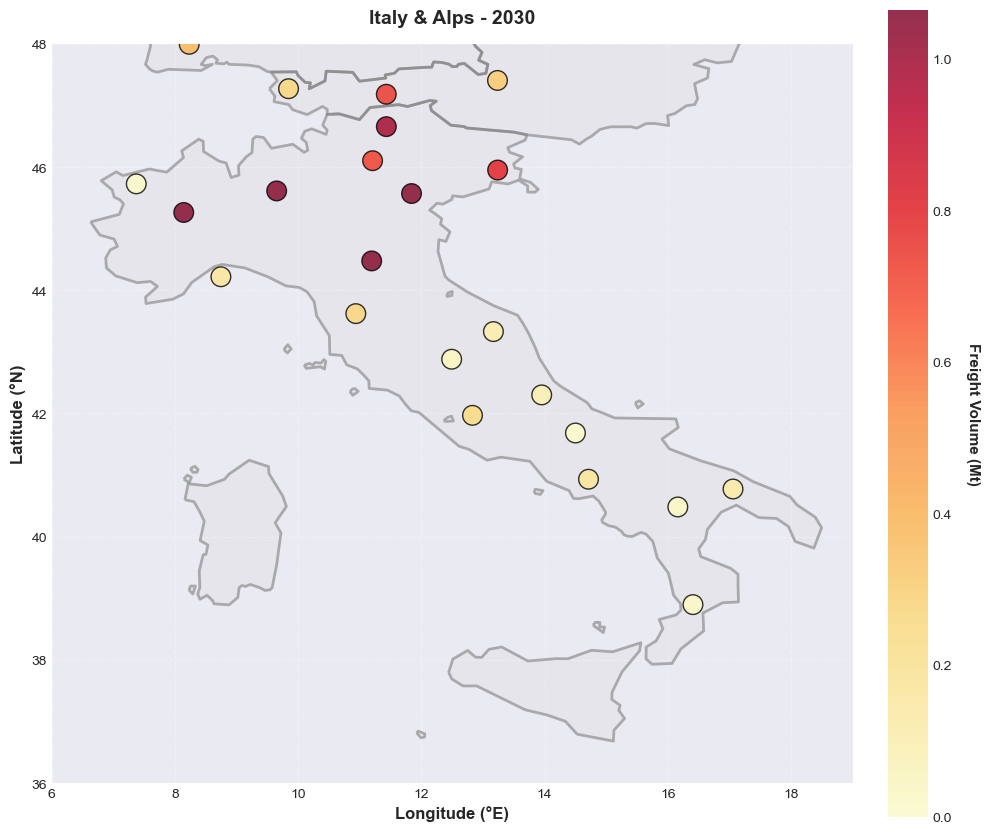

✓ Saved: spatial_freight_2030_central_europe.png


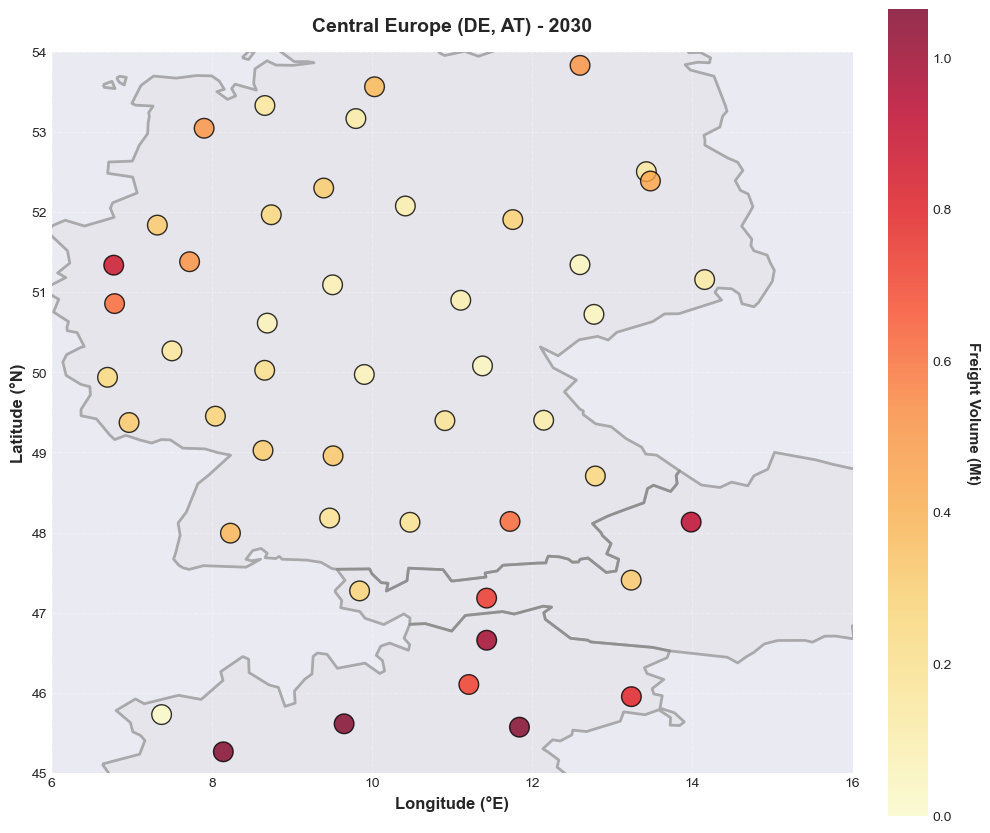

✓ Saved: spatial_freight_2030_northern_europe.png


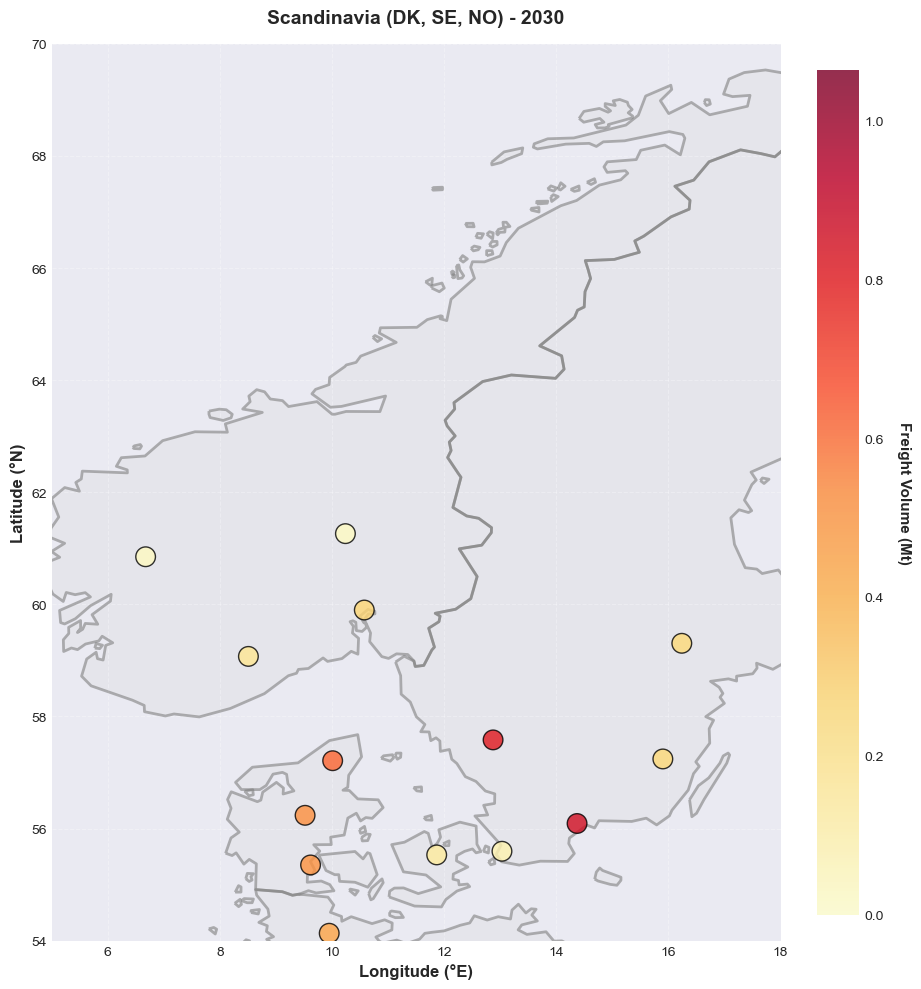


SPATIAL PLOTS CREATED

Created 4 maps for year 2030:

1. Full corridor view: spatial_freight_2030_full.png
2. Italy & Alps zoom: spatial_freight_2030_italy.png
3. Central Europe zoom: spatial_freight_2030_central_europe.png
4. Scandinavia zoom: spatial_freight_2030_northern_europe.png

💡 TO CHANGE YEAR:
   Modify the 'year_to_plot' variable at the top of this cell
   Options: 2030, 2040, 2050

📊 ADVANTAGES:
   • Faster rendering (no interactive overhead)
   • Multiple zoom levels automatically generated
   • High-quality static images for papers
   • Each region saved separately for presentations



In [34]:
# ==============================================================================
# SPATIAL FREIGHT DISTRIBUTION: SIMPLIFIED VERSION WITH REGIONAL VIEWS
# ==============================================================================
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def calculate_spatial_freight_distribution(case_study_name, target_years=[2030, 2040, 2050]):
    """
    Calculate freight tonnes by geographic coordinates (longitude, latitude).
    """
    input_data = loaded_runs[case_study_name]["input_data"]
    output_data = loaded_runs[case_study_name]["output_data"]
    f_data = output_data["f"]

    # Load geographic elements
    geo_elements = input_data['GeographicElement']
    nuts2_lookup = {}
    for geo in geo_elements:
        if geo['type'] == 'node' and 'nuts2_region' in geo and geo['nuts2_region']:
            nuts2_lookup[geo['id']] = {
                'nuts2': geo['nuts2_region'],
                'lat': geo['coordinate_lat'],
                'lon': geo['coordinate_long'],
                'country': geo.get('country', 'UNKNOWN')
            }

    # Load paths
    paths = input_data['Path']
    path_lookup = {}
    for path in paths:
        path_lookup[path['id']] = {'sequence': path['sequence']}

    # Calculate tonnes by NUTS2 region
    data_by_year_nuts2 = {year: {} for year in target_years}
    SCALING_FACTOR = 1000

    for key_str, flow_value_kt in f_data.items():
        key = eval(key_str) if isinstance(key_str, str) else key_str
        year, (product_id, odpair_id, path_id), (mode_id, techvehicle_id), generation = key

        if year not in target_years or flow_value_kt <= 0:
            continue

        if path_id not in path_lookup:
            continue

        flow_value_tonnes = flow_value_kt * SCALING_FACTOR
        path_info = path_lookup[path_id]
        mode_name = 'rail' if mode_id == 2 else 'road'

        for node_id in path_info['sequence']:
            if node_id in nuts2_lookup:
                nuts2_id = nuts2_lookup[node_id]['nuts2']

                if nuts2_id not in data_by_year_nuts2[year]:
                    data_by_year_nuts2[year][nuts2_id] = {
                        'road_tonnes': 0.0,
                        'rail_tonnes': 0.0,
                        'lat': nuts2_lookup[node_id]['lat'],
                        'lon': nuts2_lookup[node_id]['lon'],
                        'country': nuts2_lookup[node_id]['country']
                    }

                data_by_year_nuts2[year][nuts2_id][f'{mode_name}_tonnes'] += flow_value_tonnes

    # Calculate totals
    for year in target_years:
        for nuts2_id, data in data_by_year_nuts2[year].items():
            data['total_tonnes'] = data['road_tonnes'] + data['rail_tonnes']

    return data_by_year_nuts2

# Calculate data
print("="*80)
print("CALCULATING SPATIAL FREIGHT DISTRIBUTION")
print("="*80)
spatial_data = calculate_spatial_freight_distribution(case_name, target_years=[2030, 2040, 2050])

# Load country borders
try:
    nuts0_shapefile = 'data/NUTS_RG_20M_2021_4326.shp'
    countries_gdf = gpd.read_file(nuts0_shapefile)
    corridor_countries = ['IT', 'AT', 'DE', 'DK', 'NO', 'SE']
    countries_gdf = countries_gdf[countries_gdf['LEVL_CODE'] == 0]
    countries_gdf = countries_gdf[countries_gdf['CNTR_CODE'].isin(corridor_countries)]
    has_borders = True
except:
    has_borders = False
    print("⚠️  Could not load country borders")

# ==============================================================================
# PLOT: SINGLE YEAR, SIMPLIFIED LAYOUT
# ==============================================================================

# Choose year to plot (can change to 2040 or 2050)
year_to_plot = 2030

data = spatial_data[year_to_plot]

# Prepare plotting data
plotting_data = []
for nuts2_id, metrics in data.items():
    plotting_data.append({
        'nuts2': nuts2_id,
        'lat': metrics['lat'],
        'lon': metrics['lon'],
        'country': metrics['country'],
        'road_tonnes': metrics['road_tonnes'],
        'rail_tonnes': metrics['rail_tonnes'],
        'total_tonnes': metrics['total_tonnes']
    })

lons = np.array([d['lon'] for d in plotting_data])
lats = np.array([d['lat'] for d in plotting_data])
total_tonnes = np.array([d['total_tonnes'] for d in plotting_data])
road_tonnes = np.array([d['road_tonnes'] for d in plotting_data])

# Convert to million tonnes
total_mt = total_tonnes / 1e6

# ==============================================================================
# MAIN PLOT: FULL CORRIDOR
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 14))

# Plot country borders
if has_borders:
    countries_gdf.boundary.plot(ax=ax, color='gray', linewidth=2, alpha=0.6, zorder=1)
    countries_gdf.plot(ax=ax, color='lightgray', alpha=0.2, zorder=0)

# Scatter plot
scatter = ax.scatter(lons, lats,
                    c=total_mt,
                    s=150,
                    cmap='YlOrRd',
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=0.8,
                    vmin=0,
                    vmax=np.percentile(total_mt, 95),
                    zorder=5)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Freight Volume (Mt)', fontsize=12, fontweight='bold', rotation=270, labelpad=20)

# Styling
ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
ax.set_title(f'Freight Distribution - {year_to_plot}\nScandinavian-Mediterranean Corridor',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(f'spatial_freight_{year_to_plot}_full.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: spatial_freight_{year_to_plot}_full.png")
plt.show()

# ==============================================================================
# REGIONAL ZOOM PLOTS
# ==============================================================================

# Define regions to zoom into
zoom_regions = {
    'Italy': {'lon_range': (6, 19), 'lat_range': (36, 48), 'title': 'Italy & Alps'},
    'Central Europe': {'lon_range': (6, 16), 'lat_range': (45, 54), 'title': 'Central Europe (DE, AT)'},
    'Northern Europe': {'lon_range': (5, 18), 'lat_range': (54, 70), 'title': 'Scandinavia (DK, SE, NO)'},
}

for region_name, bounds in zoom_regions.items():
    # Filter data to region
    mask = ((lons >= bounds['lon_range'][0]) & (lons <= bounds['lon_range'][1]) &
            (lats >= bounds['lat_range'][0]) & (lats <= bounds['lat_range'][1]))

    if not np.any(mask):
        continue

    lons_region = lons[mask]
    lats_region = lats[mask]
    total_mt_region = total_mt[mask]

    # Create zoomed plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plot country borders
    if has_borders:
        countries_gdf.boundary.plot(ax=ax, color='gray', linewidth=2, alpha=0.6, zorder=1)
        countries_gdf.plot(ax=ax, color='lightgray', alpha=0.2, zorder=0)

    # Scatter plot
    scatter = ax.scatter(lons_region, lats_region,
                        c=total_mt_region,
                        s=200,
                        cmap='YlOrRd',
                        alpha=0.8,
                        edgecolor='black',
                        linewidth=1,
                        vmin=0,
                        vmax=np.percentile(total_mt, 95),
                        zorder=5)

    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Freight Volume (Mt)', fontsize=11, fontweight='bold', rotation=270, labelpad=20)

    # Set zoom bounds
    ax.set_xlim(bounds['lon_range'])
    ax.set_ylim(bounds['lat_range'])

    # Styling
    ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
    ax.set_title(f'{bounds["title"]} - {year_to_plot}',
                fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()

    # Save
    filename = f'spatial_freight_{year_to_plot}_{region_name.replace(" ", "_").lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

# ==============================================================================
# SUMMARY
# ==============================================================================

print("\n" + "="*80)
print("SPATIAL PLOTS CREATED")
print("="*80)
print(f"""
Created {1 + len(zoom_regions)} maps for year {year_to_plot}:

1. Full corridor view: spatial_freight_{year_to_plot}_full.png
2. Italy & Alps zoom: spatial_freight_{year_to_plot}_italy.png
3. Central Europe zoom: spatial_freight_{year_to_plot}_central_europe.png
4. Scandinavia zoom: spatial_freight_{year_to_plot}_northern_europe.png

💡 TO CHANGE YEAR:
   Modify the 'year_to_plot' variable at the top of this cell
   Options: 2030, 2040, 2050

📊 ADVANTAGES:
   • Faster rendering (no interactive overhead)
   • Multiple zoom levels automatically generated
   • High-quality static images for papers
   • Each region saved separately for presentations
""")
